In [ ]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = convnext_tiny(weights=weights).eval()
print("loaded")

loaded


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

# -------------------
# 1) Setup
# -------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

# CIFAR-100 normalization (standard)
cifar_mean = (0.5071, 0.4867, 0.4408)
cifar_std  = (0.2675, 0.2565, 0.2761)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

train_ds = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# -------------------
# 2) Load pretrained ConvNeXt-Tiny + replace head
# -------------------
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = convnext_tiny(weights=weights)

# Replace classifier head to 100 classes
# torchvision ConvNeXt: model.classifier = Sequential(LayerNorm2d, Flatten, Linear)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 100)

model = model.to(device)

# -------------------
# 3) Training config (simple baseline)
# -------------------
criterion = nn.CrossEntropyLoss()

# Two LR groups: smaller for backbone, bigger for new head
backbone_params = []
head_params = []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    if "classifier.2" in name:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 1e-4},
        {"params": head_params, "lr": 5e-4},
    ],
    weight_decay=0.05
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# -------------------
# 4) Train / Eval loops
# -------------------
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * y.size(0)

            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    return loss_sum / total, correct / total

def train_one_epoch(model, loader):
    model.train()
    total = 0
    loss_sum = 0.0
    correct = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * y.size(0)
        total += y.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()

    return loss_sum / total, correct / total

best_acc = 0.0
epochs = 20

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc = evaluate(model, test_loader)
    scheduler.step()

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), "convnext_tiny_cifar100_baseline.pth")

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} "
          f"| test loss {te_loss:.4f} acc {te_acc:.4f} | best {best_acc:.4f}")

print("Saved best model to convnext_tiny_cifar100_baseline.pth")

100%|██████████| 169M/169M [00:03<00:00, 55.9MB/s]


Epoch 01 | train loss 1.7401 acc 0.5405 | test loss 1.1121 acc 0.6701 | best 0.6701
Epoch 02 | train loss 0.9754 acc 0.7108 | test loss 0.9590 acc 0.7115 | best 0.7115
Epoch 03 | train loss 0.7460 acc 0.7738 | test loss 0.9177 acc 0.7300 | best 0.7300
Epoch 04 | train loss 0.5873 acc 0.8198 | test loss 0.9077 acc 0.7388 | best 0.7388
Epoch 05 | train loss 0.4642 acc 0.8559 | test loss 0.9250 acc 0.7407 | best 0.7407
Epoch 06 | train loss 0.3648 acc 0.8851 | test loss 0.9223 acc 0.7485 | best 0.7485
Epoch 07 | train loss 0.2846 acc 0.9113 | test loss 0.9416 acc 0.7500 | best 0.7500
Epoch 08 | train loss 0.2198 acc 0.9309 | test loss 0.9488 acc 0.7548 | best 0.7548
Epoch 09 | train loss 0.1762 acc 0.9460 | test loss 0.9697 acc 0.7537 | best 0.7548
Epoch 10 | train loss 0.1446 acc 0.9558 | test loss 0.9958 acc 0.7564 | best 0.7564
Epoch 11 | train loss 0.1180 acc 0.9644 | test loss 1.0011 acc 0.7611 | best 0.7611
Epoch 12 | train loss 0.0938 acc 0.9724 | test loss 1.0092 acc 0.7643 | best

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import convnext_tiny

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Build the same architecture you trained
model = convnext_tiny(weights=None)

# Replace head to 100 classes (must match training)
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 100)

model = model.to(device)

# 2) Load the checkpoint
ckpt_path = "/content/convnext_tiny_cifar100_baseline.pth"  # adjust if different location
state = torch.load(ckpt_path, map_location=device)

# (Optional) inspect what you loaded
print(type(state))
if isinstance(state, dict):
    print("num keys:", len(state))
    first_key = next(iter(state.keys()))
    print("first key:", first_key)

# 3) Apply weights
model.load_state_dict(state, strict=True)
model.eval()

print("Loaded fine-tuned CIFAR-100 model ✅")
print("Classifier out features:", model.classifier[2].out_features)


<class 'collections.OrderedDict'>
num keys: 182
first key: features.0.0.weight
Loaded fine-tuned CIFAR-100 model ✅
Classifier out features: 100


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

# CIFAR-100 normalization (same as before)
cifar_mean = (0.5071, 0.4867, 0.4408)
cifar_std  = (0.2675, 0.2565, 0.2761)

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_ds = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

correct = 0
total = 0

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

acc = correct / total
print(f"CIFAR-100 test accuracy: {acc:.4f} ({acc*100:.2f}%)")


CIFAR-100 test accuracy: 0.7724 (77.24%)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

# -----------------------
# 0) Setup
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

# CIFAR-100 normalization (same as your baseline)
cifar_mean = (0.5071, 0.4867, 0.4408)
cifar_std  = (0.2675, 0.2565, 0.2761)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

train_ds = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

# -----------------------
# 1) Attention block (for 2D feature maps)
# -----------------------
class GatedMHSA2D(nn.Module):
    """
    Takes x: (B, C, H, W)
    Flattens spatial to tokens L=H*W and runs MHSA over tokens.
    Uses a learnable gate alpha initialized to 0:
        y = x + alpha * Attn(x)
    """
    def __init__(self, C: int, num_heads: int = 4, attn_dropout: float = 0.0):
        super().__init__()
        assert C % num_heads == 0, "C must be divisible by num_heads"
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads,
                                          dropout=attn_dropout, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)  # (B, L, C)
        tokens_n = self.norm(tokens)
        out, _ = self.attn(tokens_n, tokens_n, tokens_n, need_weights=False)  # (B, L, C)
        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)  # (B, C, H, W)
        return x + self.alpha * out

# -----------------------
# 2) Build ConvNeXt-Tiny (ImageNet pretrained) + CIFAR head + insert attention in the "middle"
# -----------------------
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
base = convnext_tiny(weights=weights)

# replace head to 100 classes
in_features = base.classifier[2].in_features
base.classifier[2] = nn.Linear(in_features, 100)

# Insert attention BETWEEN features[3] (Stage2) and features[4] (Downsample2)
# Stage2 channel dim for tiny is 192 (see block_setting in torchvision code) :contentReference[oaicite:1]{index=1}
attn_mid = GatedMHSA2D(C=192, num_heads=4)

new_features = nn.Sequential(
    base.features[0],  # stem
    base.features[1],  # stage1
    base.features[2],  # downsample1
    base.features[3],  # stage2
    attn_mid,          # <-- attention inserted here (middle)
    base.features[4],  # downsample2
    base.features[5],  # stage3
    base.features[6],  # downsample3
    base.features[7],  # stage4
)
base.features = new_features

model = base.to(device)

print("Feature modules:")
for i, m in enumerate(model.features):
    print(i, type(m).__name__)
print("Attention alpha init:", float(attn_mid.alpha.item()))

# -----------------------
# 3) Helpers: freeze/unfreeze
# -----------------------
def set_requires_grad(module: nn.Module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

def phase1_freeze_backbone(model):
    # Freeze everything
    set_requires_grad(model, False)
    # Train attention block + classifier only
    set_requires_grad(attn_mid, True)
    set_requires_grad(model.classifier, True)

def phase2_unfreeze_last_stage(model):
    # Keep whatever is already trainable, and additionally unfreeze "last stage"
    # We define last stage as features[7] plus its preceding downsample features[6].
    set_requires_grad(model.features[6], True)
    set_requires_grad(model.features[7], True)

# -----------------------
# 4) Train/Eval
# -----------------------
criterion = nn.CrossEntropyLoss()

def make_optimizer_phase1(model):
    params = list(attn_mid.parameters()) + list(model.classifier.parameters())
    return torch.optim.AdamW(params, lr=5e-4, weight_decay=0.05)

def make_optimizer_phase2(model):
    # smaller LR for unfrozen backbone last stage, larger for attention+head
    return torch.optim.AdamW(
        [
            {"params": model.features[6].parameters(), "lr": 1e-4},
            {"params": model.features[7].parameters(), "lr": 1e-4},
            {"params": attn_mid.parameters(), "lr": 5e-4},
            {"params": model.classifier.parameters(), "lr": 5e-4},
        ],
        weight_decay=0.05
    )

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(model, loader, optimizer):
    model.train()
    correct, total = 0, 0
    loss_sum = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

# -----------------------
# 5) Run 2-phase schedule (20 epochs total)
# -----------------------
epochs = 20
warmup_epochs = 5

best_acc = 0.0
best_path = "convnext_tiny_cifar100_attn_mid.pth"

# Phase 1
phase1_freeze_backbone(model)
optimizer = make_optimizer_phase1(model)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

for epoch in range(1, epochs + 1):
    # switch to Phase 2 at epoch warmup_epochs+1
    if epoch == warmup_epochs + 1:
        phase2_unfreeze_last_stage(model)
        optimizer = make_optimizer_phase2(model)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs)

    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
    te_loss, te_acc = evaluate(model, test_loader)
    scheduler.step()

    alpha_val = float(attn_mid.alpha.item())

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), best_path)

    print(f"Epoch {epoch:02d} | train acc {tr_acc:.4f} | test acc {te_acc:.4f} | best {best_acc:.4f} | alpha {alpha_val:.4f}")

print("Saved best attention model to:", best_path)


Feature modules:
0 Conv2dNormActivation
1 Sequential
2 Sequential
3 Sequential
4 GatedMHSA2D
5 Sequential
6 Sequential
7 Sequential
8 Sequential
Attention alpha init: 0.0
Epoch 01 | train acc 0.4197 | test acc 0.5490 | best 0.5490 | alpha 0.0710
Epoch 02 | train acc 0.5678 | test acc 0.5899 | best 0.5899 | alpha 0.0852
Epoch 03 | train acc 0.6069 | test acc 0.6095 | best 0.6095 | alpha 0.0964
Epoch 04 | train acc 0.6301 | test acc 0.6261 | best 0.6261 | alpha 0.1052
Epoch 05 | train acc 0.6498 | test acc 0.6344 | best 0.6344 | alpha 0.1128
Epoch 06 | train acc 0.6700 | test acc 0.6705 | best 0.6705 | alpha 0.0985
Epoch 07 | train acc 0.7247 | test acc 0.6900 | best 0.6900 | alpha 0.0905
Epoch 08 | train acc 0.7625 | test acc 0.6992 | best 0.6992 | alpha 0.0869
Epoch 09 | train acc 0.7948 | test acc 0.7085 | best 0.7085 | alpha 0.0853
Epoch 10 | train acc 0.8229 | test acc 0.7162 | best 0.7162 | alpha 0.0832
Epoch 11 | train acc 0.8503 | test acc 0.7259 | best 0.7259 | alpha 0.0833
Epoc

In [ ]:
# ============================================================
# Run ConvNeXt-Tiny + 1 Gated MHSA block experiments (E1..E6)
# CIFAR-100, 20 epochs, fixed recipe
# Placements: P2 (middle after stage2) / P3 (late after stage3)
# Freezing: F0 frozen / F1 last-stage / F2 full
# ============================================================

import os, time, copy, math, random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

# -----------------------
# Global config
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 20
WARMUP_EPOCHS = 5   # used in F1/F2
BATCH_TRAIN = 128
BATCH_TEST  = 256
NUM_WORKERS = 2

# LRs (match your previous style; adjust only if you decide later)
LR_HEAD_ATTN = 5e-4
LR_BACKBONE_SMALL = 5e-5
WD = 0.05

SAVE_DIR = "./runs_attn_grid"
os.makedirs(SAVE_DIR, exist_ok=True)

def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# -----------------------
# Data (same normalization you used)
# -----------------------
cifar_mean = (0.5071, 0.4867, 0.4408)
cifar_std  = (0.2675, 0.2565, 0.2761)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

train_ds = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# -----------------------
# Attention block (A0)
# -----------------------
class GatedMHSA2D(nn.Module):
    """
    x: (B,C,H,W)
    tokens: (B,L,C), L=H*W
    y = x + alpha * MHSA(LN(tokens))
    alpha is learnable, init 0.
    """
    def __init__(self, C: int, num_heads: int = 4, attn_dropout: float = 0.0):
        super().__init__()
        assert C % num_heads == 0
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads,
                                          dropout=attn_dropout, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)  # (B,L,C)
        t = self.norm(tokens)
        out, _ = self.attn(t, t, t, need_weights=False)    # (B,L,C)
        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)  # (B,C,H,W)
        return x + self.alpha * out

# -----------------------
# Build model with 1 attention block at placement
# Torchvision features layout:
# [0 stem,1 stage1,2 down1,3 stage2,4 down2,5 stage3,6 down3,7 stage4]
# P2 (middle): insert between features[3] and features[4] => C=192
# P3 (late):   insert between features[5] and features[6] => C=384
# -----------------------
def build_model_with_attention(placement: str):
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)

    # head -> 100 classes
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 100)

    if placement == "P2":  # middle
        attn = GatedMHSA2D(C=192, num_heads=4)
        new_features = nn.Sequential(
            model.features[0],
            model.features[1],
            model.features[2],
            model.features[3],  # stage2
            attn,               # insert
            model.features[4],  # down2
            model.features[5],
            model.features[6],
            model.features[7],
        )
    elif placement == "P3":  # late
        attn = GatedMHSA2D(C=384, num_heads=4)
        new_features = nn.Sequential(
            model.features[0],
            model.features[1],
            model.features[2],
            model.features[3],
            model.features[4],
            model.features[5],  # stage3
            attn,               # insert
            model.features[6],  # down3
            model.features[7],
        )
    else:
        raise ValueError("placement must be 'P2' or 'P3'")

    model.features = new_features
    return model, attn

# -----------------------
# Freeze / unfreeze helpers
# -----------------------
def set_requires_grad(module: nn.Module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

def apply_F0_frozen(model, attn):
    # train attn + head only, everything else frozen
    set_requires_grad(model, False)
    set_requires_grad(attn, True)
    set_requires_grad(model.classifier, True)

def apply_F1_laststage_phase2(model):
    # unfreeze last stage only = down3 + stage4 (features[6] and [7] in standard layout)
    # but note: features indices still correspond to final two modules in model.features
    # We'll unfreeze the LAST TWO modules of model.features to be robust to P2/P3 insertion.
    set_requires_grad(model.features[-2], True)  # down3
    set_requires_grad(model.features[-1], True)  # stage4

def apply_F2_full_phase2(model):
    set_requires_grad(model, True)

# -----------------------
# Optimizers per regime
# -----------------------
def make_opt_F0(model, attn):
    params = list(attn.parameters()) + list(model.classifier.parameters())
    return torch.optim.AdamW(params, lr=LR_HEAD_ATTN, weight_decay=WD)

def make_opt_F1_phase2(model, attn):
    # last two modules LR small, attn/head LR larger
    return torch.optim.AdamW(
        [
            {"params": model.features[-2].parameters(), "lr": 1e-4},
            {"params": model.features[-1].parameters(), "lr": 1e-4},
            {"params": attn.parameters(), "lr": LR_HEAD_ATTN},
            {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
        ],
        weight_decay=WD
    )

def make_opt_F2_phase2(model, attn):
    attn_param_ids = {id(p) for p in attn.parameters()}
    backbone = []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if name.startswith("classifier."):
            continue
        if id(p) in attn_param_ids:  # skip attention params here
            continue
        backbone.append(p)

    return torch.optim.AdamW(
        [
            {"params": backbone, "lr": LR_BACKBONE_SMALL},
            {"params": attn.parameters(), "lr": LR_HEAD_ATTN},
            {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
        ],
        weight_decay=WD
    )

# -----------------------
# Train / eval
# -----------------------
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    loss_sum = 0.0
    for x, y in test_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(model, optimizer):
    model.train()
    correct, total = 0, 0
    loss_sum = 0.0
    for x, y in train_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

# -----------------------
# Run one experiment
# -----------------------
def run_experiment(exp_name: str, placement: str, freeze_regime: str, seed: int = 0):
    """
    freeze_regime: 'F0' (frozen), 'F1' (last-stage), 'F2' (full)
    """
    set_seed(seed)
    model, attn = build_model_with_attention(placement)
    model = model.to(DEVICE)

    best_acc = 0.0
    best_path = os.path.join(SAVE_DIR, f"{exp_name}_best.pth")

    # Phase 1 setup
    if freeze_regime in ["F0", "F1", "F2"]:
        apply_F0_frozen(model, attn)  # Phase 1 = always attn+head only
    else:
        raise ValueError("freeze_regime must be F0/F1/F2")

    # Optimizer/scheduler for phase 1
    opt = make_opt_F0(model, attn)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS if freeze_regime=="F0" else WARMUP_EPOCHS)

    t0 = time.time()
    logs = []

    for epoch in range(1, EPOCHS + 1):
        # Phase 2 switch (only for F1/F2)
        if freeze_regime in ["F1", "F2"] and epoch == WARMUP_EPOCHS + 1:
            if freeze_regime == "F1":
                apply_F1_laststage_phase2(model)
                opt = make_opt_F1_phase2(model, attn)
            else:
                apply_F2_full_phase2(model)
                opt = make_opt_F2_phase2(model, attn)

            sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

        tr_loss, tr_acc = train_one_epoch(model, opt)
        te_loss, te_acc = evaluate(model)
        sch.step()

        alpha_val = float(attn.alpha.item())
        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), best_path)

        line = {
            "exp": exp_name,
            "epoch": epoch,
            "train_acc": tr_acc,
            "test_acc": te_acc,
            "best": best_acc,
            "alpha": alpha_val,
        }
        logs.append(line)

        print(f"{exp_name} | Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | alpha {alpha_val:.4f}")

    total_time = time.time() - t0
    return {
        "exp": exp_name,
        "placement": placement,
        "freeze": freeze_regime,
        "seed": seed,
        "best_acc": best_acc,
        "best_ckpt": best_path,
        "time_sec": total_time,
        "final_alpha": float(attn.alpha.item()),
        "logs": logs,
    }

# -----------------------
# Experiment list (E1..E6)
# -----------------------
EXPERIMENTS = [
    ("E1_P2_F0", "P2", "F0"),
    ("E2_P2_F1", "P2", "F1"),  # already ran something similar; included for completeness
    ("E3_P2_F2", "P2", "F2"),
    ("E4_P3_F0", "P3", "F0"),
    ("E5_P3_F1", "P3", "F1"),
    ("E6_P3_F2", "P3", "F2"),
]

# -----------------------
# Run all
# -----------------------
results = []
for name, placement, freeze in EXPERIMENTS:
    print("\n" + "="*80)
    print(f"Running {name}: placement={placement}, freeze={freeze}, epochs={EPOCHS}, warmup={WARMUP_EPOCHS}")
    print("="*80)
    out = run_experiment(name, placement, freeze, seed=0)
    results.append(out)

# -----------------------
# Summary table
# -----------------------
print("\n\n===== SUMMARY =====")
for r in results:
    print(f"{r['exp']}: placement={r['placement']} freeze={r['freeze']} best_acc={r['best_acc']*100:.2f}% "
          f"final_alpha={r['final_alpha']:.4f} time={r['time_sec']/60:.1f} min")
print("Saved checkpoints in:", SAVE_DIR)



Running E1_P2_F0: placement=P2, freeze=F0, epochs=20, warmup=5
E1_P2_F0 | Epoch 01 | train 0.4197 | test 0.5490 | best 0.5490 | alpha 0.0710
E1_P2_F0 | Epoch 02 | train 0.5678 | test 0.5899 | best 0.5899 | alpha 0.0852
E1_P2_F0 | Epoch 03 | train 0.6069 | test 0.6095 | best 0.6095 | alpha 0.0964
E1_P2_F0 | Epoch 04 | train 0.6301 | test 0.6261 | best 0.6261 | alpha 0.1052
E1_P2_F0 | Epoch 05 | train 0.6498 | test 0.6344 | best 0.6344 | alpha 0.1128
E1_P2_F0 | Epoch 06 | train 0.6606 | test 0.6422 | best 0.6422 | alpha 0.1173
E1_P2_F0 | Epoch 07 | train 0.6700 | test 0.6420 | best 0.6422 | alpha 0.1258
E1_P2_F0 | Epoch 08 | train 0.6790 | test 0.6493 | best 0.6493 | alpha 0.1310
E1_P2_F0 | Epoch 09 | train 0.6865 | test 0.6519 | best 0.6519 | alpha 0.1357
E1_P2_F0 | Epoch 10 | train 0.6948 | test 0.6561 | best 0.6561 | alpha 0.1425
E1_P2_F0 | Epoch 11 | train 0.7006 | test 0.6584 | best 0.6584 | alpha 0.1479
E1_P2_F0 | Epoch 12 | train 0.7069 | test 0.6561 | best 0.6584 | alpha 0.1549


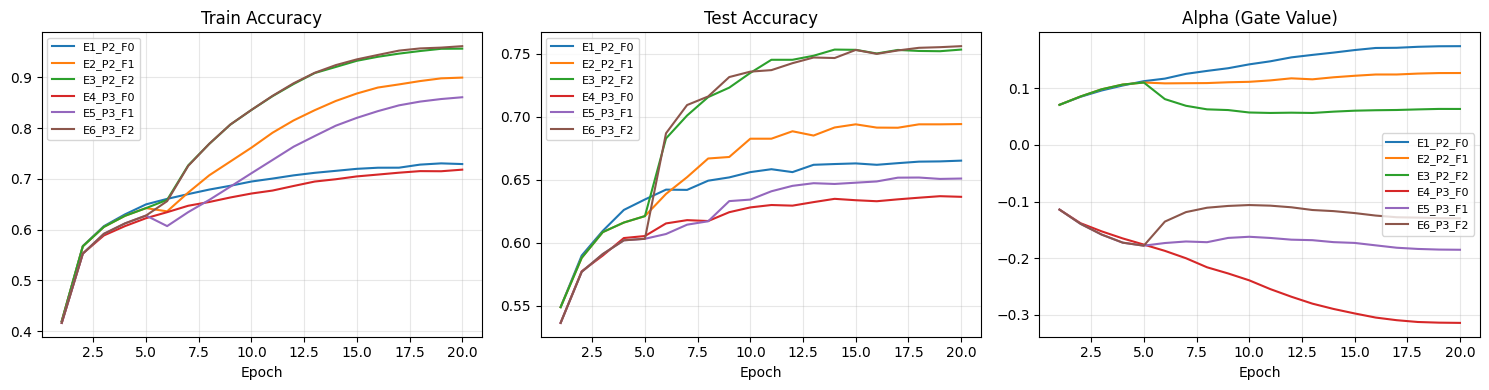

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Assuming `results` is your list of experiment dicts
for r in results:
    epochs = [log['epoch'] for log in r['logs']]
    train_acc = [log['train_acc'] for log in r['logs']]
    test_acc = [log['test_acc'] for log in r['logs']]
    alpha = [log['alpha'] for log in r['logs']]

    axes[0].plot(epochs, train_acc, label=r['exp'])
    axes[1].plot(epochs, test_acc, label=r['exp'])
    axes[2].plot(epochs, alpha, label=r['exp'])

axes[0].set_title('Train Accuracy')
axes[1].set_title('Test Accuracy')
axes[2].set_title('Alpha (Gate Value)')

for ax in axes:
    ax.set_xlabel('Epoch')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

In [ ]:
# ============================================================
# EXPERIMENT A: Multiple Attention Blocks (P2 + P3)
# ============================================================
#
# MOTIVATION:
# In the previous experiments, we inserted a single Gated MHSA block
# at either P2 (after stage2, C=192) or P3 (after stage3, C=384).
# The question here is: does stacking TWO attention blocks help?
#
# HYPOTHESIS:
# - Attention at P2 captures mid-level spatial relationships (larger feature maps)
# - Attention at P3 captures higher-level semantic relationships (smaller feature maps)
# - Combining both might give the network flexibility to attend at multiple scales
#
# ARCHITECTURE:
# stem -> stage1 -> down1 -> stage2 -> [MHSA_P2] -> down2 -> stage3 -> [MHSA_P3] -> down3 -> stage4 -> head
#
# TRAINING STRATEGY:
# - Phase 1 (epochs 1-5): Freeze backbone, train only attention blocks + classifier
# - Phase 2 (epochs 6-20): Unfreeze everything, use differential LRs
#   - Backbone: 5e-5
#   - Attention + Head: 5e-4
#
# COMPARISON:
# We'll compare against:
# - Baseline (no attention): 77.24%
# - Single MHSA at P2 with F1 freeze strategy: ~69.42%
#
# EXPECTED OUTCOME:
# If dual attention helps, we should see improvement over single attention.
# If not, the extra parameters might just cause overfitting or the two
# attention blocks might be redundant.
# ============================================================

import os, time, random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 20
WARMUP_EPOCHS = 5
BATCH_TRAIN = 128
BATCH_TEST = 256
NUM_WORKERS = 2
LR_HEAD_ATTN = 5e-4
LR_BACKBONE_SMALL = 5e-5
WD = 0.05

def set_seed(seed=0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# -----------------------
# Data (CIFAR-100 with standard normalization)
# -----------------------
cifar_mean = (0.5071, 0.4867, 0.4408)
cifar_std = (0.2675, 0.2565, 0.2761)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

train_ds = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -----------------------
# Gated Multi-Head Self-Attention Block
# -----------------------
# This block:
# 1. Flattens spatial dimensions (H,W) into a sequence of tokens
# 2. Applies layer norm + multi-head self-attention
# 3. Uses a learnable gate (alpha) initialized to 0
#    Output: x + alpha * Attention(x)
#    This allows the network to gradually learn how much to rely on attention
# -----------------------
class GatedMHSA2D(nn.Module):
    def __init__(self, C, num_heads=4, attn_dropout=0.0):
        super().__init__()
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads,
                                          dropout=attn_dropout, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        t = self.norm(tokens)
        out, _ = self.attn(t, t, t, need_weights=False)
        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)
        return x + self.alpha * out

# -----------------------
# Model Builder: ConvNeXt-Tiny with TWO attention blocks
# -----------------------
# Inserts MHSA at two positions:
# - P2: After stage2 (C=192, feature map ~8x8 for CIFAR)
# - P3: After stage3 (C=384, feature map ~4x4 for CIFAR)
# -----------------------
def build_model_dual_attention():
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)

    # Replace classifier head for CIFAR-100 (100 classes)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 100)

    # Create two attention blocks at different depths
    attn_p2 = GatedMHSA2D(C=192, num_heads=4)  # after stage2
    attn_p3 = GatedMHSA2D(C=384, num_heads=4)  # after stage3

    # Rebuild the feature extractor with attention blocks inserted
    new_features = nn.Sequential(
        model.features[0],  # stem
        model.features[1],  # stage1
        model.features[2],  # down1
        model.features[3],  # stage2
        attn_p2,            # <-- MHSA after stage2
        model.features[4],  # down2
        model.features[5],  # stage3
        attn_p3,            # <-- MHSA after stage3
        model.features[6],  # down3
        model.features[7],  # stage4
    )
    model.features = new_features
    return model, attn_p2, attn_p3

# -----------------------
# Freeze/Unfreeze Utilities
# -----------------------
def set_requires_grad(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

def freeze_backbone_only(model, attn_p2, attn_p3):
    """Phase 1: Only train attention blocks and classifier"""
    set_requires_grad(model, False)
    set_requires_grad(attn_p2, True)
    set_requires_grad(attn_p3, True)
    set_requires_grad(model.classifier, True)

def unfreeze_all(model):
    """Phase 2: Train everything"""
    set_requires_grad(model, True)

# -----------------------
# Optimizer Builders
# -----------------------
def make_opt_phase1(model, attn_p2, attn_p3):
    """Phase 1 optimizer: only attention + classifier params"""
    params = list(attn_p2.parameters()) + list(attn_p3.parameters()) + list(model.classifier.parameters())
    return torch.optim.AdamW(params, lr=LR_HEAD_ATTN, weight_decay=WD)

def make_opt_phase2(model, attn_p2, attn_p3):
    """
    Phase 2 optimizer: differential learning rates
    - Backbone (excluding attention): lower LR (5e-5)
    - Attention blocks + classifier: higher LR (5e-4)

    NOTE: We must exclude attention params from backbone group to avoid
    the "parameters appear in more than one group" error
    """
    attn_ids = {id(p) for p in attn_p2.parameters()} | {id(p) for p in attn_p3.parameters()}
    backbone = [p for n, p in model.named_parameters()
                if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]

    return torch.optim.AdamW([
        {"params": backbone, "lr": LR_BACKBONE_SMALL},
        {"params": attn_p2.parameters(), "lr": LR_HEAD_ATTN},
        {"params": attn_p3.parameters(), "lr": LR_HEAD_ATTN},
        {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
    ], weight_decay=WD)

# -----------------------
# Training and Evaluation Functions
# -----------------------
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss_sum += criterion(logits, y).item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(model, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

# -----------------------
# Run Experiment A
# -----------------------
print("="*70)
print("EXPERIMENT A: Dual Attention (P2 + P3)")
print("="*70)

set_seed(0)
model, attn_p2, attn_p3 = build_model_dual_attention()
model = model.to(DEVICE)

# Phase 1 setup
freeze_backbone_only(model, attn_p2, attn_p3)
opt = make_opt_phase1(model, attn_p2, attn_p3)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

logs_exp_a = []
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    # Switch to Phase 2 after warmup
    if epoch == WARMUP_EPOCHS + 1:
        print("-"*50)
        print("Switching to Phase 2: Unfreezing all layers")
        print("-"*50)
        unfreeze_all(model)
        opt = make_opt_phase2(model, attn_p2, attn_p3)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

    tr_loss, tr_acc = train_one_epoch(model, opt)
    te_loss, te_acc = evaluate(model)
    sch.step()

    alpha_p2 = attn_p2.alpha.item()
    alpha_p3 = attn_p3.alpha.item()

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), "exp_a_dual_attn_best.pth")

    logs_exp_a.append({
        "epoch": epoch,
        "train_acc": tr_acc,
        "test_acc": te_acc,
        "train_loss": tr_loss,
        "test_loss": te_loss,
        "alpha_p2": alpha_p2,
        "alpha_p3": alpha_p3
    })

    print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | α_p2 {alpha_p2:.4f} | α_p3 {alpha_p3:.4f}")

print(f"\n>>> Experiment A Final Best Accuracy: {best_acc*100:.2f}%")

EXPERIMENT A: Dual Attention (P2 + P3)
Epoch 01 | train 0.4436 | test 0.5715 | best 0.5715 | α_p2 -0.0502 | α_p3 0.1003
Epoch 02 | train 0.5963 | test 0.6142 | best 0.6142 | α_p2 -0.0611 | α_p3 0.1123
Epoch 03 | train 0.6349 | test 0.6332 | best 0.6332 | α_p2 -0.0711 | α_p3 0.1274
Epoch 04 | train 0.6615 | test 0.6461 | best 0.6461 | α_p2 -0.0770 | α_p3 0.1373
Epoch 05 | train 0.6738 | test 0.6506 | best 0.6506 | α_p2 -0.0796 | α_p3 0.1420
--------------------------------------------------
Switching to Phase 2: Unfreezing all layers
--------------------------------------------------
Epoch 06 | train 0.6743 | test 0.6811 | best 0.6811 | α_p2 -0.0621 | α_p3 0.1151
Epoch 07 | train 0.7309 | test 0.7064 | best 0.7064 | α_p2 -0.0538 | α_p3 0.1030
Epoch 08 | train 0.7737 | test 0.7202 | best 0.7202 | α_p2 -0.0511 | α_p3 0.0941
Epoch 09 | train 0.8055 | test 0.7323 | best 0.7323 | α_p2 -0.0495 | α_p3 0.0927
Epoch 10 | train 0.8378 | test 0.7414 | best 0.7414 | α_p2 -0.0460 | α_p3 0.0937
Epoch

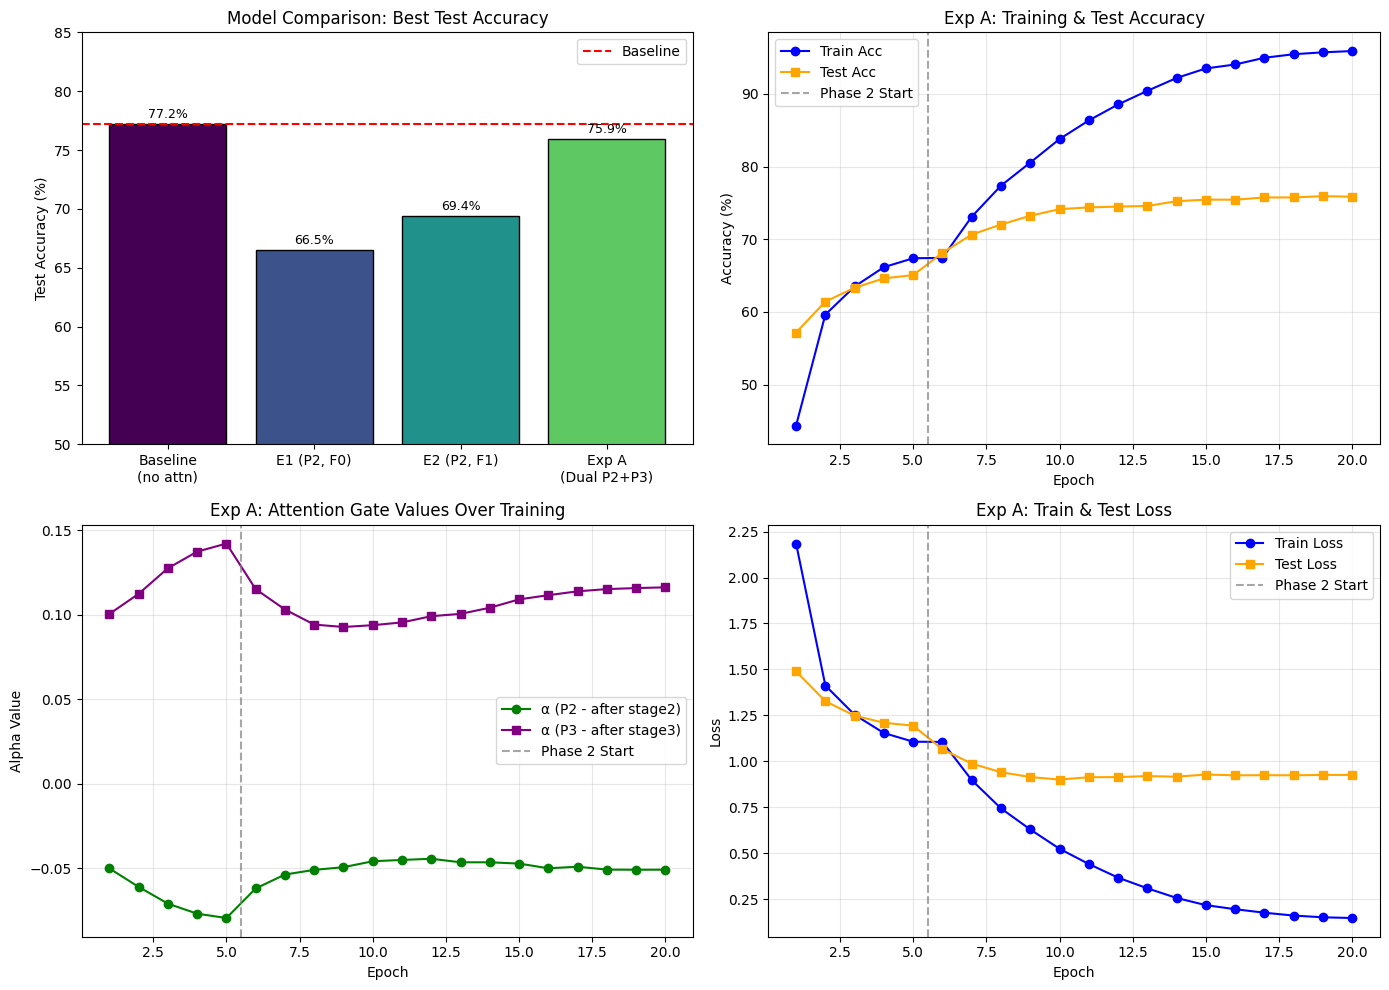


EXPERIMENT A SUMMARY
Baseline (no attention):     77.24%
E1 (P2, F0):              66.52%
E2 (P2, F1):              69.42%
Exp A (Dual P2+P3):          75.93%
Improvement over best single MHSA: +6.51%
Gap to baseline:                   -1.31%


"\nOBSERVATIONS:\n1. Alpha evolution: \n   - Does P2 or P3 have higher alpha? This tells us which depth benefits more from attention.\n   - Do they converge to similar values or diverge?\n\n2. Accuracy:\n   - Did dual attention beat single attention?\n   - How far are we from the baseline?\n\n3. Overfitting:\n   - Is there a big gap between train and test accuracy?\n   - Does test loss increase while train loss decreases? (classic overfitting signal)\n\n4. Phase transition:\n   - Did unfreezing the backbone (Phase 2) help or hurt?\n   - Look for jumps in accuracy at epoch 6.\n\nNEXT STEPS:\n- If dual attention helped -> Try 3 attention blocks\n- If dual attention didn't help -> The model might not need attention at multiple scales\n- Move to Experiment B: vary number of attention heads\n"

In [ ]:
# ============================================================
# EXPERIMENT A: Results Visualization & Comparison
# ============================================================
#
# This cell generates:
# 1. Bar chart comparing all models tested so far
# 2. Training curves (train/test accuracy over epochs)
# 3. Alpha (gate) evolution for both attention blocks
# 4. Loss curves to check for overfitting
#
# We compare against:
# - Baseline (no attention): 77.24%
# - Single MHSA experiments from the grid search (E1-E6)
# - This experiment (dual attention)
# ============================================================

import matplotlib.pyplot as plt

# -----------------------
# Previous Results (fill in from your actual runs)
# -----------------------
baseline_acc = 0.7724  # Vanilla ConvNeXt-Tiny fine-tuned on CIFAR-100

# From grid search (use whatever completed)
single_attn_results = {
    "E1 (P2, F0)": 0.6652,
    "E2 (P2, F1)": 0.6942,
    # "E3 (P2, F2)": crashed
    # E4-E6 didn't run yet
}

dual_attn_acc = best_acc  # From experiment A above

# -----------------------
# Figure 1: Model Comparison Bar Chart
# -----------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect all models for comparison
all_models = {"Baseline\n(no attn)": baseline_acc}
all_models.update(single_attn_results)
all_models["Exp A\n(Dual P2+P3)"] = dual_attn_acc

names = list(all_models.keys())
accs = list(all_models.values())

colors = plt.cm.viridis([i / len(names) for i in range(len(names))])
bars = axes[0, 0].bar(names, [a*100 for a in accs], color=colors, edgecolor='black')
axes[0, 0].set_ylabel("Test Accuracy (%)")
axes[0, 0].set_title("Model Comparison: Best Test Accuracy")
axes[0, 0].set_ylim(50, 85)
axes[0, 0].axhline(y=baseline_acc*100, color='red', linestyle='--', label='Baseline')

for bar, acc in zip(bars, accs):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f"{acc*100:.1f}%", ha='center', fontsize=9)
axes[0, 0].legend()

# -----------------------
# Figure 2: Training Curves
# -----------------------
epochs = [l['epoch'] for l in logs_exp_a]
train_acc = [l['train_acc'] for l in logs_exp_a]
test_acc = [l['test_acc'] for l in logs_exp_a]

axes[0, 1].plot(epochs, [a*100 for a in train_acc], 'o-', label='Train Acc', color='blue')
axes[0, 1].plot(epochs, [a*100 for a in test_acc], 's-', label='Test Acc', color='orange')
axes[0, 1].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.7, label='Phase 2 Start')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy (%)")
axes[0, 1].set_title("Exp A: Training & Test Accuracy")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# -----------------------
# Figure 3: Alpha (Gate) Evolution
# -----------------------
alpha_p2 = [l['alpha_p2'] for l in logs_exp_a]
alpha_p3 = [l['alpha_p3'] for l in logs_exp_a]

axes[1, 0].plot(epochs, alpha_p2, 'o-', label='α (P2 - after stage2)', color='green')
axes[1, 0].plot(epochs, alpha_p3, 's-', label='α (P3 - after stage3)', color='purple')
axes[1, 0].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.7, label='Phase 2 Start')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Alpha Value")
axes[1, 0].set_title("Exp A: Attention Gate Values Over Training")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# -----------------------
# Figure 4: Loss Curves (check for overfitting)
# -----------------------
train_loss = [l['train_loss'] for l in logs_exp_a]
test_loss = [l['test_loss'] for l in logs_exp_a]

axes[1, 1].plot(epochs, train_loss, 'o-', label='Train Loss', color='blue')
axes[1, 1].plot(epochs, test_loss, 's-', label='Test Loss', color='orange')
axes[1, 1].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.7, label='Phase 2 Start')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].set_title("Exp A: Train & Test Loss")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("exp_a_dual_attention_results.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# Summary Statistics
# -----------------------
print("\n" + "="*70)
print("EXPERIMENT A SUMMARY")
print("="*70)
print(f"Baseline (no attention):     {baseline_acc*100:.2f}%")
for name, acc in single_attn_results.items():
    print(f"{name}:              {acc*100:.2f}%")
print(f"Exp A (Dual P2+P3):          {dual_attn_acc*100:.2f}%")
print("="*70)
print(f"Improvement over best single MHSA: {(dual_attn_acc - max(single_attn_results.values()))*100:+.2f}%")
print(f"Gap to baseline:                   {(dual_attn_acc - baseline_acc)*100:+.2f}%")
print("="*70)

# -----------------------
# Observations (to fill in after running)
# -----------------------
"""
OBSERVATIONS:
1. Alpha evolution:
   - Does P2 or P3 have higher alpha? This tells us which depth benefits more from attention.
   - Do they converge to similar values or diverge?

2. Accuracy:
   - Did dual attention beat single attention?
   - How far are we from the baseline?

3. Overfitting:
   - Is there a big gap between train and test accuracy?
   - Does test loss increase while train loss decreases? (classic overfitting signal)

4. Phase transition:
   - Did unfreezing the backbone (Phase 2) help or hurt?
   - Look for jumps in accuracy at epoch 6.

NEXT STEPS:
- If dual attention helped -> Try 3 attention blocks
- If dual attention didn't help -> The model might not need attention at multiple scales
- Move to Experiment B: vary number of attention heads
"""

Loading model and visualizing attention maps...
Loaded checkpoint from exp_a_dual_attn_best.pth

1. Attention maps on sample images:


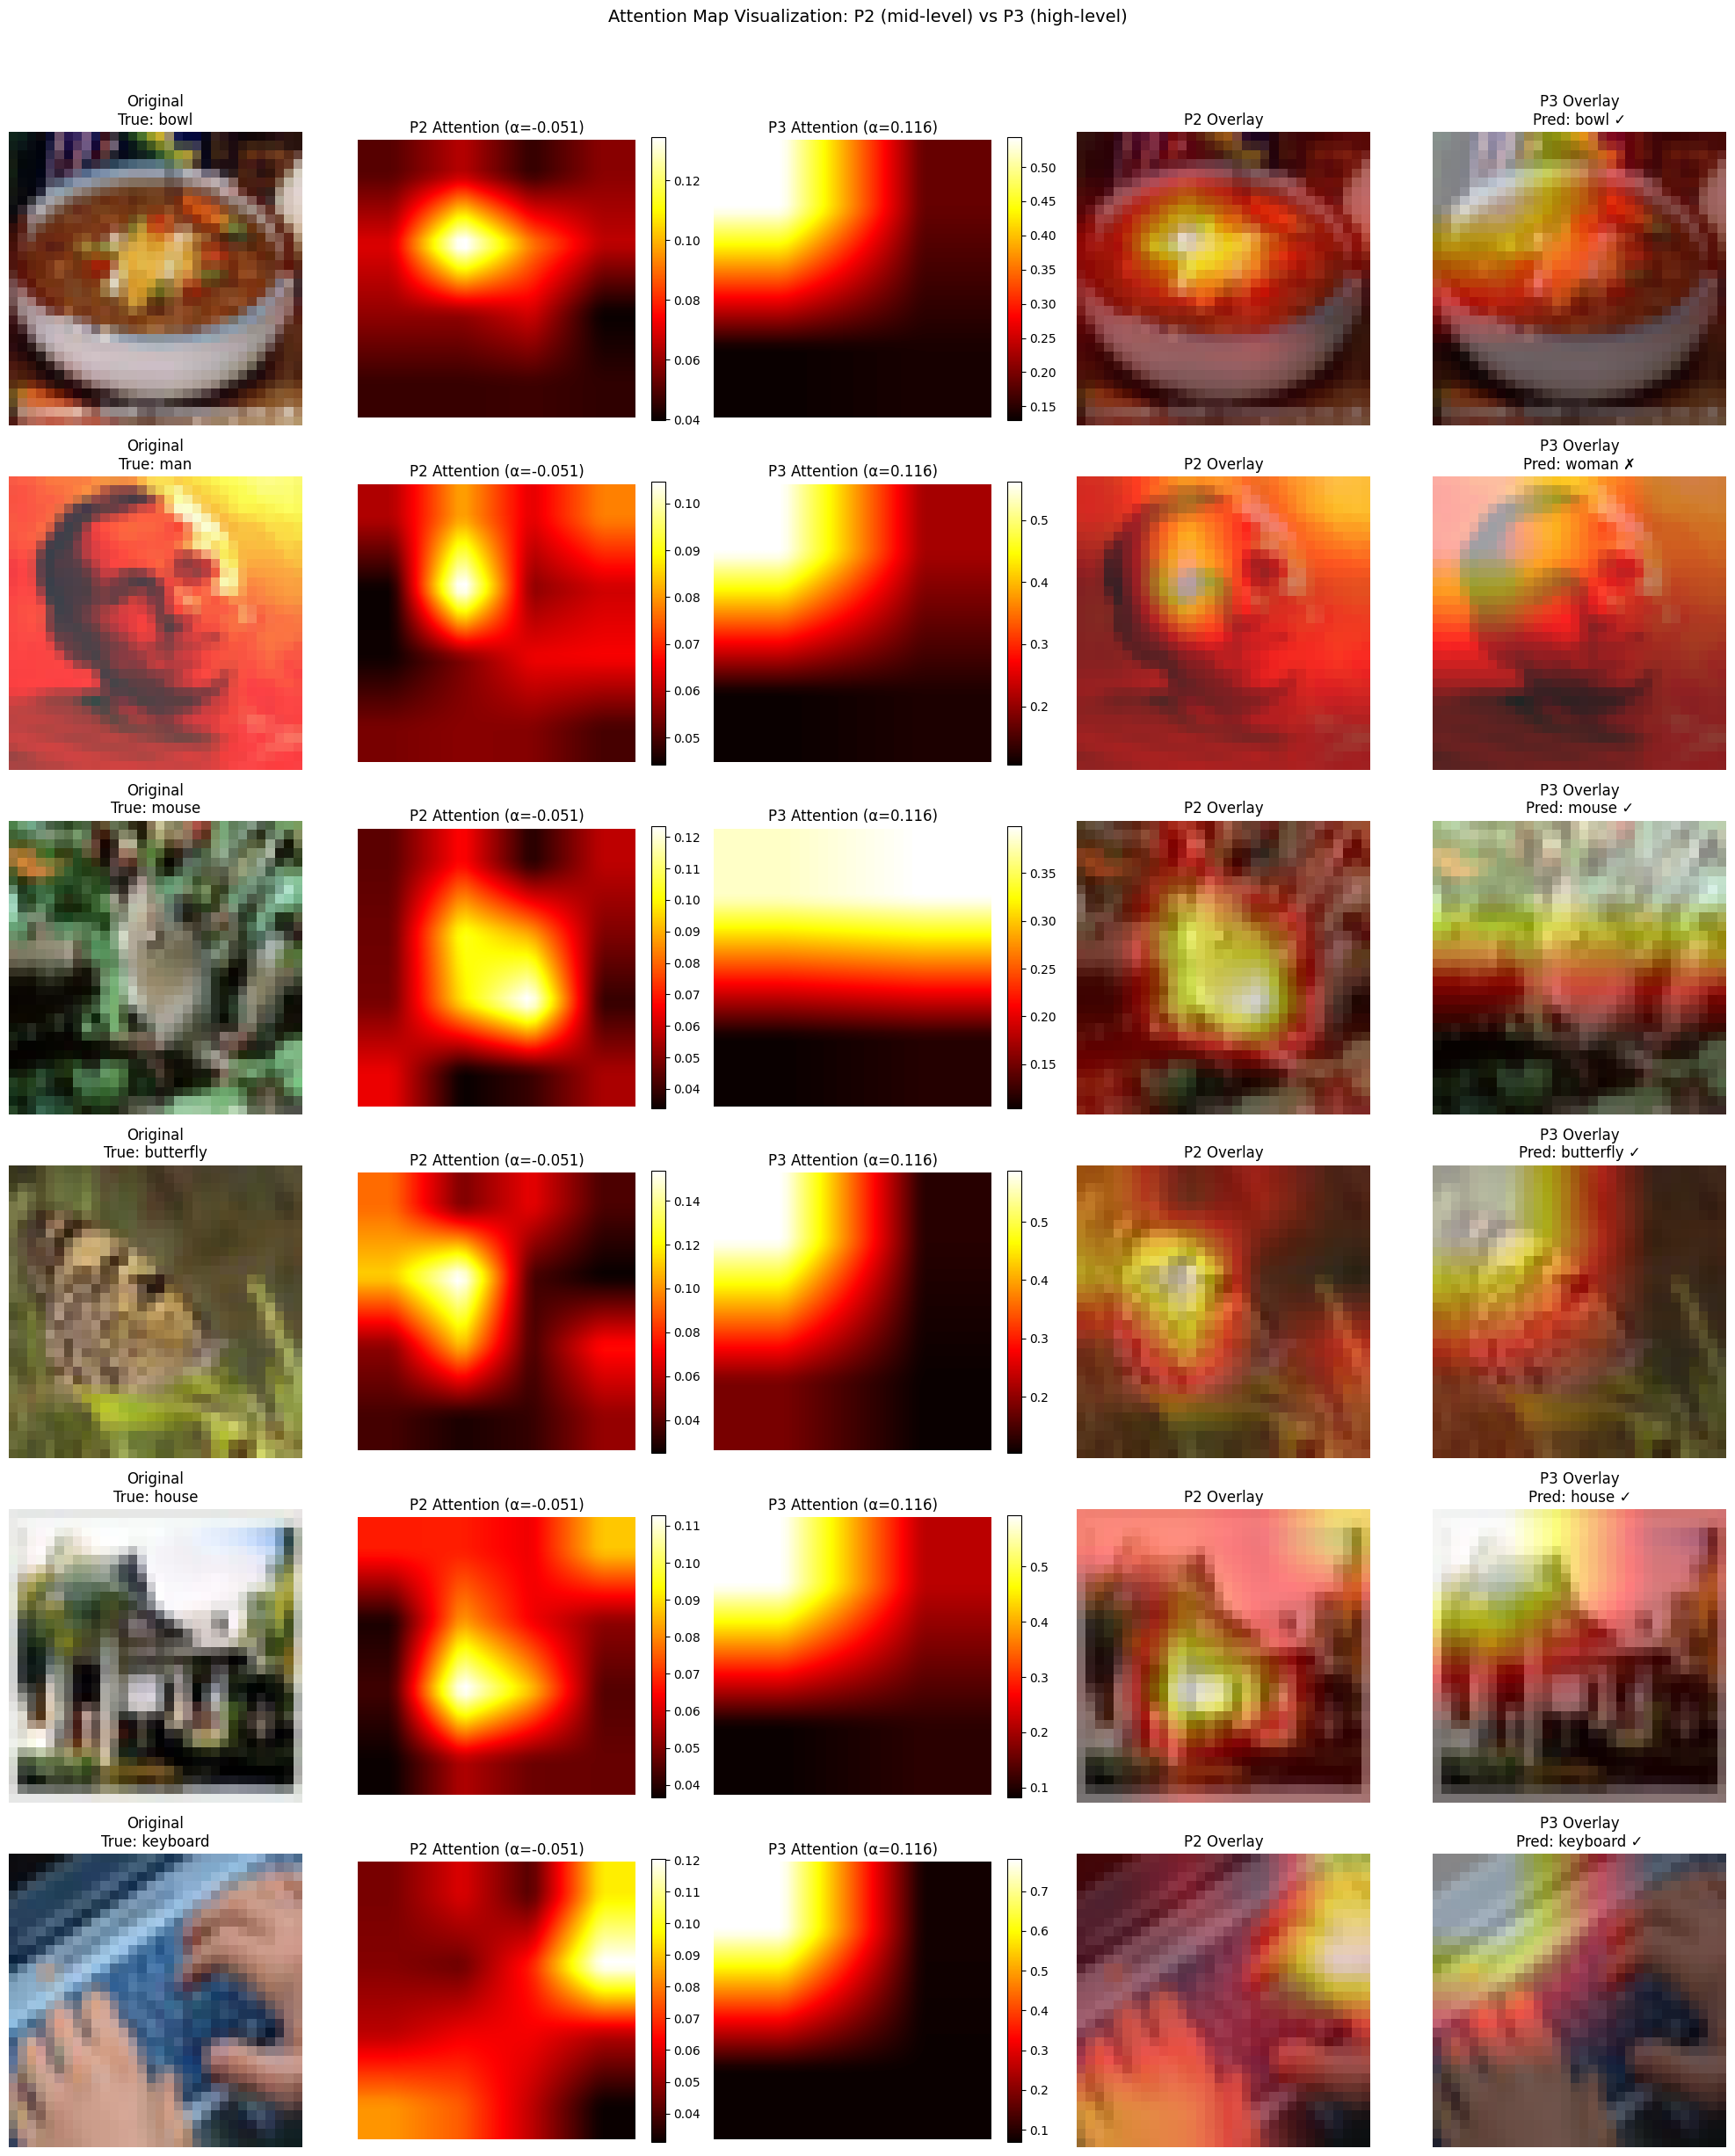


2. Per-head attention breakdown:


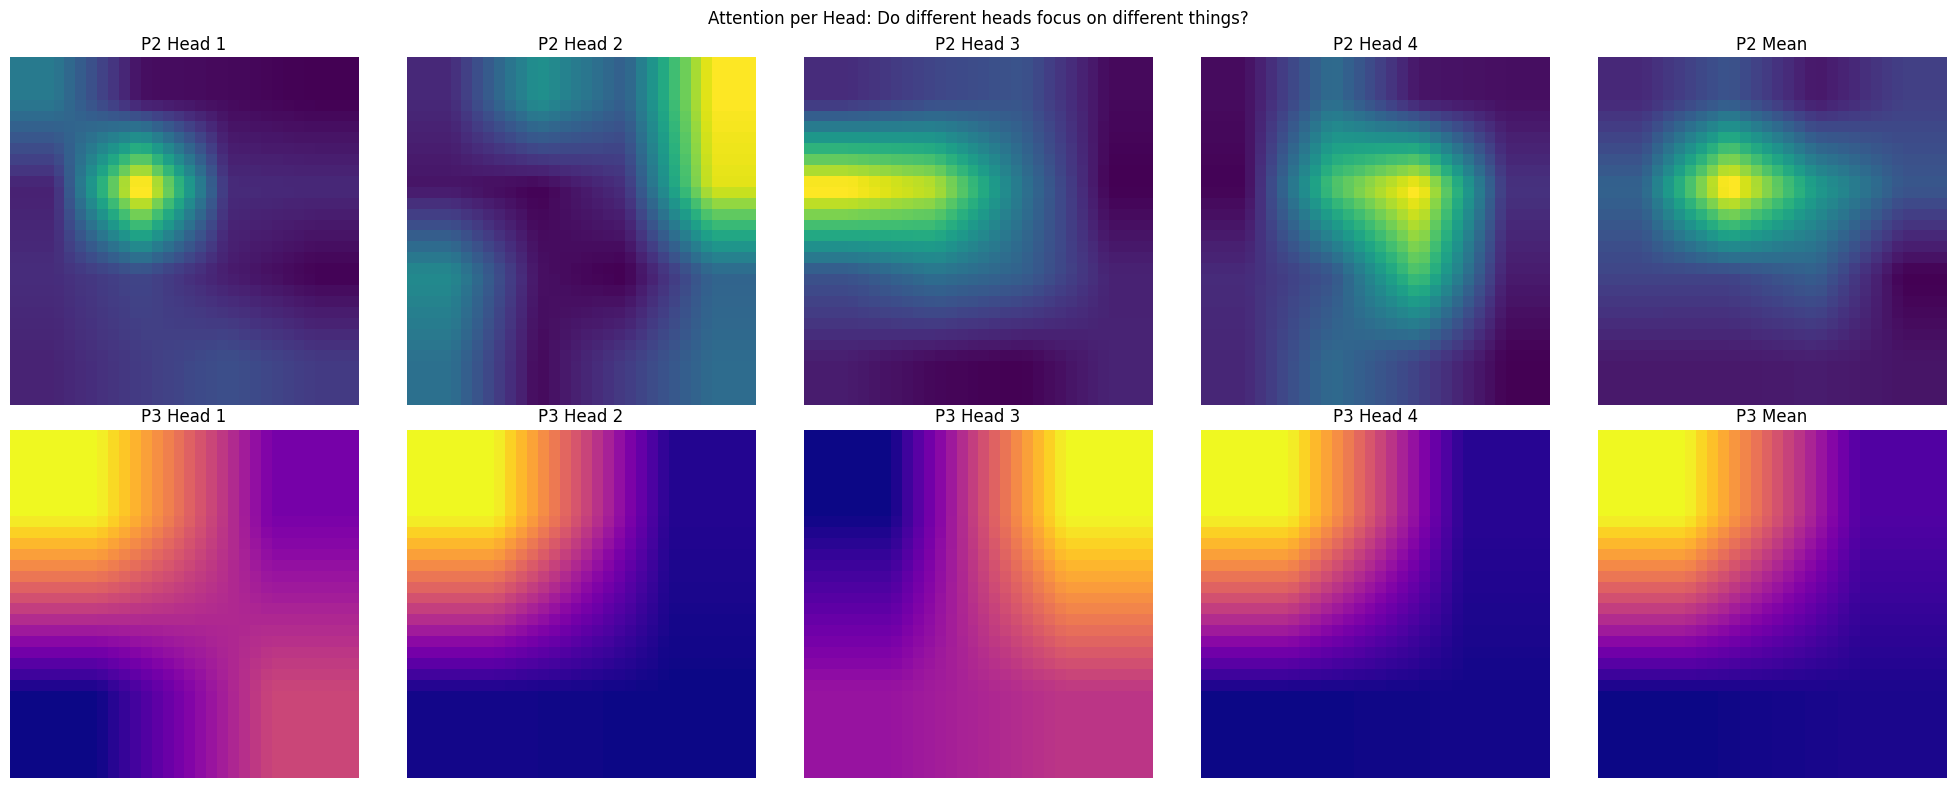


ATTENTION STATISTICS
P2 Attention (after stage2):
  - Feature map shape: (4, 4)
  - Number of tokens: 16
  - Alpha (gate): -0.0510
  - Attention map mean: 0.0625
  - Attention map std: 0.0254

P3 Attention (after stage3):
  - Feature map shape: (2, 2)
  - Number of tokens: 4
  - Alpha (gate): 0.1157
  - Attention map mean: 0.2500
  - Attention map std: 0.2073

HOW TO INTERPRET THESE VISUALIZATIONS

1. ATTENTION HEATMAPS:
   - Bright (yellow/white) = high attention
   - Dark (red/black) = low attention
   - Uniform = attention is spread evenly (less discriminative)
   - Localized = attention focuses on specific regions

2. P2 vs P3 COMPARISON:
   - P2 (mid-level): Should show texture/edge attention
   - P3 (high-level): Should show object/semantic attention
   - If both look similar, the network might not need both

3. PER-HEAD ANALYSIS:
   - Different heads should ideally focus on different things
   - If all heads look the same, fewer heads might suffice
   - Look for: one head on ed

In [ ]:
# ============================================================
# EXPERIMENT A: Attention Map Visualization
# ============================================================
#
# PURPOSE:
# Visualize what the attention blocks are actually "looking at"
# by extracting and plotting attention weights on sample images.
#
# WHAT WE'RE VISUALIZING:
# 1. Original image
# 2. Attention map from P2 (after stage2) - mid-level features
# 3. Attention map from P3 (after stage3) - high-level features
# 4. Overlay of attention on original image
#
# HOW IT WORKS:
# - We hook into the MHSA layers to capture attention weights
# - Attention shape: (B, num_heads, L, L) where L = H*W tokens
# - We average over heads and take the attention FROM the [CLS] token
#   or average attention received by each token
# - Reshape back to spatial dimensions and overlay on image
#
# INTERPRETATION:
# - Bright regions = high attention (model focuses here)
# - Dark regions = low attention (model ignores these)
# - Compare P2 vs P3: P2 should show broader/texture attention,
#   P3 should show more semantic/object-focused attention
# ============================================================

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image

# -----------------------
# Modified Attention Block that stores attention weights
# -----------------------
class GatedMHSA2D_WithAttnWeights(nn.Module):
    """
    Same as GatedMHSA2D but stores attention weights for visualization.
    """
    def __init__(self, C, num_heads=4, attn_dropout=0.0):
        super().__init__()
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads,
                                          dropout=attn_dropout, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.attn_weights = None  # will store attention weights
        self.feat_shape = None    # will store (H, W) for reshaping

    def forward(self, x):
        B, C, H, W = x.shape
        self.feat_shape = (H, W)

        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        t = self.norm(tokens)

        # need_weights=True to get attention weights
        out, weights = self.attn(t, t, t, need_weights=True, average_attn_weights=False)
        self.attn_weights = weights.detach()  # (B, num_heads, L, L)

        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)
        return x + self.alpha * out


def build_model_for_visualization():
    """
    Build model with attention blocks that capture weights.
    Load the trained checkpoint from Experiment A.
    """
    from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)

    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 100)

    # Use the visualization-enabled attention blocks
    attn_p2 = GatedMHSA2D_WithAttnWeights(C=192, num_heads=4)
    attn_p3 = GatedMHSA2D_WithAttnWeights(C=384, num_heads=4)

    new_features = nn.Sequential(
        model.features[0],
        model.features[1],
        model.features[2],
        model.features[3],
        attn_p2,
        model.features[4],
        model.features[5],
        attn_p3,
        model.features[6],
        model.features[7],
    )
    model.features = new_features

    return model, attn_p2, attn_p3


def get_attention_map(attn_weights, feat_shape, mode='mean'):
    """
    Convert attention weights to a spatial attention map.

    Args:
        attn_weights: (B, num_heads, L, L) attention matrix
        feat_shape: (H, W) spatial dimensions
        mode: how to aggregate attention
            - 'mean': average attention each token receives (column mean)
            - 'cls': attention from first token (if using CLS token)
            - 'max': max attention each token receives

    Returns:
        attn_map: (B, H, W) spatial attention map
    """
    B, num_heads, L, L2 = attn_weights.shape
    H, W = feat_shape

    # Average over heads
    attn = attn_weights.mean(dim=1)  # (B, L, L)

    if mode == 'mean':
        # Average attention received by each token (column-wise mean)
        attn_map = attn.mean(dim=1)  # (B, L)
    elif mode == 'max':
        # Max attention received
        attn_map = attn.max(dim=1)[0]  # (B, L)
    elif mode == 'cls':
        # Attention from first token
        attn_map = attn[:, 0, :]  # (B, L)
    else:
        raise ValueError(f"Unknown mode: {mode}")

    # Reshape to spatial dimensions
    attn_map = attn_map.reshape(B, H, W)

    return attn_map


def visualize_attention_on_images(model, attn_p2, attn_p3, images, labels, class_names,
                                   num_images=6, save_path="attention_maps.png"):
    """
    Visualize attention maps on a batch of images.

    Shows for each image:
    1. Original image
    2. P2 attention map (heatmap)
    3. P3 attention map (heatmap)
    4. P2 attention overlay on image
    5. P3 attention overlay on image
    6. Prediction info
    """
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        images_dev = images[:num_images].to(device)
        logits = model(images_dev)
        preds = logits.argmax(dim=1).cpu()

    # Get attention maps
    attn_map_p2 = get_attention_map(attn_p2.attn_weights, attn_p2.feat_shape, mode='mean')
    attn_map_p3 = get_attention_map(attn_p3.attn_weights, attn_p3.feat_shape, mode='mean')

    # Convert to numpy
    attn_map_p2 = attn_map_p2.cpu().numpy()
    attn_map_p3 = attn_map_p3.cpu().numpy()

    # Denormalize images for display
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])

    fig, axes = plt.subplots(num_images, 5, figsize=(20, 4 * num_images))

    for i in range(num_images):
        # Original image
        img = images[i].numpy().transpose(1, 2, 0)
        img = img * std + mean
        img = np.clip(img, 0, 1)

        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        correct = "✓" if labels[i] == preds[i] else "✗"

        # Column 0: Original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original\nTrue: {true_label}")
        axes[i, 0].axis('off')

        # Column 1: P2 attention heatmap
        attn_p2_resized = np.array(Image.fromarray(attn_map_p2[i]).resize((32, 32), Image.BILINEAR))
        im1 = axes[i, 1].imshow(attn_p2_resized, cmap='hot', interpolation='bilinear')
        axes[i, 1].set_title(f"P2 Attention (α={attn_p2.alpha.item():.3f})")
        axes[i, 1].axis('off')
        plt.colorbar(im1, ax=axes[i, 1], fraction=0.046)

        # Column 2: P3 attention heatmap
        attn_p3_resized = np.array(Image.fromarray(attn_map_p3[i]).resize((32, 32), Image.BILINEAR))
        im2 = axes[i, 2].imshow(attn_p3_resized, cmap='hot', interpolation='bilinear')
        axes[i, 2].set_title(f"P3 Attention (α={attn_p3.alpha.item():.3f})")
        axes[i, 2].axis('off')
        plt.colorbar(im2, ax=axes[i, 2], fraction=0.046)

        # Column 3: P2 overlay
        attn_p2_norm = (attn_p2_resized - attn_p2_resized.min()) / (attn_p2_resized.max() - attn_p2_resized.min() + 1e-8)
        overlay_p2 = img * 0.5 + plt.cm.hot(attn_p2_norm)[:, :, :3] * 0.5
        axes[i, 3].imshow(overlay_p2)
        axes[i, 3].set_title("P2 Overlay")
        axes[i, 3].axis('off')

        # Column 4: P3 overlay
        attn_p3_norm = (attn_p3_resized - attn_p3_resized.min()) / (attn_p3_resized.max() - attn_p3_resized.min() + 1e-8)
        overlay_p3 = img * 0.5 + plt.cm.hot(attn_p3_norm)[:, :, :3] * 0.5
        axes[i, 4].imshow(overlay_p3)
        axes[i, 4].set_title(f"P3 Overlay\nPred: {pred_label} {correct}")
        axes[i, 4].axis('off')

    plt.suptitle("Attention Map Visualization: P2 (mid-level) vs P3 (high-level)", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    return attn_map_p2, attn_map_p3


def visualize_attention_heads(attn_p2, attn_p3, image_idx=0, save_path="attention_heads.png"):
    """
    Visualize attention from each head separately.
    Shows how different heads might focus on different aspects.
    """
    # Get attention weights for single image
    weights_p2 = attn_p2.attn_weights[image_idx].cpu().numpy()  # (num_heads, L, L)
    weights_p3 = attn_p3.attn_weights[image_idx].cpu().numpy()

    num_heads = weights_p2.shape[0]
    H_p2, W_p2 = attn_p2.feat_shape
    H_p3, W_p3 = attn_p3.feat_shape

    fig, axes = plt.subplots(2, num_heads + 1, figsize=(4 * (num_heads + 1), 8))

    # P2 heads
    for h in range(num_heads):
        attn_h = weights_p2[h].mean(axis=0).reshape(H_p2, W_p2)  # mean attention received
        attn_h_resized = np.array(Image.fromarray(attn_h).resize((32, 32), Image.BILINEAR))
        axes[0, h].imshow(attn_h_resized, cmap='viridis')
        axes[0, h].set_title(f"P2 Head {h+1}")
        axes[0, h].axis('off')

    # P2 mean
    attn_mean_p2 = weights_p2.mean(axis=0).mean(axis=0).reshape(H_p2, W_p2)
    attn_mean_p2_resized = np.array(Image.fromarray(attn_mean_p2).resize((32, 32), Image.BILINEAR))
    axes[0, num_heads].imshow(attn_mean_p2_resized, cmap='viridis')
    axes[0, num_heads].set_title("P2 Mean")
    axes[0, num_heads].axis('off')

    # P3 heads
    for h in range(num_heads):
        attn_h = weights_p3[h].mean(axis=0).reshape(H_p3, W_p3)
        attn_h_resized = np.array(Image.fromarray(attn_h).resize((32, 32), Image.BILINEAR))
        axes[1, h].imshow(attn_h_resized, cmap='plasma')
        axes[1, h].set_title(f"P3 Head {h+1}")
        axes[1, h].axis('off')

    # P3 mean
    attn_mean_p3 = weights_p3.mean(axis=0).mean(axis=0).reshape(H_p3, W_p3)
    attn_mean_p3_resized = np.array(Image.fromarray(attn_mean_p3).resize((32, 32), Image.BILINEAR))
    axes[1, num_heads].imshow(attn_mean_p3_resized, cmap='plasma')
    axes[1, num_heads].set_title("P3 Mean")
    axes[1, num_heads].axis('off')

    plt.suptitle("Attention per Head: Do different heads focus on different things?", fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


# -----------------------
# Run Visualization
# -----------------------
print("="*70)
print("Loading model and visualizing attention maps...")
print("="*70)

# Build model with visualization-enabled attention
vis_model, vis_attn_p2, vis_attn_p3 = build_model_for_visualization()
vis_model = vis_model.to(DEVICE)

# Load trained weights from Experiment A
checkpoint_path = "exp_a_dual_attn_best.pth"
try:
    state_dict = torch.load(checkpoint_path, map_location=DEVICE)
    vis_model.load_state_dict(state_dict)
    print(f"Loaded checkpoint from {checkpoint_path}")
except FileNotFoundError:
    print(f"Checkpoint {checkpoint_path} not found. Using untrained model for demo.")

# Get CIFAR-100 class names
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Get sample images from test set
test_tf_vis = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])
test_ds_vis = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf_vis)

# Sample diverse images (different classes)
np.random.seed(42)
sample_indices = np.random.choice(len(test_ds_vis), size=8, replace=False)
sample_images = torch.stack([test_ds_vis[i][0] for i in sample_indices])
sample_labels = torch.tensor([test_ds_vis[i][1] for i in sample_indices])

# Visualize attention maps
print("\n1. Attention maps on sample images:")
attn_p2_maps, attn_p3_maps = visualize_attention_on_images(
    vis_model, vis_attn_p2, vis_attn_p3,
    sample_images, sample_labels, cifar100_classes,
    num_images=6,
    save_path="exp_a_attention_maps.png"
)

# Visualize per-head attention
print("\n2. Per-head attention breakdown:")
visualize_attention_heads(
    vis_attn_p2, vis_attn_p3,
    image_idx=0,
    save_path="exp_a_attention_heads.png"
)

# -----------------------
# Attention Statistics
# -----------------------
print("\n" + "="*70)
print("ATTENTION STATISTICS")
print("="*70)
print(f"P2 Attention (after stage2):")
print(f"  - Feature map shape: {vis_attn_p2.feat_shape}")
print(f"  - Number of tokens: {vis_attn_p2.feat_shape[0] * vis_attn_p2.feat_shape[1]}")
print(f"  - Alpha (gate): {vis_attn_p2.alpha.item():.4f}")
print(f"  - Attention map mean: {attn_p2_maps.mean():.4f}")
print(f"  - Attention map std: {attn_p2_maps.std():.4f}")

print(f"\nP3 Attention (after stage3):")
print(f"  - Feature map shape: {vis_attn_p3.feat_shape}")
print(f"  - Number of tokens: {vis_attn_p3.feat_shape[0] * vis_attn_p3.feat_shape[1]}")
print(f"  - Alpha (gate): {vis_attn_p3.alpha.item():.4f}")
print(f"  - Attention map mean: {attn_p3_maps.mean():.4f}")
print(f"  - Attention map std: {attn_p3_maps.std():.4f}")

# -----------------------
# Interpretation Guide
# -----------------------
print("\n" + "="*70)
print("HOW TO INTERPRET THESE VISUALIZATIONS")
print("="*70)
print("""
1. ATTENTION HEATMAPS:
   - Bright (yellow/white) = high attention
   - Dark (red/black) = low attention
   - Uniform = attention is spread evenly (less discriminative)
   - Localized = attention focuses on specific regions

2. P2 vs P3 COMPARISON:
   - P2 (mid-level): Should show texture/edge attention
   - P3 (high-level): Should show object/semantic attention
   - If both look similar, the network might not need both

3. PER-HEAD ANALYSIS:
   - Different heads should ideally focus on different things
   - If all heads look the same, fewer heads might suffice
   - Look for: one head on edges, one on center, one on texture, etc.

4. ALPHA VALUES:
   - Higher alpha = network relies more on attention
   - If alpha ≈ 0, attention contributes little (might be unnecessary)
   - Compare P2 vs P3 alpha to see which layer benefits more

5. PREDICTIONS:
   - Check if high attention regions correspond to the object
   - Incorrect predictions: does attention focus on wrong areas?
""")

In [ ]:
# ============================================================
# EXPERIMENT B: Attention Head Count Ablation
# ============================================================
#
# MOTIVATION:
# In Experiment A, we used num_heads=4 for both attention blocks.
# The number of heads controls how the attention is factorized:
# - Fewer heads (1-2): Coarser attention, fewer parameters, might miss fine details
# - More heads (8+): Finer attention, more parameters, might overfit on small data
#
# HYPOTHESIS:
# - CIFAR images are 32x32, so feature maps are small (8x8 at P2, 4x4 at P3)
# - With only 16-64 tokens, we might not need many heads
# - Fewer heads might actually work better and reduce overfitting
#
# EXPERIMENT DESIGN:
# We test num_heads ∈ {1, 2, 4, 8} using the best setup from Exp A:
# - Dual attention (P2 + P3)
# - Phase 1: frozen backbone (5 epochs)
# - Phase 2: full unfreeze (15 epochs)
#
# WHAT WE'RE MEASURING:
# - Best test accuracy for each head count
# - Training dynamics (convergence speed, overfitting)
# - Final alpha values (does the network use attention differently?)
#
# EXPECTED OUTCOMES:
# - If 1-2 heads work best: attention on CIFAR is simple, don't need fine-grained
# - If 4 heads is optimal: current setup is good
# - If 8 heads work best: model can leverage more complex attention patterns
# ============================================================

import os, time, random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import matplotlib.pyplot as plt

# -----------------------
# Config (same as Experiment A)
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 20
WARMUP_EPOCHS = 5
BATCH_TRAIN = 128
BATCH_TEST = 256
NUM_WORKERS = 2
LR_HEAD_ATTN = 5e-4
LR_BACKBONE_SMALL = 5e-5
WD = 0.05

def set_seed(seed=0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# -----------------------
# Data
# -----------------------
cifar_mean = (0.5071, 0.4867, 0.4408)
cifar_std = (0.2675, 0.2565, 0.2761)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

train_ds = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -----------------------
# Gated MHSA Block (same as before)
# -----------------------
class GatedMHSA2D(nn.Module):
    """
    Gated Multi-Head Self-Attention for 2D feature maps.
    Now with configurable num_heads for ablation study.

    Note: embed_dim (C) must be divisible by num_heads.
    - P2: C=192, divisible by 1,2,4,8 ✓
    - P3: C=384, divisible by 1,2,4,8 ✓
    """
    def __init__(self, C, num_heads=4, attn_dropout=0.0):
        super().__init__()
        assert C % num_heads == 0, f"C={C} must be divisible by num_heads={num_heads}"
        self.num_heads = num_heads
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads,
                                          dropout=attn_dropout, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        t = self.norm(tokens)
        out, _ = self.attn(t, t, t, need_weights=False)
        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)
        return x + self.alpha * out

# -----------------------
# Model Builder with configurable num_heads
# -----------------------
def build_model_dual_attention(num_heads=4):
    """
    Build ConvNeXt-Tiny with dual attention blocks.
    num_heads is applied to BOTH P2 and P3 attention blocks.
    """
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)

    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 100)

    attn_p2 = GatedMHSA2D(C=192, num_heads=num_heads)
    attn_p3 = GatedMHSA2D(C=384, num_heads=num_heads)

    new_features = nn.Sequential(
        model.features[0],
        model.features[1],
        model.features[2],
        model.features[3],
        attn_p2,
        model.features[4],
        model.features[5],
        attn_p3,
        model.features[6],
        model.features[7],
    )
    model.features = new_features

    # Count attention parameters
    attn_params = sum(p.numel() for p in attn_p2.parameters()) + sum(p.numel() for p in attn_p3.parameters())

    return model, attn_p2, attn_p3, attn_params

# -----------------------
# Freeze/Unfreeze (same as Exp A)
# -----------------------
def set_requires_grad(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

def freeze_backbone_only(model, attn_p2, attn_p3):
    set_requires_grad(model, False)
    set_requires_grad(attn_p2, True)
    set_requires_grad(attn_p3, True)
    set_requires_grad(model.classifier, True)

def unfreeze_all(model):
    set_requires_grad(model, True)

# -----------------------
# Optimizers (same as Exp A)
# -----------------------
def make_opt_phase1(model, attn_p2, attn_p3):
    params = list(attn_p2.parameters()) + list(attn_p3.parameters()) + list(model.classifier.parameters())
    return torch.optim.AdamW(params, lr=LR_HEAD_ATTN, weight_decay=WD)

def make_opt_phase2(model, attn_p2, attn_p3):
    attn_ids = {id(p) for p in attn_p2.parameters()} | {id(p) for p in attn_p3.parameters()}
    backbone = [p for n, p in model.named_parameters()
                if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]

    return torch.optim.AdamW([
        {"params": backbone, "lr": LR_BACKBONE_SMALL},
        {"params": attn_p2.parameters(), "lr": LR_HEAD_ATTN},
        {"params": attn_p3.parameters(), "lr": LR_HEAD_ATTN},
        {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
    ], weight_decay=WD)

# -----------------------
# Train/Eval (same as Exp A)
# -----------------------
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss_sum += criterion(logits, y).item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(model, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

# -----------------------
# Run single experiment with given num_heads
# -----------------------
def run_head_experiment(num_heads, seed=0):
    """
    Train dual-attention model with specified number of heads.
    Returns logs and best accuracy.
    """
    set_seed(seed)
    model, attn_p2, attn_p3, attn_params = build_model_dual_attention(num_heads=num_heads)
    model = model.to(DEVICE)

    print(f"\nAttention parameters: {attn_params:,} (num_heads={num_heads})")

    freeze_backbone_only(model, attn_p2, attn_p3)
    opt = make_opt_phase1(model, attn_p2, attn_p3)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

    logs = []
    best_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        if epoch == WARMUP_EPOCHS + 1:
            unfreeze_all(model)
            opt = make_opt_phase2(model, attn_p2, attn_p3)
            sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

        tr_loss, tr_acc = train_one_epoch(model, opt)
        te_loss, te_acc = evaluate(model)
        sch.step()

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), f"exp_b_heads{num_heads}_best.pth")

        logs.append({
            "epoch": epoch,
            "train_acc": tr_acc,
            "test_acc": te_acc,
            "train_loss": tr_loss,
            "test_loss": te_loss,
            "alpha_p2": attn_p2.alpha.item(),
            "alpha_p3": attn_p3.alpha.item(),
        })

        print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | α_p2 {attn_p2.alpha.item():.4f} | α_p3 {attn_p3.alpha.item():.4f}")

    return {
        "num_heads": num_heads,
        "attn_params": attn_params,
        "best_acc": best_acc,
        "final_alpha_p2": attn_p2.alpha.item(),
        "final_alpha_p3": attn_p3.alpha.item(),
        "logs": logs,
    }

# -----------------------
# Run all head configurations
# -----------------------
HEAD_CONFIGS = [1, 2, 4, 8]

print("="*70)
print("EXPERIMENT B: Attention Head Count Ablation")
print("="*70)
print(f"Testing num_heads ∈ {HEAD_CONFIGS}")
print(f"Using dual attention (P2 + P3) with full unfreeze after warmup")
print("="*70)

results_exp_b = []

for num_heads in HEAD_CONFIGS:
    print("\n" + "="*70)
    print(f"Running with num_heads = {num_heads}")
    print("="*70)

    result = run_head_experiment(num_heads, seed=0)
    results_exp_b.append(result)

    print(f"\n>>> num_heads={num_heads} Best Accuracy: {result['best_acc']*100:.2f}%")

# -----------------------
# Summary
# -----------------------
print("\n" + "="*70)
print("EXPERIMENT B SUMMARY")
print("="*70)
print(f"{'Heads':<8} {'Params':<12} {'Best Acc':<12} {'α_P2':<10} {'α_P3':<10}")
print("-"*52)
for r in results_exp_b:
    print(f"{r['num_heads']:<8} {r['attn_params']:<12,} {r['best_acc']*100:<12.2f} {r['final_alpha_p2']:<10.4f} {r['final_alpha_p3']:<10.4f}")
print("="*70)

best_result = max(results_exp_b, key=lambda x: x['best_acc'])
print(f"\nBest configuration: num_heads={best_result['num_heads']} with {best_result['best_acc']*100:.2f}%")

EXPERIMENT B: Attention Head Count Ablation
Testing num_heads ∈ [1, 2, 4, 8]
Using dual attention (P2 + P3) with full unfreeze after warmup

Running with num_heads = 1

Attention parameters: 740,738 (num_heads=1)
Epoch 01 | train 0.4426 | test 0.5674 | best 0.5674 | α_p2 -0.0478 | α_p3 0.0988
Epoch 02 | train 0.5933 | test 0.6129 | best 0.6129 | α_p2 -0.0578 | α_p3 0.1094
Epoch 03 | train 0.6330 | test 0.6321 | best 0.6321 | α_p2 -0.0663 | α_p3 0.1238
Epoch 04 | train 0.6571 | test 0.6439 | best 0.6439 | α_p2 -0.0706 | α_p3 0.1334
Epoch 05 | train 0.6709 | test 0.6474 | best 0.6474 | α_p2 -0.0732 | α_p3 0.1380
Epoch 06 | train 0.6722 | test 0.6807 | best 0.6807 | α_p2 -0.0534 | α_p3 0.1112
Epoch 07 | train 0.7299 | test 0.7056 | best 0.7056 | α_p2 -0.0452 | α_p3 0.0965
Epoch 08 | train 0.7712 | test 0.7206 | best 0.7206 | α_p2 -0.0408 | α_p3 0.0880
Epoch 09 | train 0.8045 | test 0.7304 | best 0.7304 | α_p2 -0.0402 | α_p3 0.0864
Epoch 10 | train 0.8352 | test 0.7418 | best 0.7418 | α_p2

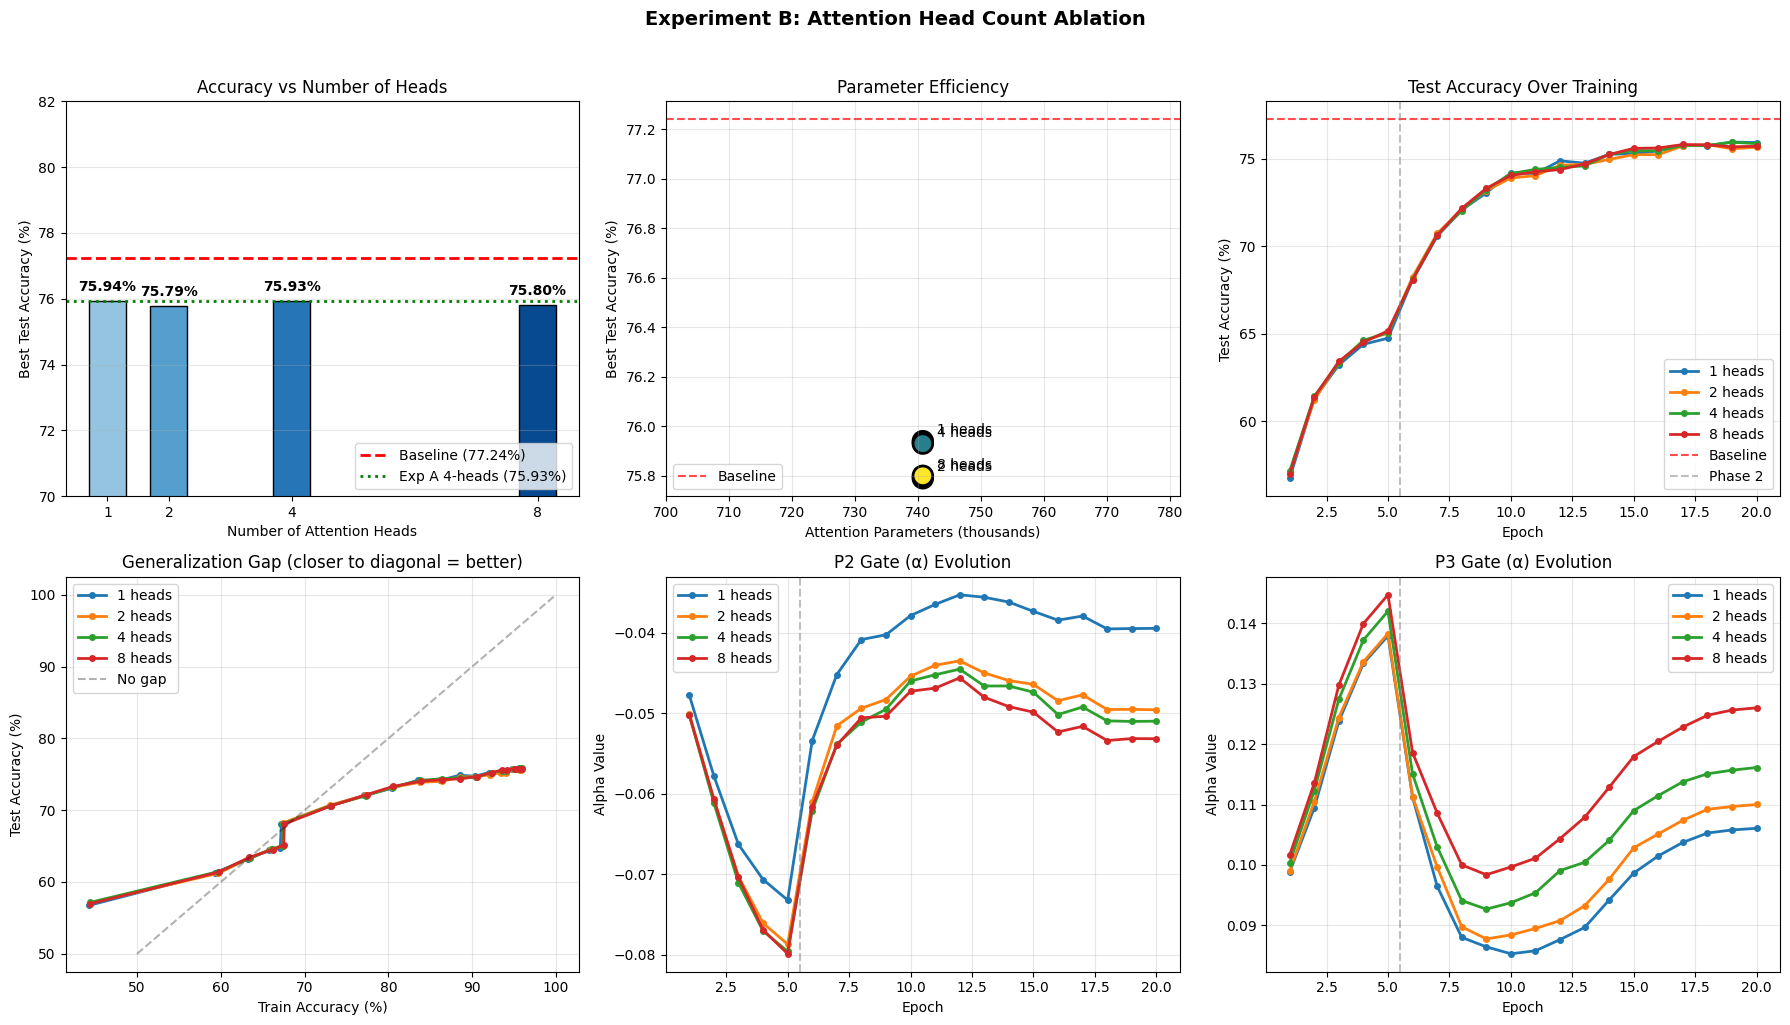


EXPERIMENT B: DETAILED RESULTS

Heads    Attn Params     Best Acc     Final α_P2   Final α_P3   Gap to Base 
---------------------------------------------------------------------------
1        740,738         75.94        -0.0394      0.1061       -1.30%
2        740,738         75.79        -0.0496      0.1100       -1.45%
4        740,738         75.93        -0.0510      0.1161       -1.31%
8        740,738         75.80        -0.0532      0.1260       -1.44%

KEY FINDINGS

1. BEST CONFIGURATION: 1 heads with 75.94% accuracy
   - Gap to baseline: -1.30%

2. WORST CONFIGURATION: 2 heads with 75.79% accuracy

3. PARAMETER EFFICIENCY:
   - 1 head:  740,738 params
   - 8 heads: 740,738 params
   - Note: MHSA param count doesn't change with heads (same total dimension)

4. OBSERVATIONS:
   - Check if more heads = more overfitting (larger train-test gap)
   - Check if alpha values differ significantly across head counts
   - Check convergence speed differences

INTERPRETATION GUIDE

WH

In [ ]:
# ============================================================
# EXPERIMENT B: Results Visualization
# ============================================================
#
# Comparing different attention head counts:
# 1. Bar chart of best accuracy per head count
# 2. Training curves comparison
# 3. Alpha evolution comparison
# 4. Parameter efficiency analysis
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# Previous results for context
baseline_acc = 0.7724
exp_a_acc = 0.7593  # Dual attention with 4 heads

# -----------------------
# Figure: Comprehensive comparison
# -----------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# -----------------------
# Plot 1: Best accuracy per head count
# -----------------------
heads = [r['num_heads'] for r in results_exp_b]
accs = [r['best_acc'] * 100 for r in results_exp_b]

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(heads)))
bars = axes[0, 0].bar(heads, accs, color=colors, edgecolor='black', width=0.6)
axes[0, 0].axhline(y=baseline_acc * 100, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc*100:.2f}%)')
axes[0, 0].axhline(y=exp_a_acc * 100, color='green', linestyle=':', linewidth=2, label=f'Exp A 4-heads ({exp_a_acc*100:.2f}%)')

for bar, acc in zip(bars, accs):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                    f"{acc:.2f}%", ha='center', fontsize=10, fontweight='bold')

axes[0, 0].set_xlabel("Number of Attention Heads")
axes[0, 0].set_ylabel("Best Test Accuracy (%)")
axes[0, 0].set_title("Accuracy vs Number of Heads")
axes[0, 0].set_xticks(heads)
axes[0, 0].set_ylim(70, 82)
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# -----------------------
# Plot 2: Parameter count vs accuracy (efficiency)
# -----------------------
params = [r['attn_params'] / 1000 for r in results_exp_b]  # in thousands

axes[0, 1].scatter(params, accs, s=200, c=heads, cmap='viridis', edgecolor='black', linewidth=2)
for i, (p, a, h) in enumerate(zip(params, accs, heads)):
    axes[0, 1].annotate(f"{h} heads", (p, a), textcoords="offset points", xytext=(10, 5), fontsize=10)

axes[0, 1].axhline(y=baseline_acc * 100, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[0, 1].set_xlabel("Attention Parameters (thousands)")
axes[0, 1].set_ylabel("Best Test Accuracy (%)")
axes[0, 1].set_title("Parameter Efficiency")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# -----------------------
# Plot 3: Test accuracy curves over epochs
# -----------------------
for r in results_exp_b:
    epochs = [l['epoch'] for l in r['logs']]
    test_acc = [l['test_acc'] * 100 for l in r['logs']]
    axes[0, 2].plot(epochs, test_acc, 'o-', label=f"{r['num_heads']} heads", linewidth=2, markersize=4)

axes[0, 2].axhline(y=baseline_acc * 100, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[0, 2].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.5, label='Phase 2')
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Test Accuracy (%)")
axes[0, 2].set_title("Test Accuracy Over Training")
axes[0, 2].legend(loc='lower right')
axes[0, 2].grid(True, alpha=0.3)

# -----------------------
# Plot 4: Train vs Test accuracy (overfitting check)
# -----------------------
for r in results_exp_b:
    train_acc = [l['train_acc'] * 100 for l in r['logs']]
    test_acc = [l['test_acc'] * 100 for l in r['logs']]
    axes[1, 0].plot(train_acc, test_acc, 'o-', label=f"{r['num_heads']} heads", linewidth=2, markersize=4)

# Diagonal line (perfect generalization)
axes[1, 0].plot([50, 100], [50, 100], 'k--', alpha=0.3, label='No gap')
axes[1, 0].set_xlabel("Train Accuracy (%)")
axes[1, 0].set_ylabel("Test Accuracy (%)")
axes[1, 0].set_title("Generalization Gap (closer to diagonal = better)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# -----------------------
# Plot 5: Alpha P2 evolution
# -----------------------
for r in results_exp_b:
    epochs = [l['epoch'] for l in r['logs']]
    alpha_p2 = [l['alpha_p2'] for l in r['logs']]
    axes[1, 1].plot(epochs, alpha_p2, 'o-', label=f"{r['num_heads']} heads", linewidth=2, markersize=4)

axes[1, 1].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Alpha Value")
axes[1, 1].set_title("P2 Gate (α) Evolution")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# -----------------------
# Plot 6: Alpha P3 evolution
# -----------------------
for r in results_exp_b:
    epochs = [l['epoch'] for l in r['logs']]
    alpha_p3 = [l['alpha_p3'] for l in r['logs']]
    axes[1, 2].plot(epochs, alpha_p3, 'o-', label=f"{r['num_heads']} heads", linewidth=2, markersize=4)

axes[1, 2].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.5)
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel("Alpha Value")
axes[1, 2].set_title("P3 Gate (α) Evolution")
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle("Experiment B: Attention Head Count Ablation", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("exp_b_head_count_results.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# Summary Table
# -----------------------
print("\n" + "="*80)
print("EXPERIMENT B: DETAILED RESULTS")
print("="*80)
print(f"\n{'Heads':<8} {'Attn Params':<15} {'Best Acc':<12} {'Final α_P2':<12} {'Final α_P3':<12} {'Gap to Base':<12}")
print("-"*75)
for r in results_exp_b:
    gap = (r['best_acc'] - baseline_acc) * 100
    print(f"{r['num_heads']:<8} {r['attn_params']:<15,} {r['best_acc']*100:<12.2f} {r['final_alpha_p2']:<12.4f} {r['final_alpha_p3']:<12.4f} {gap:+.2f}%")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

best_heads = max(results_exp_b, key=lambda x: x['best_acc'])
worst_heads = min(results_exp_b, key=lambda x: x['best_acc'])

print(f"""
1. BEST CONFIGURATION: {best_heads['num_heads']} heads with {best_heads['best_acc']*100:.2f}% accuracy
   - Gap to baseline: {(best_heads['best_acc'] - baseline_acc)*100:+.2f}%

2. WORST CONFIGURATION: {worst_heads['num_heads']} heads with {worst_heads['best_acc']*100:.2f}% accuracy

3. PARAMETER EFFICIENCY:
   - 1 head:  {results_exp_b[0]['attn_params']:,} params
   - 8 heads: {results_exp_b[-1]['attn_params']:,} params
   - Note: MHSA param count doesn't change with heads (same total dimension)

4. OBSERVATIONS:
   - Check if more heads = more overfitting (larger train-test gap)
   - Check if alpha values differ significantly across head counts
   - Check convergence speed differences
""")

# -----------------------
# Interpretation Guide
# -----------------------
print("="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("""
WHAT TO LOOK FOR:

1. If 1-2 heads work best:
   → Attention on CIFAR doesn't need fine-grained factorization
   → Simpler attention suffices for small images
   → Consider testing even simpler attention (SE, ECA) in Exp C

2. If 4 heads is optimal:
   → Current setup is already well-tuned
   → No need to change this hyperparameter

3. If 8 heads work best:
   → Model benefits from more expressive attention
   → Could try 16 heads if C allows (C=192 is divisible by 16)
   → But watch for overfitting

4. If all perform similarly:
   → Head count doesn't matter much for this task
   → Focus optimization efforts elsewhere

5. Alpha patterns:
   → If α increases with more heads: model leverages complex attention
   → If α decreases with more heads: model suppresses over-complex attention
   → If α similar across heads: attention contribution is stable
""")

In [ ]:
# ============================================================
# EXPERIMENT C: Alternative Attention Mechanisms
# ============================================================
#
# MOTIVATION:
# Experiment B showed that:
# 1. Head count doesn't matter much (1 head ≈ 8 heads)
# 2. P2 attention has NEGATIVE alpha (network suppresses it)
# 3. Only P3 attention contributes positively
#
# This suggests full MHSA might be overkill. Let's test simpler,
# more parameter-efficient attention mechanisms:
#
# MECHANISMS TO TEST:
#
# 1. SE (Squeeze-and-Excitation):
#    - Channel attention only
#    - Global average pool → FC → ReLU → FC → Sigmoid → scale channels
#    - Very few parameters
#    - Paper: "Squeeze-and-Excitation Networks" (Hu et al., 2018)
#
# 2. ECA (Efficient Channel Attention):
#    - Channel attention with 1D convolution (no FC layers)
#    - Even fewer parameters than SE
#    - Paper: "ECA-Net" (Wang et al., 2020)
#
# 3. CBAM (Convolutional Block Attention Module):
#    - Channel attention + Spatial attention
#    - More expressive than SE but still lighter than MHSA
#    - Paper: "CBAM" (Woo et al., 2018)
#
# 4. Spatial Attention Only:
#    - Just the spatial part of CBAM
#    - Tests if spatial relationships matter without channel reweighting
#
# EXPERIMENT DESIGN:
# - Use P3 position only (since P2 alpha was negative)
# - Compare: SE, ECA, CBAM, Spatial-only, MHSA (1-head baseline)
# - Same training recipe as before (Phase 1 frozen, Phase 2 full)
#
# HYPOTHESIS:
# - SE/ECA might match MHSA with far fewer parameters
# - If spatial attention matters, CBAM should beat SE
# - If channel attention is enough, SE should match CBAM
# ============================================================

import os, time, random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import matplotlib.pyplot as plt
import math

# -----------------------
# Config
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 20
WARMUP_EPOCHS = 5
BATCH_TRAIN = 128
BATCH_TEST = 256
NUM_WORKERS = 2
LR_HEAD_ATTN = 5e-4
LR_BACKBONE_SMALL = 5e-5
WD = 0.05

def set_seed(seed=0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# -----------------------
# Data
# -----------------------
cifar_mean = (0.5071, 0.4867, 0.4408)
cifar_std = (0.2675, 0.2565, 0.2761)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

train_ds = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_tf)
test_ds = datasets.CIFAR100(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ============================================================
# ATTENTION MECHANISM IMPLEMENTATIONS
# ============================================================

class GatedSE(nn.Module):
    """
    Squeeze-and-Excitation with learnable gate.

    Channel attention only:
    1. Global Average Pool: (B,C,H,W) → (B,C,1,1)
    2. FC → ReLU → FC → Sigmoid: (B,C) → (B,C)
    3. Scale channels: x * attention_weights

    With gating: y = x + alpha * (SE(x) - x) = x + alpha * x * (weights - 1)
    Simpler: y = x * (1 + alpha * (weights - 1))

    Parameters: 2 * C * (C // reduction) = 2 * C^2 / reduction
    For C=384, reduction=16: 2 * 384 * 24 = 18,432 params
    """
    def __init__(self, C, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(C, C // reduction, bias=False)
        self.fc2 = nn.Linear(C // reduction, C, bias=False)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape

        # Squeeze: global average pooling
        y = x.mean(dim=(2, 3))  # (B, C)

        # Excitation: FC → ReLU → FC → Sigmoid
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))  # (B, C)

        # Scale with gating
        y = y.view(B, C, 1, 1)
        return x + self.alpha * (x * y - x)  # = x * (1 + alpha * (y - 1))


class GatedECA(nn.Module):
    """
    Efficient Channel Attention with learnable gate.

    Like SE but uses 1D conv instead of FC layers:
    1. Global Average Pool: (B,C,H,W) → (B,C,1,1)
    2. 1D Conv (local channel interaction): (B,1,C) → (B,1,C)
    3. Sigmoid → Scale channels

    Kernel size is adaptive based on channel count.

    Parameters: kernel_size (very few!)
    For C=384, k=5: only 5 params + 1 alpha = 6 params total
    """
    def __init__(self, C, gamma=2, b=1):
        super().__init__()
        # Adaptive kernel size based on channel count
        t = int(abs((math.log2(C) + b) / gamma))
        k = t if t % 2 else t + 1  # ensure odd
        k = max(3, k)  # minimum kernel size 3

        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k//2, bias=False)
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.k = k

    def forward(self, x):
        B, C, H, W = x.shape

        # Squeeze
        y = x.mean(dim=(2, 3))  # (B, C)

        # 1D conv attention
        y = y.unsqueeze(1)  # (B, 1, C)
        y = self.conv(y)     # (B, 1, C)
        y = torch.sigmoid(y.squeeze(1))  # (B, C)

        # Scale with gating
        y = y.view(B, C, 1, 1)
        return x + self.alpha * (x * y - x)


class ChannelAttention(nn.Module):
    """Channel attention module for CBAM (uses both max and avg pool)."""
    def __init__(self, C, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(C, C // reduction, bias=False)
        self.fc2 = nn.Linear(C // reduction, C, bias=False)

    def forward(self, x):
        B, C, H, W = x.shape

        # Both average and max pooling
        avg_pool = x.mean(dim=(2, 3))  # (B, C)
        max_pool = x.amax(dim=(2, 3))  # (B, C)

        # Shared MLP
        avg_out = self.fc2(F.relu(self.fc1(avg_pool)))
        max_out = self.fc2(F.relu(self.fc1(max_pool)))

        return torch.sigmoid(avg_out + max_out).view(B, C, 1, 1)


class SpatialAttention(nn.Module):
    """Spatial attention module for CBAM."""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        # Channel-wise pooling
        avg_out = x.mean(dim=1, keepdim=True)  # (B, 1, H, W)
        max_out = x.amax(dim=1, keepdim=True)  # (B, 1, H, W)

        # Concat and conv
        y = torch.cat([avg_out, max_out], dim=1)  # (B, 2, H, W)
        y = torch.sigmoid(self.conv(y))  # (B, 1, H, W)

        return y


class GatedCBAM(nn.Module):
    """
    Convolutional Block Attention Module with learnable gate.

    Sequential channel + spatial attention:
    1. Channel attention: reweight channels
    2. Spatial attention: reweight spatial locations

    Parameters: SE params + spatial conv
    For C=384, reduction=16, spatial_k=7: ~18,432 + 98 = ~18,530 params
    """
    def __init__(self, C, reduction=16, spatial_kernel=7):
        super().__init__()
        self.channel_attn = ChannelAttention(C, reduction)
        self.spatial_attn = SpatialAttention(spatial_kernel)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        # Channel attention
        ca = self.channel_attn(x)  # (B, C, 1, 1)
        x_ca = x * ca

        # Spatial attention
        sa = self.spatial_attn(x_ca)  # (B, 1, H, W)
        x_sa = x_ca * sa

        # Gated residual
        return x + self.alpha * (x_sa - x)


class GatedSpatialOnly(nn.Module):
    """
    Spatial attention only (no channel attention).
    Tests if spatial relationships alone are useful.

    Parameters: just the spatial conv (~98 params for k=7)
    """
    def __init__(self, kernel_size=7):
        super().__init__()
        self.spatial_attn = SpatialAttention(kernel_size)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        sa = self.spatial_attn(x)  # (B, 1, H, W)
        return x + self.alpha * (x * sa - x)


class GatedMHSA2D(nn.Module):
    """MHSA baseline (1 head) for comparison."""
    def __init__(self, C, num_heads=1):
        super().__init__()
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        t = self.norm(tokens)
        out, _ = self.attn(t, t, t, need_weights=False)
        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)
        return x + self.alpha * out

# ============================================================
# MODEL BUILDER
# ============================================================

def build_model_with_attention(attn_type="MHSA"):
    """
    Build ConvNeXt-Tiny with specified attention at P3 only.
    (P2 attention was negative in Exp B, so we skip it)

    attn_type: "MHSA", "SE", "ECA", "CBAM", "Spatial"
    """
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)

    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 100)

    # Create attention block based on type
    C = 384  # P3 channel dimension

    if attn_type == "MHSA":
        attn = GatedMHSA2D(C, num_heads=1)
    elif attn_type == "SE":
        attn = GatedSE(C, reduction=16)
    elif attn_type == "ECA":
        attn = GatedECA(C)
    elif attn_type == "CBAM":
        attn = GatedCBAM(C, reduction=16, spatial_kernel=7)
    elif attn_type == "Spatial":
        attn = GatedSpatialOnly(kernel_size=7)
    else:
        raise ValueError(f"Unknown attention type: {attn_type}")

    # Insert attention at P3 only (after stage3, before down3)
    new_features = nn.Sequential(
        model.features[0],  # stem
        model.features[1],  # stage1
        model.features[2],  # down1
        model.features[3],  # stage2
        model.features[4],  # down2
        model.features[5],  # stage3
        attn,               # <-- attention at P3 only
        model.features[6],  # down3
        model.features[7],  # stage4
    )
    model.features = new_features

    # Count attention parameters
    attn_params = sum(p.numel() for p in attn.parameters())

    return model, attn, attn_params

# ============================================================
# TRAINING UTILITIES
# ============================================================

def set_requires_grad(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

def freeze_backbone_only(model, attn):
    set_requires_grad(model, False)
    set_requires_grad(attn, True)
    set_requires_grad(model.classifier, True)

def unfreeze_all(model):
    set_requires_grad(model, True)

def make_opt_phase1(model, attn):
    params = list(attn.parameters()) + list(model.classifier.parameters())
    return torch.optim.AdamW(params, lr=LR_HEAD_ATTN, weight_decay=WD)

def make_opt_phase2(model, attn):
    attn_ids = {id(p) for p in attn.parameters()}
    backbone = [p for n, p in model.named_parameters()
                if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]

    return torch.optim.AdamW([
        {"params": backbone, "lr": LR_BACKBONE_SMALL},
        {"params": attn.parameters(), "lr": LR_HEAD_ATTN},
        {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
    ], weight_decay=WD)

criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss_sum += criterion(logits, y).item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

def train_one_epoch(model, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

# ============================================================
# RUN SINGLE EXPERIMENT
# ============================================================

def run_attention_experiment(attn_type, seed=0):
    """Train model with specified attention type."""
    set_seed(seed)
    model, attn, attn_params = build_model_with_attention(attn_type)
    model = model.to(DEVICE)

    print(f"\n{attn_type} attention parameters: {attn_params:,}")

    freeze_backbone_only(model, attn)
    opt = make_opt_phase1(model, attn)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

    logs = []
    best_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        if epoch == WARMUP_EPOCHS + 1:
            unfreeze_all(model)
            opt = make_opt_phase2(model, attn)
            sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

        tr_loss, tr_acc = train_one_epoch(model, opt)
        te_loss, te_acc = evaluate(model)
        sch.step()

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), f"exp_c_{attn_type.lower()}_best.pth")

        logs.append({
            "epoch": epoch,
            "train_acc": tr_acc,
            "test_acc": te_acc,
            "train_loss": tr_loss,
            "test_loss": te_loss,
            "alpha": attn.alpha.item(),
        })

        print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | α {attn.alpha.item():.4f}")

    return {
        "attn_type": attn_type,
        "attn_params": attn_params,
        "best_acc": best_acc,
        "final_alpha": attn.alpha.item(),
        "logs": logs,
    }

# ============================================================
# RUN ALL ATTENTION TYPES
# ============================================================

ATTENTION_TYPES = ["MHSA", "SE", "ECA", "CBAM", "Spatial"]

print("="*70)
print("EXPERIMENT C: Alternative Attention Mechanisms")
print("="*70)
print(f"Testing: {ATTENTION_TYPES}")
print(f"Position: P3 only (after stage3)")
print(f"Training: Phase 1 frozen (5 ep) + Phase 2 full (15 ep)")
print("="*70)

results_exp_c = []

for attn_type in ATTENTION_TYPES:
    print("\n" + "="*70)
    print(f"Running {attn_type} attention")
    print("="*70)

    result = run_attention_experiment(attn_type, seed=0)
    results_exp_c.append(result)

    print(f"\n>>> {attn_type} Best Accuracy: {result['best_acc']*100:.2f}%")

# ============================================================
# SUMMARY
# ============================================================

print("\n" + "="*70)
print("EXPERIMENT C SUMMARY")
print("="*70)
print(f"{'Type':<12} {'Params':<12} {'Best Acc':<12} {'Final α':<12} {'Gap to Base':<12}")
print("-"*60)

baseline_acc = 0.7724

for r in results_exp_c:
    gap = (r['best_acc'] - baseline_acc) * 100
    print(f"{r['attn_type']:<12} {r['attn_params']:<12,} {r['best_acc']*100:<12.2f} {r['final_alpha']:<12.4f} {gap:+.2f}%")

print("="*70)

best_result = max(results_exp_c, key=lambda x: x['best_acc'])
most_efficient = max(results_exp_c, key=lambda x: x['best_acc'] / (x['attn_params'] + 1))

print(f"\nBest accuracy: {best_result['attn_type']} with {best_result['best_acc']*100:.2f}%")
print(f"Most efficient: {most_efficient['attn_type']} ({most_efficient['attn_params']:,} params)")

EXPERIMENT C: Alternative Attention Mechanisms
Testing: ['MHSA', 'SE', 'ECA', 'CBAM', 'Spatial']
Position: P3 only (after stage3)
Training: Phase 1 frozen (5 ep) + Phase 2 full (15 ep)

Running MHSA attention

MHSA attention parameters: 592,129
Epoch 01 | train 0.4160 | test 0.5347 | best 0.5347 | α -0.1113
Epoch 02 | train 0.5536 | test 0.5783 | best 0.5783 | α -0.1350
Epoch 03 | train 0.5898 | test 0.5896 | best 0.5896 | α -0.1517
Epoch 04 | train 0.6106 | test 0.5999 | best 0.5999 | α -0.1656
Epoch 05 | train 0.6269 | test 0.6020 | best 0.6020 | α -0.1713
Epoch 06 | train 0.6552 | test 0.6851 | best 0.6851 | α -0.1277
Epoch 07 | train 0.7248 | test 0.7072 | best 0.7072 | α -0.1118
Epoch 08 | train 0.7692 | test 0.7151 | best 0.7151 | α -0.1018
Epoch 09 | train 0.8066 | test 0.7307 | best 0.7307 | α -0.0981
Epoch 10 | train 0.8362 | test 0.7340 | best 0.7340 | α -0.0980
Epoch 11 | train 0.8610 | test 0.7384 | best 0.7384 | α -0.0968
Epoch 12 | train 0.8872 | test 0.7434 | best 0.7434

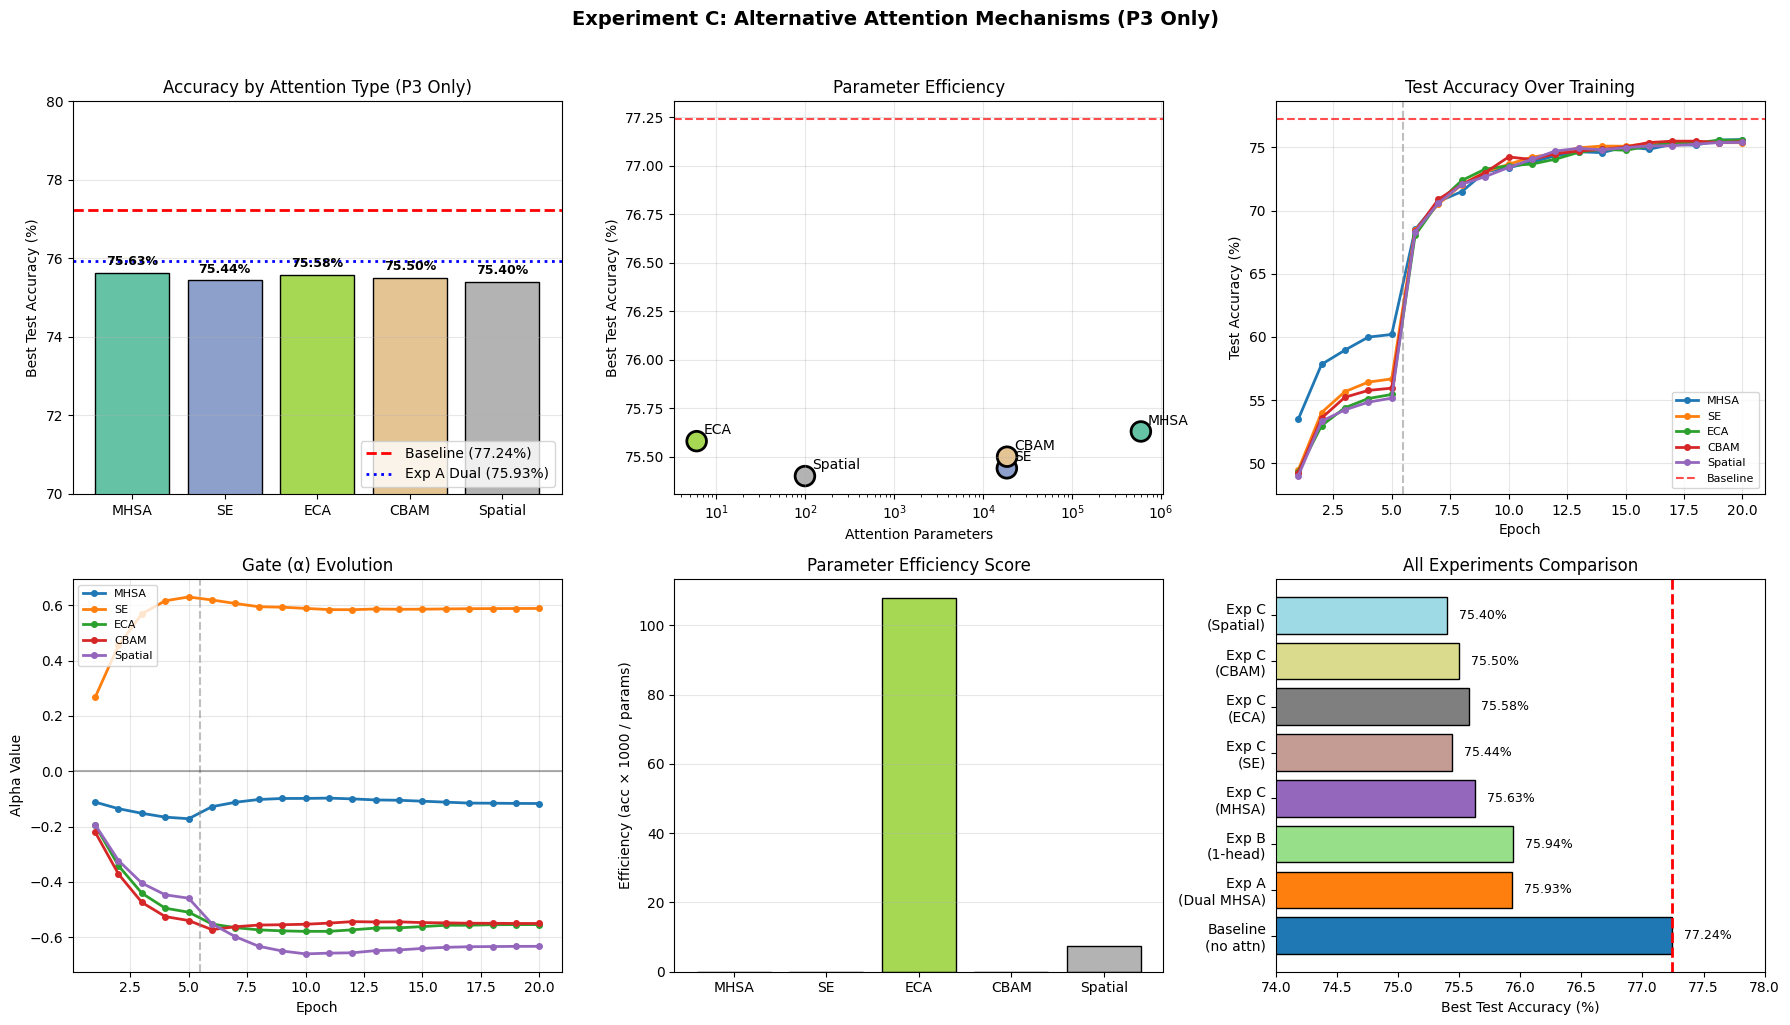


EXPERIMENT C: FINAL ANALYSIS

PARAMETER COUNTS:
- MHSA (1-head): 592,129 params
- SE:            18,433 params  
- ECA:           6 params (!!!)
- CBAM:          18,531 params
- Spatial:       99 params

KEY QUESTIONS ANSWERED:
1. Can simpler attention match MHSA?
2. Is channel attention (SE) or spatial attention more important?
3. Does combining both (CBAM) help?
4. What's the most parameter-efficient approach?

RECOMMENDATIONS:
- If ECA/SE match MHSA → Use them (much fewer params)
- If CBAM beats SE → Spatial attention matters
- If Spatial alone is weak → Channel attention is key



In [ ]:
# ============================================================
# EXPERIMENT C: Results Visualization
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

baseline_acc = 0.7724
exp_a_acc = 0.7593  # Dual MHSA
exp_b_best = 0.7594  # 1-head MHSA

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# -----------------------
# Plot 1: Accuracy comparison
# -----------------------
types = [r['attn_type'] for r in results_exp_c]
accs = [r['best_acc'] * 100 for r in results_exp_c]

colors = plt.cm.Set2(np.linspace(0, 1, len(types)))
bars = axes[0, 0].bar(types, accs, color=colors, edgecolor='black')
axes[0, 0].axhline(y=baseline_acc * 100, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc*100:.2f}%)')
axes[0, 0].axhline(y=exp_a_acc * 100, color='blue', linestyle=':', linewidth=2, label=f'Exp A Dual ({exp_a_acc*100:.2f}%)')

for bar, acc in zip(bars, accs):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                    f"{acc:.2f}%", ha='center', fontsize=9, fontweight='bold')

axes[0, 0].set_ylabel("Best Test Accuracy (%)")
axes[0, 0].set_title("Accuracy by Attention Type (P3 Only)")
axes[0, 0].set_ylim(70, 80)
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# -----------------------
# Plot 2: Parameter efficiency (accuracy vs params)
# -----------------------
params = [r['attn_params'] for r in results_exp_c]

axes[0, 1].scatter(params, accs, s=200, c=colors, edgecolor='black', linewidth=2)
for i, (p, a, t) in enumerate(zip(params, accs, types)):
    axes[0, 1].annotate(t, (p, a), textcoords="offset points", xytext=(5, 5), fontsize=10)

axes[0, 1].axhline(y=baseline_acc * 100, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_xlabel("Attention Parameters")
axes[0, 1].set_ylabel("Best Test Accuracy (%)")
axes[0, 1].set_title("Parameter Efficiency")
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)

# -----------------------
# Plot 3: Test accuracy over epochs
# -----------------------
for r in results_exp_c:
    epochs = [l['epoch'] for l in r['logs']]
    test_acc = [l['test_acc'] * 100 for l in r['logs']]
    axes[0, 2].plot(epochs, test_acc, 'o-', label=r['attn_type'], linewidth=2, markersize=4)

axes[0, 2].axhline(y=baseline_acc * 100, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[0, 2].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.5)
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Test Accuracy (%)")
axes[0, 2].set_title("Test Accuracy Over Training")
axes[0, 2].legend(loc='lower right', fontsize=8)
axes[0, 2].grid(True, alpha=0.3)

# -----------------------
# Plot 4: Alpha evolution
# -----------------------
for r in results_exp_c:
    epochs = [l['epoch'] for l in r['logs']]
    alpha = [l['alpha'] for l in r['logs']]
    axes[1, 0].plot(epochs, alpha, 'o-', label=r['attn_type'], linewidth=2, markersize=4)

axes[1, 0].axvline(x=WARMUP_EPOCHS + 0.5, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Alpha Value")
axes[1, 0].set_title("Gate (α) Evolution")
axes[1, 0].legend(fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# -----------------------
# Plot 5: Params vs accuracy bar (efficiency metric)
# -----------------------
efficiency = [r['best_acc'] * 1000 / (r['attn_params'] + 1) for r in results_exp_c]

bars = axes[1, 1].bar(types, efficiency, color=colors, edgecolor='black')
axes[1, 1].set_ylabel("Efficiency (acc × 1000 / params)")
axes[1, 1].set_title("Parameter Efficiency Score")
axes[1, 1].grid(True, alpha=0.3, axis='y')

# -----------------------
# Plot 6: Summary comparison with all experiments
# -----------------------
all_results = {
    "Baseline\n(no attn)": baseline_acc,
    "Exp A\n(Dual MHSA)": exp_a_acc,
    "Exp B\n(1-head)": exp_b_best,
}
for r in results_exp_c:
    all_results[f"Exp C\n({r['attn_type']})"] = r['best_acc']

names = list(all_results.keys())
vals = [v * 100 for v in all_results.values()]

colors_all = plt.cm.tab20(np.linspace(0, 1, len(names)))
bars = axes[1, 2].barh(names, vals, color=colors_all, edgecolor='black')
axes[1, 2].axvline(x=baseline_acc * 100, color='red', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel("Best Test Accuracy (%)")
axes[1, 2].set_title("All Experiments Comparison")
axes[1, 2].set_xlim(74, 78)

for bar, val in zip(bars, vals):
    axes[1, 2].text(val + 0.1, bar.get_y() + bar.get_height()/2,
                    f"{val:.2f}%", va='center', fontsize=9)

plt.suptitle("Experiment C: Alternative Attention Mechanisms (P3 Only)", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("exp_c_attention_types_results.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# Final Analysis
# -----------------------
print("\n" + "="*70)
print("EXPERIMENT C: FINAL ANALYSIS")
print("="*70)
print(f"""
PARAMETER COUNTS:
- MHSA (1-head): {results_exp_c[0]['attn_params']:,} params
- SE:            {results_exp_c[1]['attn_params']:,} params
- ECA:           {results_exp_c[2]['attn_params']:,} params (!!!)
- CBAM:          {results_exp_c[3]['attn_params']:,} params
- Spatial:       {results_exp_c[4]['attn_params']:,} params

KEY QUESTIONS ANSWERED:
1. Can simpler attention match MHSA?
2. Is channel attention (SE) or spatial attention more important?
3. Does combining both (CBAM) help?
4. What's the most parameter-efficient approach?

RECOMMENDATIONS:
- If ECA/SE match MHSA → Use them (much fewer params)
- If CBAM beats SE → Spatial attention matters
- If Spatial alone is weak → Channel attention is key
""")

In [7]:
# ============================================================
# CIFAR-10 EXPERIMENTS: Baseline (No Attention)
# ============================================================
#
# HYPOTHESIS:
# CIFAR-100 (100 classes) is too diverse — attention overfits to noise.
# CIFAR-10 (10 classes) has clearer patterns — attention should help more.
#
# If attention improves CIFAR-10 but not CIFAR-100, this confirms that
# attention benefits depend on dataset complexity/diversity.
#
# CIFAR-10 vs CIFAR-100:
# - Same source images (32x32 RGB natural images)
# - CIFAR-10: 10 coarse classes (airplane, car, bird, cat, deer, dog, frog, horse, ship, truck)
# - CIFAR-100: 100 fine-grained classes
# - CIFAR-10 should be easier and have more consistent intra-class patterns
#
# SETUP:
# - ConvNeXt-Tiny pretrained on ImageNet
# - Replace head: 1000 → 10 classes
# - Same training recipe as CIFAR-100 experiments
# ============================================================

import os, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

# -----------------------
# Config
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50
BATCH_TRAIN = 128
BATCH_TEST = 256
NUM_WORKERS = 2

LR_BACKBONE = 1e-4
LR_HEAD = 5e-4
WD = 0.05

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# -----------------------
# Data Setup
# -----------------------
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf)
test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"CIFAR-10 Train: {len(train_ds)} samples")
print(f"CIFAR-10 Test: {len(test_ds)} samples")
print(f"Classes: {CIFAR10_CLASSES}")

# -----------------------
# Model Setup
# -----------------------
def build_baseline_model():
    """ConvNeXt-Tiny with head replaced for 10 classes."""
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 10)
    return model

# -----------------------
# Evaluation Functions (with full metrics)
# -----------------------
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model, loader):
    """Basic evaluation returning loss and accuracy."""
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss_sum += criterion(logits, y).item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

@torch.no_grad()
def evaluate_full(model, loader):
    """
    Full evaluation returning:
    - predictions, true labels, probabilities
    - For confusion matrix, ROC, etc.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def train_one_epoch(model, loader, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

# -----------------------
# Run Baseline Training
# -----------------------
print("\n" + "="*70)
print("CIFAR-10 BASELINE: ConvNeXt-Tiny (No Attention)")
print("="*70)

set_seed(0)
model = build_baseline_model()
model = model.to(DEVICE)

# Parameter count
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Optimizer with differential LR
backbone_params = []
head_params = []
for name, p in model.named_parameters():
    if "classifier.2" in name:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW([
    {"params": backbone_params, "lr": LR_BACKBONE},
    {"params": head_params, "lr": LR_HEAD},
], weight_decay=WD)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Training loop
logs_baseline = []
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
    te_loss, te_acc = evaluate(model, test_loader)
    scheduler.step()

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), "cifar10_baseline_best.pth")

    logs_baseline.append({
        "epoch": epoch,
        "train_acc": tr_acc,
        "test_acc": te_acc,
        "train_loss": tr_loss,
        "test_loss": te_loss,
    })

    print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f}")

print(f"\n>>> CIFAR-10 Baseline Best Accuracy: {best_acc*100:.2f}%")

# Store for later comparison
cifar10_baseline_acc = best_acc

CIFAR-10 Train: 50000 samples
CIFAR-10 Test: 10000 samples
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

CIFAR-10 BASELINE: ConvNeXt-Tiny (No Attention)
Total parameters: 27,827,818
Epoch 01 | train 0.8318 | test 0.8909 | best 0.8909
Epoch 02 | train 0.9029 | test 0.9057 | best 0.9057
Epoch 03 | train 0.9240 | test 0.9109 | best 0.9109
Epoch 04 | train 0.9384 | test 0.9164 | best 0.9164
Epoch 05 | train 0.9472 | test 0.9196 | best 0.9196
Epoch 06 | train 0.9582 | test 0.9176 | best 0.9196
Epoch 07 | train 0.9651 | test 0.9185 | best 0.9196
Epoch 08 | train 0.9699 | test 0.9176 | best 0.9196
Epoch 09 | train 0.9725 | test 0.9209 | best 0.9209
Epoch 10 | train 0.9769 | test 0.9223 | best 0.9223
Epoch 11 | train 0.9775 | test 0.9242 | best 0.9242
Epoch 12 | train 0.9814 | test 0.9219 | best 0.9242
Epoch 13 | train 0.9818 | test 0.9217 | best 0.9242
Epoch 14 | train 0.9843 | test 0.9201 | best 0.9242
Epoch 15 | train 0.9857 | test 0.92

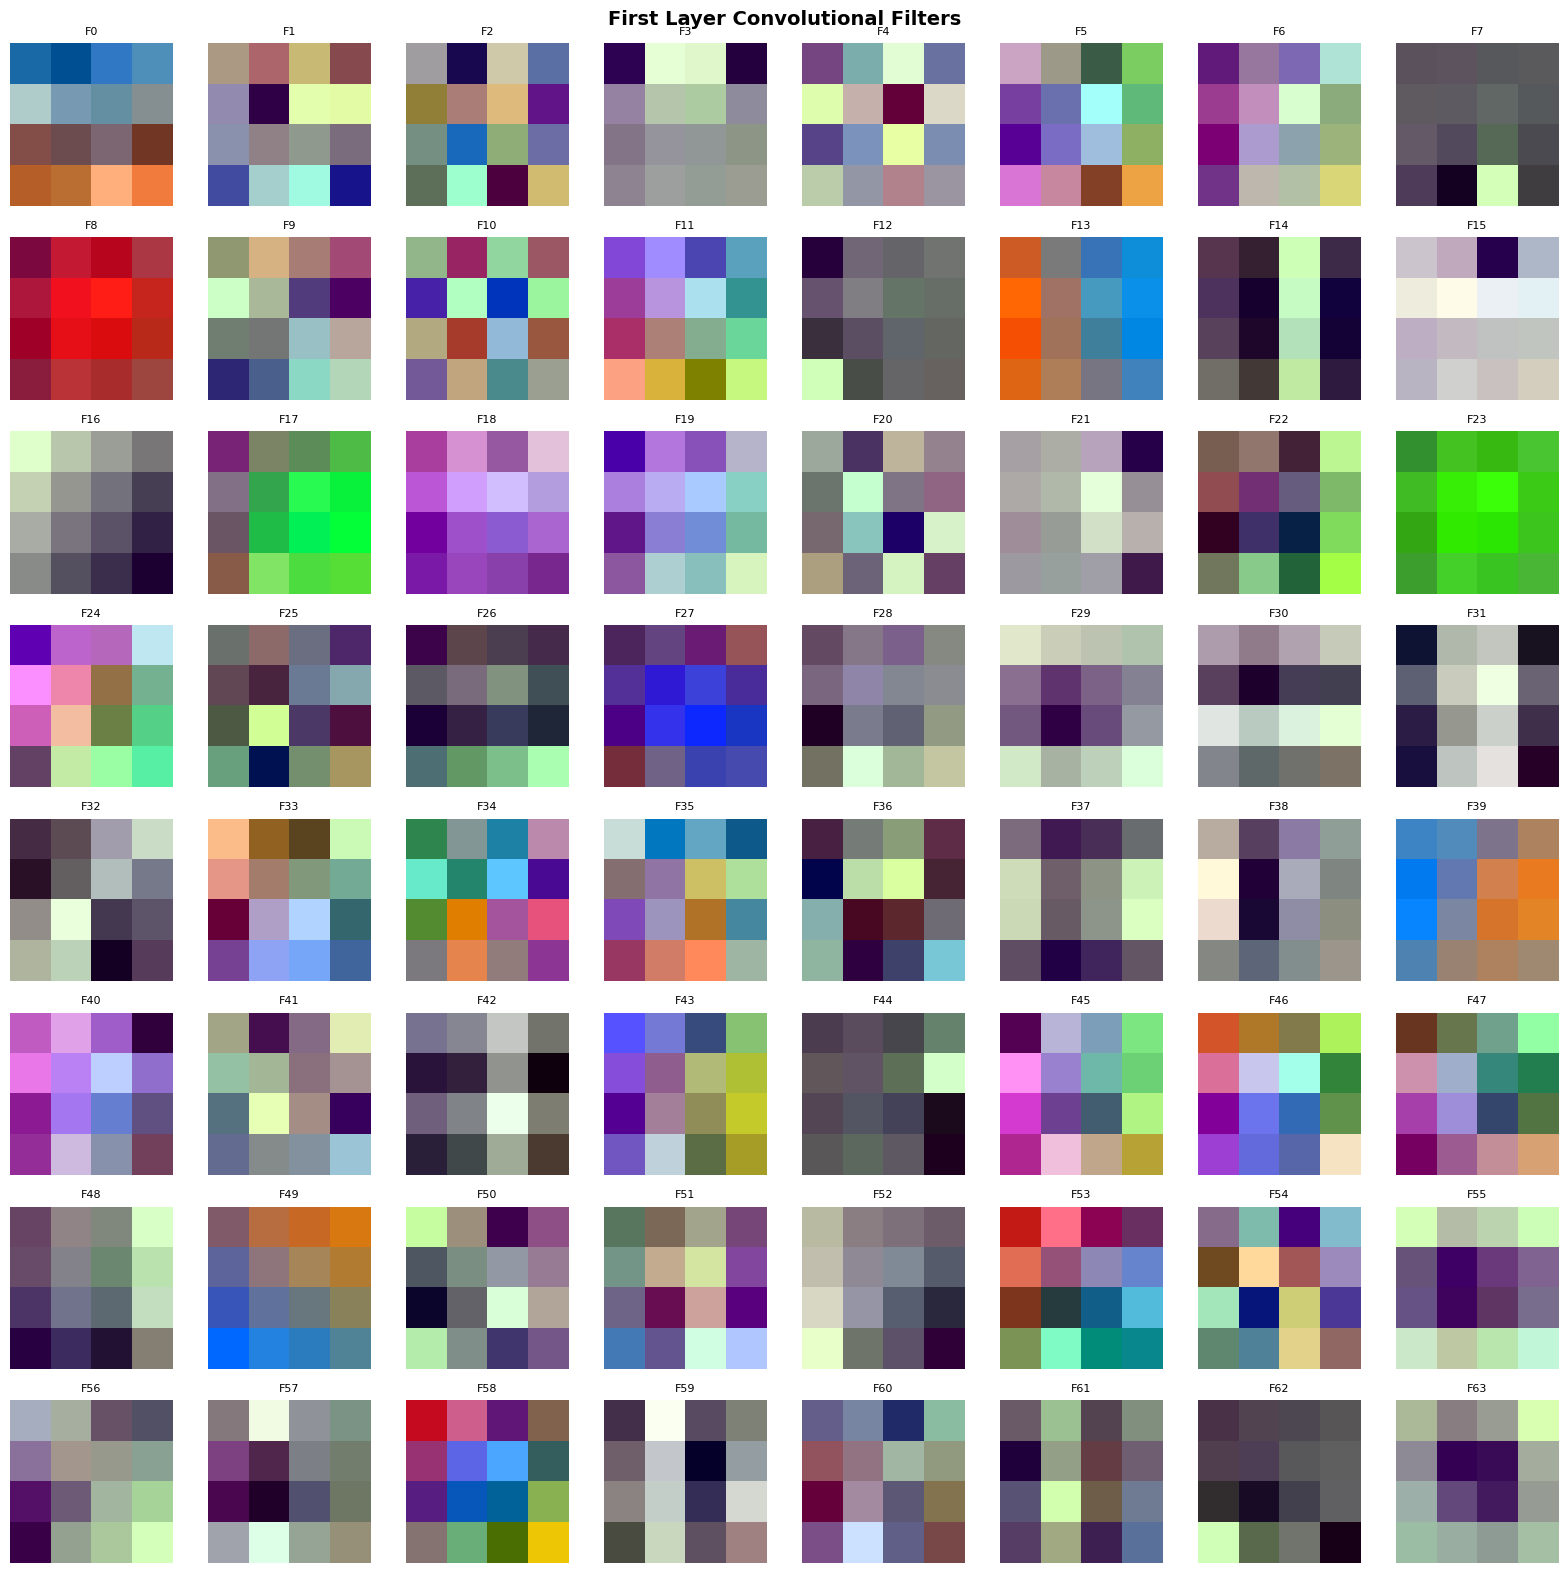

First conv layer: Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
Filter shape: torch.Size([64, 3, 4, 4])


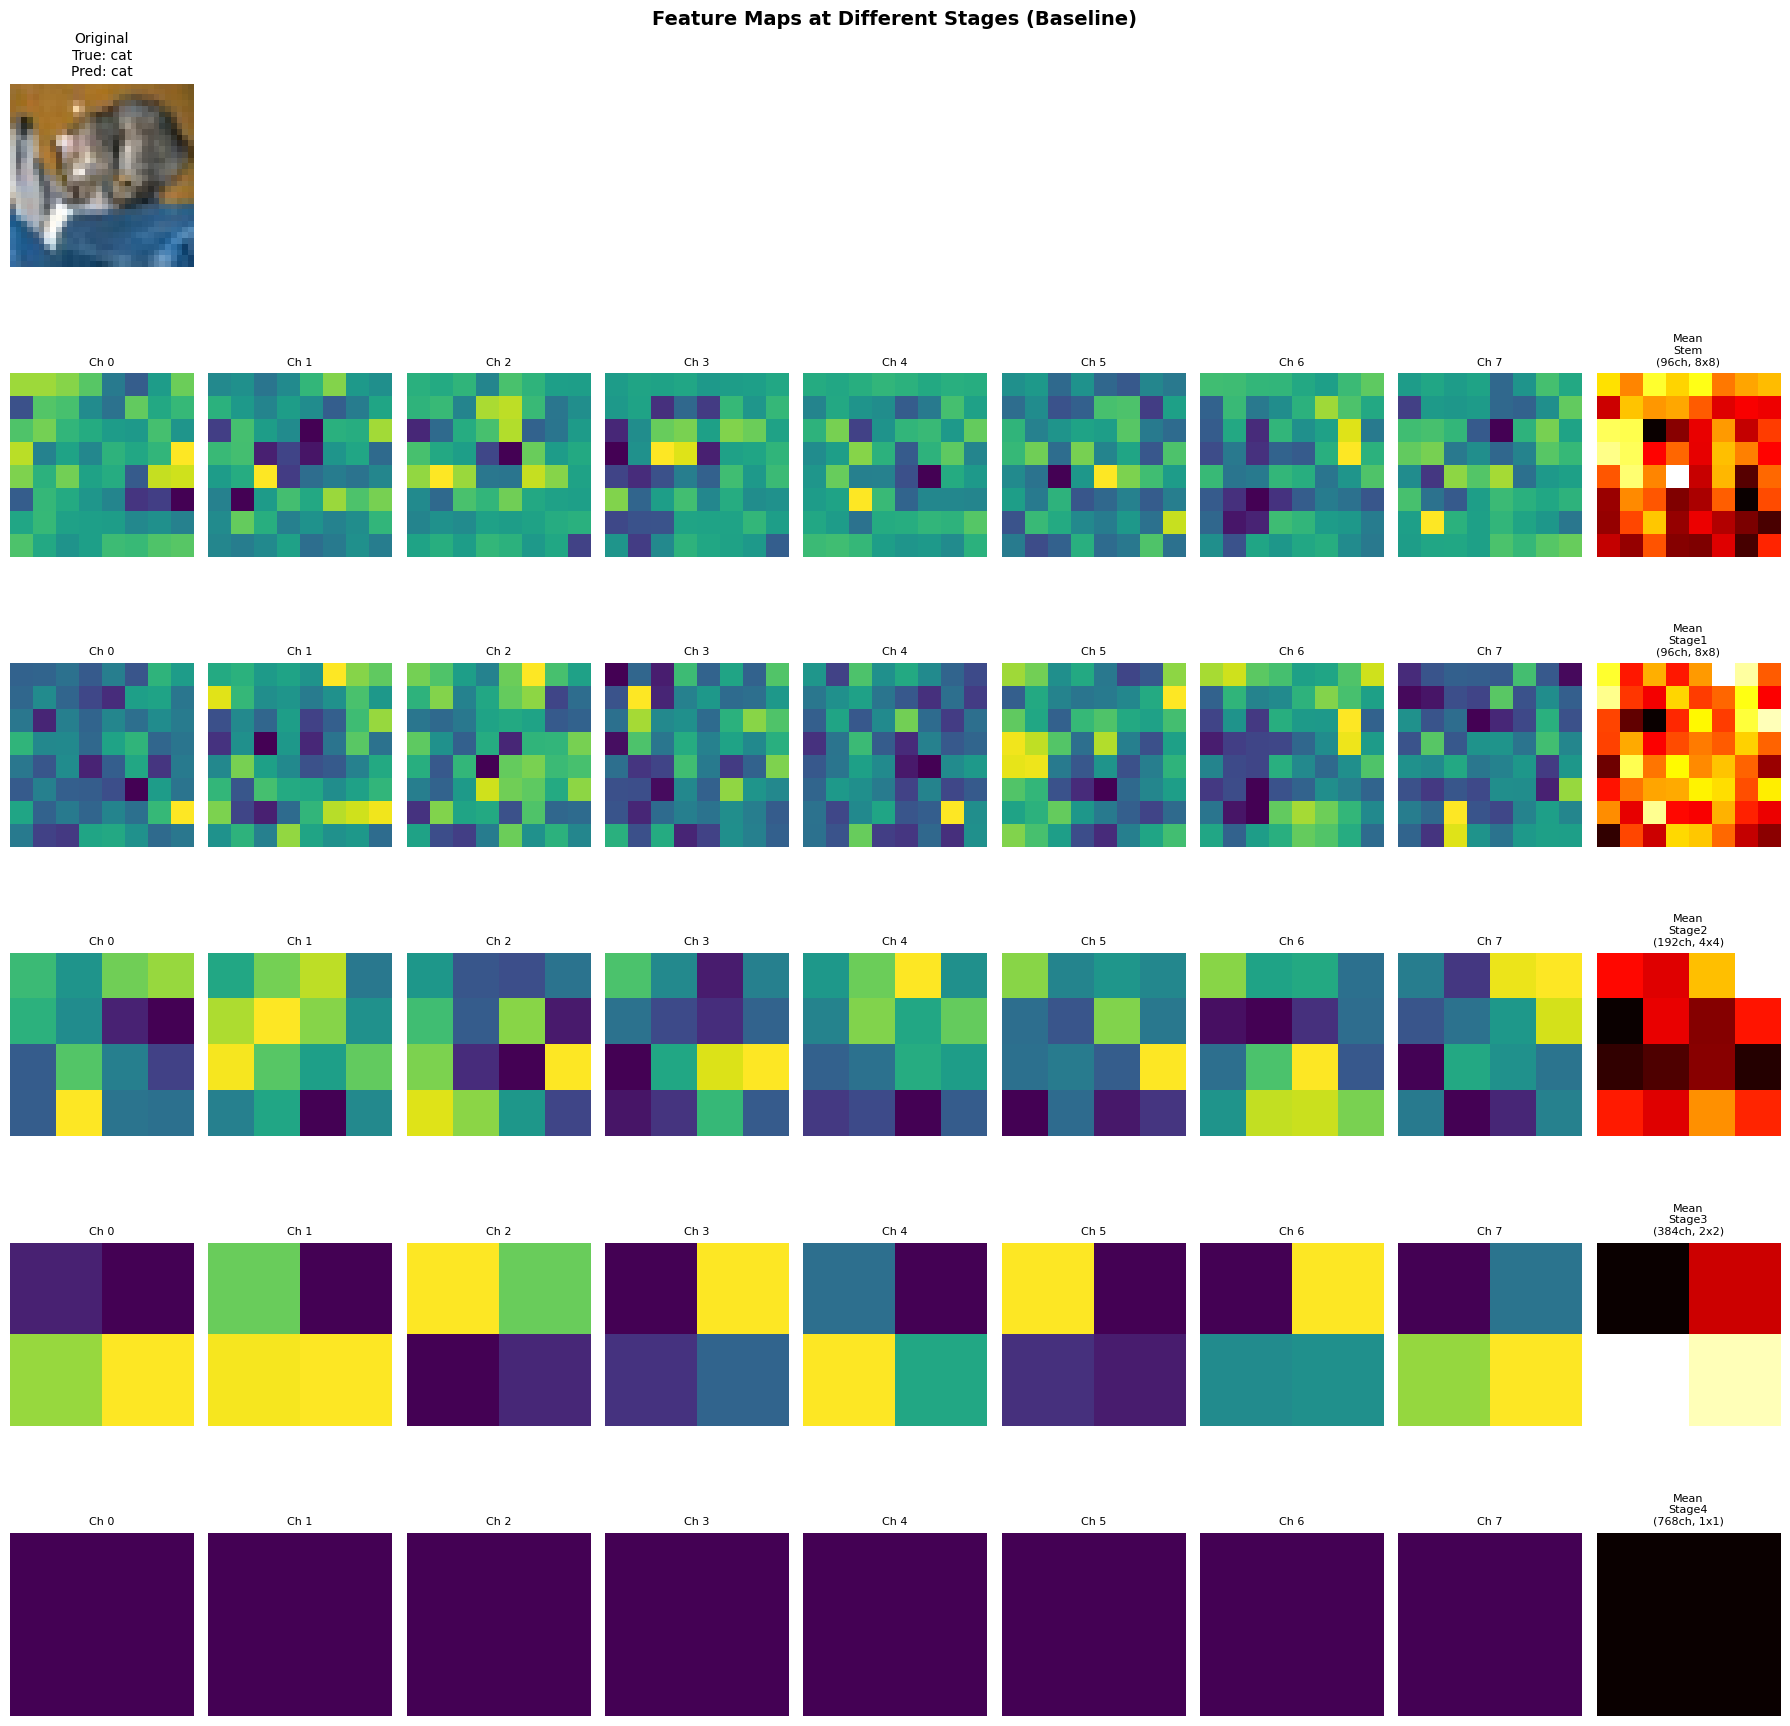

IndexError: tuple index out of range

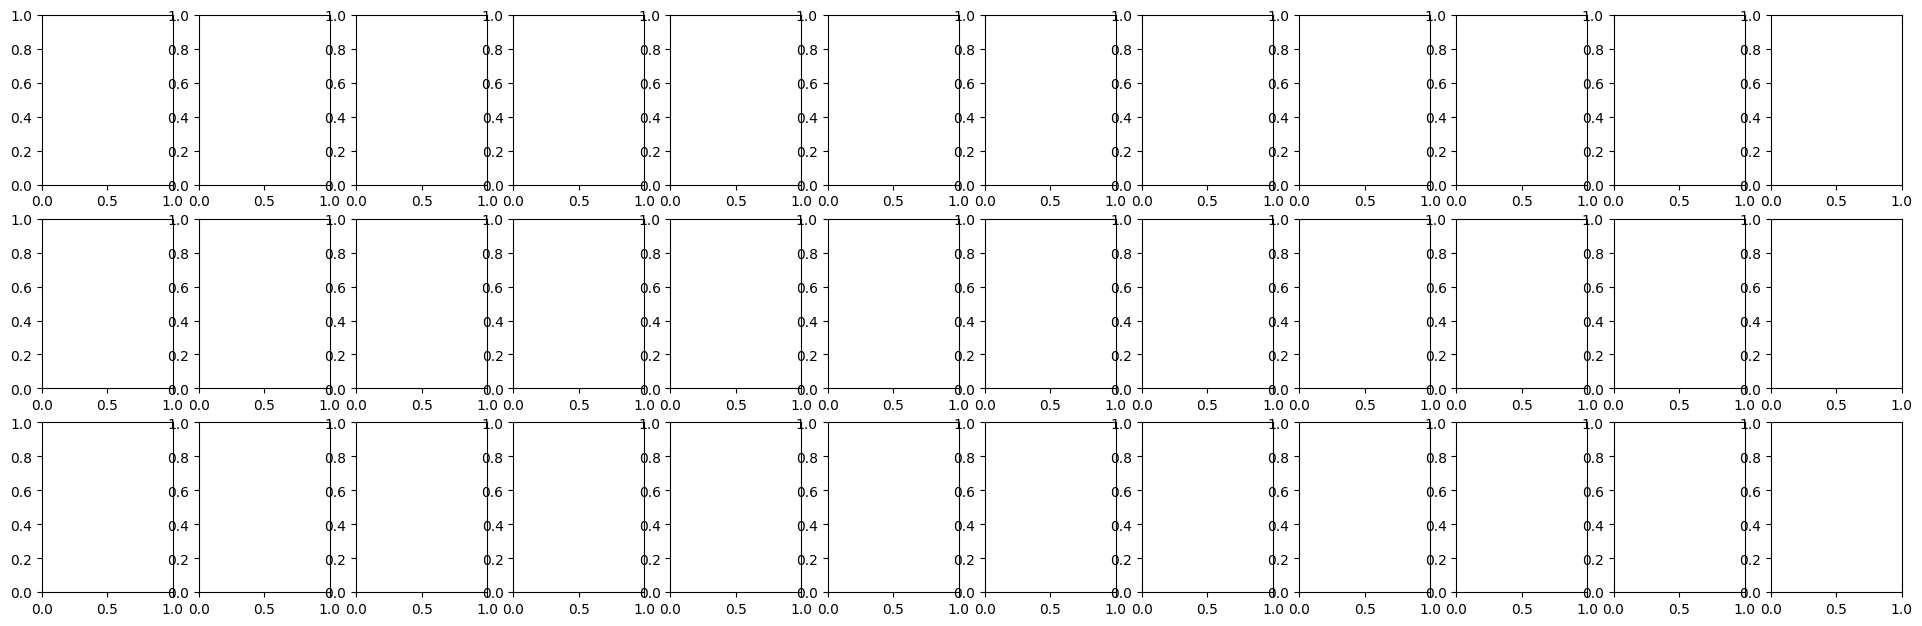

In [8]:
# ============================================================
# CIFAR-10 BASELINE: Feature & Filter Visualization
# ============================================================
#
# WHAT WE'RE VISUALIZING:
# 1. Convolutional filters (first layer weights)
# 2. Feature maps at different stages (what the network "sees")
# 3. Grad-CAM: which regions influence the prediction
# 4. Activation maximization patterns
#
# This gives us a baseline to compare against attention models later.
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load best model
model.load_state_dict(torch.load("cifar10_baseline_best.pth"))
model = model.to(DEVICE)
model.eval()

# -----------------------
# 1. First Layer Filter Visualization
# -----------------------
def visualize_first_layer_filters(model, save_path="cifar10_baseline_filters.png"):
    """
    Visualize the first convolutional layer filters.
    ConvNeXt stem: features[0][0] is the first Conv2d
    """
    # Get first conv layer weights
    first_conv = model.features[0][0]  # Conv2d in stem
    weights = first_conv.weight.data.cpu()

    # Weights shape: (out_channels, in_channels, H, W)
    n_filters = min(64, weights.shape[0])  # Show up to 64 filters

    # Normalize for visualization
    weights = weights[:n_filters]
    weights = weights - weights.min()
    weights = weights / weights.max()

    # Plot
    n_cols = 8
    n_rows = (n_filters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2*n_rows))
    axes = axes.flatten()

    for i in range(n_filters):
        # Convert to RGB image (average over input channels if needed)
        filt = weights[i]
        if filt.shape[0] == 3:
            filt = filt.permute(1, 2, 0).numpy()
        else:
            filt = filt.mean(0).numpy()
            filt = np.stack([filt]*3, axis=-1)

        filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
        axes[i].imshow(filt)
        axes[i].axis('off')
        axes[i].set_title(f'F{i}', fontsize=8)

    # Hide empty subplots
    for i in range(n_filters, len(axes)):
        axes[i].axis('off')

    plt.suptitle("First Layer Convolutional Filters", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"First conv layer: {first_conv}")
    print(f"Filter shape: {weights.shape}")

visualize_first_layer_filters(model)

# -----------------------
# 2. Feature Maps at Different Stages
# -----------------------
def get_feature_maps(model, image):
    """
    Extract feature maps from different stages of ConvNeXt.

    ConvNeXt structure:
    features[0]: Stem (Conv + LayerNorm)
    features[1]: Stage 1
    features[2]: Downsample 1
    features[3]: Stage 2
    features[4]: Downsample 2
    features[5]: Stage 3
    features[6]: Downsample 3
    features[7]: Stage 4
    """
    feature_maps = {}
    x = image

    stage_names = ['Stem', 'Stage1', 'Down1', 'Stage2', 'Down2', 'Stage3', 'Down3', 'Stage4']

    for i, (name, layer) in enumerate(zip(stage_names, model.features)):
        x = layer(x)
        feature_maps[name] = x.detach().cpu()

    return feature_maps

def visualize_feature_maps(model, image, true_label, pred_label, save_path="cifar10_baseline_feature_maps.png"):
    """
    Visualize feature maps at different stages for a single image.
    """
    model.eval()
    with torch.no_grad():
        feature_maps = get_feature_maps(model, image.unsqueeze(0).to(DEVICE))

    # Select stages to visualize
    stages_to_show = ['Stem', 'Stage1', 'Stage2', 'Stage3', 'Stage4']

    fig, axes = plt.subplots(len(stages_to_show) + 1, 9, figsize=(18, 3*(len(stages_to_show)+1)))

    # Row 0: Original image
    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)
    img_display = image.cpu() * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    axes[0, 0].imshow(img_display)
    axes[0, 0].set_title(f"Original\nTrue: {CIFAR10_CLASSES[true_label]}\nPred: {CIFAR10_CLASSES[pred_label]}", fontsize=10)
    axes[0, 0].axis('off')

    for j in range(1, 9):
        axes[0, j].axis('off')

    # Rows 1+: Feature maps at each stage
    for row, stage_name in enumerate(stages_to_show, 1):
        fmaps = feature_maps[stage_name][0]  # (C, H, W)
        n_channels = fmaps.shape[0]

        # Show first 8 channels + mean
        for col in range(8):
            if col < n_channels:
                fmap = fmaps[col].numpy()
                fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
                axes[row, col].imshow(fmap, cmap='viridis')
                axes[row, col].set_title(f'Ch {col}', fontsize=8)
            axes[row, col].axis('off')

        # Last column: mean across all channels
        fmap_mean = fmaps.mean(0).numpy()
        fmap_mean = (fmap_mean - fmap_mean.min()) / (fmap_mean.max() - fmap_mean.min() + 1e-8)
        axes[row, 8].imshow(fmap_mean, cmap='hot')
        axes[row, 8].set_title(f'Mean\n{stage_name}\n({fmaps.shape[0]}ch, {fmaps.shape[1]}x{fmaps.shape[2]})', fontsize=8)
        axes[row, 8].axis('off')

    plt.suptitle("Feature Maps at Different Stages (Baseline)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Get a sample image
sample_idx = 0
test_ds_raw = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)
sample_image, sample_label = test_ds_raw[sample_idx]
sample_pred = preds[sample_idx]

visualize_feature_maps(model, sample_image, sample_label, sample_pred)

# -----------------------
# 3. Grad-CAM Visualization
# -----------------------
class GradCAM:
    """
    Grad-CAM: Gradient-weighted Class Activation Mapping.
    Shows which regions of the image are important for the prediction.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        """Generate Grad-CAM heatmap."""
        self.model.eval()

        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Get weights (global average pooling of gradients)
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)

        # Weighted combination of activations
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = F.relu(cam)  # Only positive contributions

        # Normalize
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy(), target_class

def visualize_gradcam_grid(model, test_loader, n_samples=12, save_path="cifar10_baseline_gradcam.png"):
    """
    Visualize Grad-CAM for multiple samples.
    """
    # Target layer: last stage before classifier (Stage 4)
    target_layer = model.features[7]  # Stage 4
    gradcam = GradCAM(model, target_layer)

    # Get samples
    test_ds_raw = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

    # Select diverse samples (one per class + some random)
    np.random.seed(42)
    sample_indices = []
    for class_idx in range(10):
        class_samples = [i for i, (_, label) in enumerate(test_ds_raw) if label == class_idx]
        sample_indices.append(np.random.choice(class_samples))
    sample_indices.extend(np.random.choice(len(test_ds_raw), 2, replace=False).tolist())
    sample_indices = sample_indices[:n_samples]

    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols * 3, figsize=(n_cols * 6, n_rows * 2.5))

    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)

    for i, idx in enumerate(sample_indices):
        row = i // n_cols
        col_base = (i % n_cols) * 3

        image, true_label = test_ds_raw[idx]
        image_input = image.unsqueeze(0).to(DEVICE)
        image_input.requires_grad = True

        # Generate Grad-CAM
        cam, pred_class = gradcam.generate_cam(image_input)

        # Resize CAM to image size
        cam_resized = np.array(Image.fromarray(cam).resize((32, 32), Image.BILINEAR))

        # Original image
        img_display = image.cpu() * std + mean
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        # Plot original
        axes[row, col_base].imshow(img_display)
        correct = "✓" if pred_class == true_label else "✗"
        color = 'green' if pred_class == true_label else 'red'
        axes[row, col_base].set_title(f"True: {CIFAR10_CLASSES[true_label][:5]}", fontsize=9)
        axes[row, col_base].axis('off')

        # Plot CAM heatmap
        axes[row, col_base + 1].imshow(cam_resized, cmap='jet')
        axes[row, col_base + 1].set_title(f"Grad-CAM", fontsize=9)
        axes[row, col_base + 1].axis('off')

        # Plot overlay
        overlay = img_display * 0.5 + plt.cm.jet(cam_resized)[:, :, :3] * 0.5
        axes[row, col_base + 2].imshow(overlay)
        axes[row, col_base + 2].set_title(f"Pred: {CIFAR10_CLASSES[pred_class][:5]} {correct}", fontsize=9, color=color)
        axes[row, col_base + 2].axis('off')

    plt.suptitle("Grad-CAM: Where does the model look? (Baseline)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

from PIL import Image
visualize_gradcam_grid(model, test_loader)

# -----------------------
# 4. Feature Map Statistics
# -----------------------
def analyze_feature_statistics(model, loader, n_batches=10):
    """
    Analyze activation statistics at each stage.
    Useful for understanding what the network learns.
    """
    model.eval()

    stage_names = ['Stem', 'Stage1', 'Down1', 'Stage2', 'Down2', 'Stage3', 'Down3', 'Stage4']
    stats = {name: {'mean': [], 'std': [], 'sparsity': []} for name in stage_names}

    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(loader):
            if batch_idx >= n_batches:
                break

            x = x.to(DEVICE)

            for name, layer in zip(stage_names, model.features):
                x = layer(x)

                # Calculate statistics
                stats[name]['mean'].append(x.mean().item())
                stats[name]['std'].append(x.std().item())
                stats[name]['sparsity'].append((x == 0).float().mean().item())

    # Average stats
    for name in stage_names:
        for key in stats[name]:
            stats[name][key] = np.mean(stats[name][key])

    return stats

stats = analyze_feature_statistics(model, test_loader)

# Plot statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

stage_names = list(stats.keys())
means = [stats[name]['mean'] for name in stage_names]
stds = [stats[name]['std'] for name in stage_names]
sparsities = [stats[name]['sparsity'] * 100 for name in stage_names]

axes[0].bar(stage_names, means, color='steelblue', edgecolor='black')
axes[0].set_ylabel("Mean Activation")
axes[0].set_title("Mean Activation per Stage")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(stage_names, stds, color='coral', edgecolor='black')
axes[1].set_ylabel("Std Activation")
axes[1].set_title("Activation Std per Stage")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(stage_names, sparsities, color='mediumseagreen', edgecolor='black')
axes[2].set_ylabel("Sparsity (%)")
axes[2].set_title("Activation Sparsity per Stage (% zeros)")
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle("Feature Statistics Across Stages (Baseline)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("cifar10_baseline_feature_stats.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Statistics:")
print(f"{'Stage':<10} {'Mean':>10} {'Std':>10} {'Sparsity':>10}")
print("-" * 42)
for name in stage_names:
    print(f"{name:<10} {stats[name]['mean']:>10.4f} {stats[name]['std']:>10.4f} {stats[name]['sparsity']*100:>10.2f}%")

# -----------------------
# Summary
# -----------------------
print("\n" + "="*70)
print("BASELINE VISUALIZATION SUMMARY")
print("="*70)
print("""
Generated visualizations:
1. cifar10_baseline_filters.png      - First layer conv filters
2. cifar10_baseline_feature_maps.png - Feature maps at each stage
3. cifar10_baseline_gradcam.png      - Grad-CAM attention maps
4. cifar10_baseline_feature_stats.png - Activation statistics

These serve as baseline for comparison with attention models.
When we add attention, we'll compare:
- Do attention maps focus on more relevant regions than Grad-CAM?
- How do feature statistics change with attention?
- Does attention improve localization of objects?
""")

In [ ]:
# ============================================================
# CIFAR-10 BASELINE: Feature & Filter Visualization (FIXED)
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image

# Make sure model is loaded and in eval mode
model.load_state_dict(torch.load("cifar10_baseline_best.pth"))
model = model.to(DEVICE)
model.eval()

# -----------------------
# 1. First Layer Filter Visualization
# -----------------------
def visualize_first_layer_filters(model, save_path="cifar10_baseline_filters.png"):
    """
    Visualize the first convolutional layer filters.
    """
    first_conv = model.features[0][0]
    weights = first_conv.weight.data.cpu()

    n_filters = min(64, weights.shape[0])
    weights = weights[:n_filters]
    weights = weights - weights.min()
    weights = weights / weights.max()

    n_cols = 8
    n_rows = (n_filters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2*n_rows))
    axes = axes.flatten()

    for i in range(n_filters):
        filt = weights[i]
        if filt.shape[0] == 3:
            filt = filt.permute(1, 2, 0).numpy()
        else:
            filt = filt.mean(0).numpy()
            filt = np.stack([filt]*3, axis=-1)

        filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
        axes[i].imshow(filt)
        axes[i].axis('off')
        axes[i].set_title(f'F{i}', fontsize=8)

    for i in range(n_filters, len(axes)):
        axes[i].axis('off')

    plt.suptitle("First Layer Convolutional Filters", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"First conv layer: {first_conv}")
    print(f"Filter shape: {weights.shape}")

visualize_first_layer_filters(model)

# -----------------------
# 2. Feature Maps at Different Stages
# -----------------------
def get_feature_maps(model, image):
    """Extract feature maps from different stages."""
    feature_maps = {}
    x = image

    stage_names = ['Stem', 'Stage1', 'Down1', 'Stage2', 'Down2', 'Stage3', 'Down3', 'Stage4']

    for i, (name, layer) in enumerate(zip(stage_names, model.features)):
        x = layer(x)
        feature_maps[name] = x.detach().cpu()

    return feature_maps

def visualize_feature_maps(model, image, true_label, save_path="cifar10_baseline_feature_maps.png"):
    """Visualize feature maps at different stages for a single image."""
    model.eval()

    # Get prediction
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(DEVICE)
        logits = model(image_input)
        pred_label = logits.argmax(1).item()
        feature_maps = get_feature_maps(model, image.unsqueeze(0).to(DEVICE))

    stages_to_show = ['Stem', 'Stage1', 'Stage2', 'Stage3', 'Stage4']

    fig, axes = plt.subplots(len(stages_to_show) + 1, 9, figsize=(18, 3*(len(stages_to_show)+1)))

    # Row 0: Original image
    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)
    img_display = image.cpu() * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    axes[0, 0].imshow(img_display)
    axes[0, 0].set_title(f"Original\nTrue: {CIFAR10_CLASSES[true_label]}\nPred: {CIFAR10_CLASSES[pred_label]}", fontsize=10)
    axes[0, 0].axis('off')

    for j in range(1, 9):
        axes[0, j].axis('off')

    # Rows 1+: Feature maps at each stage
    for row, stage_name in enumerate(stages_to_show, 1):
        fmaps = feature_maps[stage_name][0]
        n_channels = fmaps.shape[0]

        for col in range(8):
            if col < n_channels:
                fmap = fmaps[col].numpy()
                fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
                axes[row, col].imshow(fmap, cmap='viridis')
                axes[row, col].set_title(f'Ch {col}', fontsize=8)
            axes[row, col].axis('off')

        fmap_mean = fmaps.mean(0).numpy()
        fmap_mean = (fmap_mean - fmap_mean.min()) / (fmap_mean.max() - fmap_mean.min() + 1e-8)
        axes[row, 8].imshow(fmap_mean, cmap='hot')
        axes[row, 8].set_title(f'Mean\n{stage_name}\n({fmaps.shape[0]}ch, {fmaps.shape[1]}x{fmaps.shape[2]})', fontsize=8)
        axes[row, 8].axis('off')

    plt.suptitle("Feature Maps at Different Stages (Baseline)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Get sample image and visualize
test_ds_raw = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)
sample_image, sample_label = test_ds_raw[0]
visualize_feature_maps(model, sample_image, sample_label)

# -----------------------
# 3. Grad-CAM Visualization
# -----------------------
class GradCAM:
    """Grad-CAM: Gradient-weighted Class Activation Mapping."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        """Generate Grad-CAM heatmap."""
        self.model.eval()

        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()

        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy(), target_class

def visualize_gradcam_grid(model, n_samples=12, save_path="cifar10_baseline_gradcam.png"):
    """Visualize Grad-CAM for multiple samples."""

    # Need to rebuild model for fresh hooks
    model_for_cam = build_baseline_model()
    model_for_cam.load_state_dict(torch.load("cifar10_baseline_best.pth"))
    model_for_cam = model_for_cam.to(DEVICE)
    model_for_cam.eval()

    target_layer = model_for_cam.features[7]
    gradcam = GradCAM(model_for_cam, target_layer)

    test_ds_raw = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

    # Select one sample per class + 2 random
    np.random.seed(42)
    sample_indices = []
    for class_idx in range(10):
        class_samples = [i for i, (_, label) in enumerate(test_ds_raw) if label == class_idx]
        sample_indices.append(np.random.choice(class_samples))
    sample_indices.extend(np.random.choice(len(test_ds_raw), 2, replace=False).tolist())
    sample_indices = sample_indices[:n_samples]

    n_cols = 4
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols * 3, figsize=(n_cols * 6, n_rows * 2.5))

    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)

    for i, idx in enumerate(sample_indices):
        row = i // n_cols
        col_base = (i % n_cols) * 3

        image, true_label = test_ds_raw[idx]
        image_input = image.unsqueeze(0).to(DEVICE)
        image_input.requires_grad = True

        cam, pred_class = gradcam.generate_cam(image_input)

        cam_resized = np.array(Image.fromarray((cam * 255).astype(np.uint8)).resize((32, 32), Image.BILINEAR)) / 255.0

        img_display = image.cpu() * std + mean
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        # Plot original
        axes[row, col_base].imshow(img_display)
        axes[row, col_base].set_title(f"True: {CIFAR10_CLASSES[true_label][:6]}", fontsize=9)
        axes[row, col_base].axis('off')

        # Plot CAM heatmap
        axes[row, col_base + 1].imshow(cam_resized, cmap='jet')
        axes[row, col_base + 1].set_title(f"Grad-CAM", fontsize=9)
        axes[row, col_base + 1].axis('off')

        # Plot overlay
        overlay = img_display * 0.5 + plt.cm.jet(cam_resized)[:, :, :3] * 0.5
        correct = "✓" if pred_class == true_label else "✗"
        color = 'green' if pred_class == true_label else 'red'
        axes[row, col_base + 2].imshow(overlay)
        axes[row, col_base + 2].set_title(f"Pred: {CIFAR10_CLASSES[pred_class][:6]} {correct}", fontsize=9, color=color)
        axes[row, col_base + 2].axis('off')

    plt.suptitle("Grad-CAM: Where does the model look? (Baseline)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

visualize_gradcam_grid(model)

# -----------------------
# 4. Feature Map Statistics
# -----------------------
def analyze_feature_statistics(model, loader, n_batches=10):
    """Analyze activation statistics at each stage."""
    model.eval()

    stage_names = ['Stem', 'Stage1', 'Down1', 'Stage2', 'Down2', 'Stage3', 'Down3', 'Stage4']
    stats = {name: {'mean': [], 'std': [], 'sparsity': []} for name in stage_names}

    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(loader):
            if batch_idx >= n_batches:
                break

            x = x.to(DEVICE)

            for name, layer in zip(stage_names, model.features):
                x = layer(x)
                stats[name]['mean'].append(x.mean().item())
                stats[name]['std'].append(x.std().item())
                stats[name]['sparsity'].append((x == 0).float().mean().item())

    for name in stage_names:
        for key in stats[name]:
            stats[name][key] = np.mean(stats[name][key])

    return stats

stats = analyze_feature_statistics(model, test_loader)

# Plot statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

stage_names = list(stats.keys())
means = [stats[name]['mean'] for name in stage_names]
stds = [stats[name]['std'] for name in stage_names]
sparsities = [stats[name]['sparsity'] * 100 for name in stage_names]

axes[0].bar(stage_names, means, color='steelblue', edgecolor='black')
axes[0].set_ylabel("Mean Activation")
axes[0].set_title("Mean Activation per Stage")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(stage_names, stds, color='coral', edgecolor='black')
axes[1].set_ylabel("Std Activation")
axes[1].set_title("Activation Std per Stage")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(stage_names, sparsities, color='mediumseagreen', edgecolor='black')
axes[2].set_ylabel("Sparsity (%)")
axes[2].set_title("Activation Sparsity per Stage (% zeros)")
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle("Feature Statistics Across Stages (Baseline)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("cifar10_baseline_feature_stats.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Statistics:")
print(f"{'Stage':<10} {'Mean':>10} {'Std':>10} {'Sparsity':>10}")
print("-" * 42)
for name in stage_names:
    print(f"{name:<10} {stats[name]['mean']:>10.4f} {stats[name]['std']:>10.4f} {stats[name]['sparsity']*100:>10.2f}%")

# -----------------------
# Summary
# -----------------------
print("\n" + "="*70)
print("BASELINE VISUALIZATION COMPLETE")
print("="*70)
print(f"Saved: cifar10_baseline_filters.png")
print(f"Saved: cifar10_baseline_feature_maps.png")
print(f"Saved: cifar10_baseline_gradcam.png")
print(f"Saved: cifar10_baseline_feature_stats.png")
print("="*70)

In [ ]:
# ============================================================
# CIFAR-10 EXPERIMENT A: Dual Attention (P2 + P3)
# ============================================================
#
# HYPOTHESIS:
# On CIFAR-10 (simpler, 10 classes), attention should help MORE than
# on CIFAR-100 (complex, 100 classes) because:
# - Less diversity = clearer patterns to attend to
# - Less risk of overfitting to noise
#
# We'll compare the improvement (or lack thereof) to CIFAR-100 results.
#
# SETUP: Same as CIFAR-100 experiments
# - Dual MHSA at P2 (C=192) and P3 (C=384)
# - Phase 1: frozen backbone (5 epochs)
# - Phase 2: full fine-tune (15 epochs)
# ============================================================

import os, time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from PIL import Image

# -----------------------
# Config
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 50
WARMUP_EPOCHS = 5
BATCH_TRAIN = 128
BATCH_TEST = 256
NUM_WORKERS = 2
LR_HEAD_ATTN = 5e-4
LR_BACKBONE_SMALL = 5e-5
WD = 0.05

CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# -----------------------
# Data
# -----------------------
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tf)
test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ============================================================
# ATTENTION MECHANISMS
# ============================================================

class GatedMHSA2D(nn.Module):
    """Multi-Head Self-Attention with learnable gate."""
    def __init__(self, C, num_heads=4):
        super().__init__()
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.num_heads = num_heads
        # Store attention weights for visualization
        self.attn_weights = None
        self.feat_shape = None

    def forward(self, x):
        B, C, H, W = x.shape
        self.feat_shape = (H, W)
        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        t = self.norm(tokens)
        out, weights = self.attn(t, t, t, need_weights=True, average_attn_weights=False)
        self.attn_weights = weights.detach()
        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)
        return x + self.alpha * out


class GatedSE(nn.Module):
    """Squeeze-and-Excitation with learnable gate."""
    def __init__(self, C, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(C, C // reduction, bias=False)
        self.fc2 = nn.Linear(C // reduction, C, bias=False)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape
        y = x.mean(dim=(2, 3))
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(B, C, 1, 1)
        return x + self.alpha * (x * y - x)


class GatedECA(nn.Module):
    """Efficient Channel Attention - only ~6 parameters!"""
    def __init__(self, C, gamma=2, b=1):
        super().__init__()
        t = int(abs((math.log2(C) + b) / gamma))
        k = t if t % 2 else t + 1
        k = max(3, k)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k//2, bias=False)
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.k = k

    def forward(self, x):
        B, C, H, W = x.shape
        y = x.mean(dim=(2, 3)).unsqueeze(1)
        y = torch.sigmoid(self.conv(y).squeeze(1))
        y = y.view(B, C, 1, 1)
        return x + self.alpha * (x * y - x)


class ChannelAttention(nn.Module):
    """Channel attention for CBAM."""
    def __init__(self, C, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(C, C // reduction, bias=False)
        self.fc2 = nn.Linear(C // reduction, C, bias=False)

    def forward(self, x):
        B, C, H, W = x.shape
        avg_pool = x.mean(dim=(2, 3))
        max_pool = x.amax(dim=(2, 3))
        avg_out = self.fc2(F.relu(self.fc1(avg_pool)))
        max_out = self.fc2(F.relu(self.fc1(max_pool)))
        return torch.sigmoid(avg_out + max_out).view(B, C, 1, 1)


class SpatialAttention(nn.Module):
    """Spatial attention for CBAM."""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        avg_out = x.mean(dim=1, keepdim=True)
        max_out = x.amax(dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        return torch.sigmoid(self.conv(y))


class GatedCBAM(nn.Module):
    """CBAM: Channel + Spatial attention with gate."""
    def __init__(self, C, reduction=16, spatial_kernel=7):
        super().__init__()
        self.channel_attn = ChannelAttention(C, reduction)
        self.spatial_attn = SpatialAttention(spatial_kernel)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        ca = self.channel_attn(x)
        x_ca = x * ca
        sa = self.spatial_attn(x_ca)
        x_sa = x_ca * sa
        return x + self.alpha * (x_sa - x)


class GatedSpatialOnly(nn.Module):
    """Spatial attention only."""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.spatial_attn = SpatialAttention(kernel_size)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        sa = self.spatial_attn(x)
        return x + self.alpha * (x * sa - x)

# ============================================================
# MODEL BUILDERS
# ============================================================

def build_baseline_model():
    """ConvNeXt-Tiny without attention."""
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 10)
    return model


def build_dual_attention_model(num_heads=4):
    """ConvNeXt-Tiny with MHSA at P2 and P3."""
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 10)

    attn_p2 = GatedMHSA2D(C=192, num_heads=num_heads)
    attn_p3 = GatedMHSA2D(C=384, num_heads=num_heads)

    new_features = nn.Sequential(
        model.features[0],  # stem
        model.features[1],  # stage1
        model.features[2],  # down1
        model.features[3],  # stage2
        attn_p2,            # attention P2
        model.features[4],  # down2
        model.features[5],  # stage3
        attn_p3,            # attention P3
        model.features[6],  # down3
        model.features[7],  # stage4
    )
    model.features = new_features

    return model, attn_p2, attn_p3


def build_single_attention_model(attn_type="ECA", position="P3"):
    """ConvNeXt-Tiny with single attention block."""
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 10)

    C = 384 if position == "P3" else 192

    if attn_type == "MHSA":
        attn = GatedMHSA2D(C, num_heads=1)
    elif attn_type == "SE":
        attn = GatedSE(C, reduction=16)
    elif attn_type == "ECA":
        attn = GatedECA(C)
    elif attn_type == "CBAM":
        attn = GatedCBAM(C, reduction=16)
    elif attn_type == "Spatial":
        attn = GatedSpatialOnly(kernel_size=7)
    else:
        raise ValueError(f"Unknown attention type: {attn_type}")

    if position == "P3":
        new_features = nn.Sequential(
            model.features[0],
            model.features[1],
            model.features[2],
            model.features[3],
            model.features[4],
            model.features[5],
            attn,               # attention at P3
            model.features[6],
            model.features[7],
        )
    else:  # P2
        new_features = nn.Sequential(
            model.features[0],
            model.features[1],
            model.features[2],
            model.features[3],
            attn,               # attention at P2
            model.features[4],
            model.features[5],
            model.features[6],
            model.features[7],
        )

    model.features = new_features
    attn_params = sum(p.numel() for p in attn.parameters())

    return model, attn, attn_params

# ============================================================
# TRAINING UTILITIES
# ============================================================

criterion = nn.CrossEntropyLoss()

def set_requires_grad(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss_sum += criterion(logits, y).item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

@torch.no_grad()
def evaluate_full(model, loader):
    """Full evaluation with predictions and probabilities."""
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def train_one_epoch(model, loader, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

# ============================================================
# EXPERIMENT A: DUAL ATTENTION
# ============================================================

def run_experiment_A(seed=0):
    """Dual MHSA attention at P2 + P3."""
    print("\n" + "="*70)
    print("EXPERIMENT A: Dual Attention (MHSA at P2 + P3)")
    print("="*70)

    set_seed(seed)
    model, attn_p2, attn_p3 = build_dual_attention_model(num_heads=4)
    model = model.to(DEVICE)

    # Phase 1: Freeze backbone
    set_requires_grad(model, False)
    set_requires_grad(attn_p2, True)
    set_requires_grad(attn_p3, True)
    set_requires_grad(model.classifier, True)

    opt = torch.optim.AdamW(
        list(attn_p2.parameters()) + list(attn_p3.parameters()) + list(model.classifier.parameters()),
        lr=LR_HEAD_ATTN, weight_decay=WD
    )
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

    logs = []
    best_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        # Phase 2: Unfreeze all
        if epoch == WARMUP_EPOCHS + 1:
            print("-" * 50)
            print("Phase 2: Unfreezing backbone")
            print("-" * 50)
            set_requires_grad(model, True)

            attn_ids = {id(p) for p in attn_p2.parameters()} | {id(p) for p in attn_p3.parameters()}
            backbone = [p for n, p in model.named_parameters()
                        if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]

            opt = torch.optim.AdamW([
                {"params": backbone, "lr": LR_BACKBONE_SMALL},
                {"params": attn_p2.parameters(), "lr": LR_HEAD_ATTN},
                {"params": attn_p3.parameters(), "lr": LR_HEAD_ATTN},
                {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
            ], weight_decay=WD)
            sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
        te_loss, te_acc = evaluate(model, test_loader)
        sch.step()

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), "cifar10_exp_a_best.pth")

        logs.append({
            "epoch": epoch, "train_acc": tr_acc, "test_acc": te_acc,
            "train_loss": tr_loss, "test_loss": te_loss,
            "alpha_p2": attn_p2.alpha.item(), "alpha_p3": attn_p3.alpha.item(),
        })

        print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | α_p2 {attn_p2.alpha.item():.4f} | α_p3 {attn_p3.alpha.item():.4f}")

    return {"name": "A_DualMHSA", "best_acc": best_acc, "logs": logs,
            "final_alpha_p2": attn_p2.alpha.item(), "final_alpha_p3": attn_p3.alpha.item(),
            "model": model, "attn_p2": attn_p2, "attn_p3": attn_p3}

# ============================================================
# EXPERIMENT B: HEAD COUNT
# ============================================================

def run_experiment_B(seed=0):
    """Test different numbers of attention heads."""
    print("\n" + "="*70)
    print("EXPERIMENT B: Attention Head Count (1, 2, 4, 8)")
    print("="*70)

    head_configs = [1, 2, 4, 8]
    results = []

    for num_heads in head_configs:
        print(f"\n--- Testing {num_heads} heads ---")
        set_seed(seed)
        model, attn_p2, attn_p3 = build_dual_attention_model(num_heads=num_heads)
        model = model.to(DEVICE)

        # Phase 1
        set_requires_grad(model, False)
        set_requires_grad(attn_p2, True)
        set_requires_grad(attn_p3, True)
        set_requires_grad(model.classifier, True)

        opt = torch.optim.AdamW(
            list(attn_p2.parameters()) + list(attn_p3.parameters()) + list(model.classifier.parameters()),
            lr=LR_HEAD_ATTN, weight_decay=WD
        )
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

        logs = []
        best_acc = 0.0

        for epoch in range(1, EPOCHS + 1):
            if epoch == WARMUP_EPOCHS + 1:
                set_requires_grad(model, True)
                attn_ids = {id(p) for p in attn_p2.parameters()} | {id(p) for p in attn_p3.parameters()}
                backbone = [p for n, p in model.named_parameters()
                            if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]
                opt = torch.optim.AdamW([
                    {"params": backbone, "lr": LR_BACKBONE_SMALL},
                    {"params": attn_p2.parameters(), "lr": LR_HEAD_ATTN},
                    {"params": attn_p3.parameters(), "lr": LR_HEAD_ATTN},
                    {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
                ], weight_decay=WD)
                sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
            te_loss, te_acc = evaluate(model, test_loader)
            sch.step()

            if te_acc > best_acc:
                best_acc = te_acc
                torch.save(model.state_dict(), f"cifar10_exp_b_{num_heads}heads_best.pth")

            logs.append({
                "epoch": epoch, "train_acc": tr_acc, "test_acc": te_acc,
                "alpha_p2": attn_p2.alpha.item(), "alpha_p3": attn_p3.alpha.item(),
            })

            print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f}")

        results.append({
            "num_heads": num_heads, "best_acc": best_acc, "logs": logs,
            "final_alpha_p2": attn_p2.alpha.item(), "final_alpha_p3": attn_p3.alpha.item(),
        })

    return {"name": "B_HeadCount", "results": results}

# ============================================================
# EXPERIMENT C: ATTENTION TYPES
# ============================================================

def run_experiment_C(seed=0):
    """Test different attention mechanisms at P3."""
    print("\n" + "="*70)
    print("EXPERIMENT C: Attention Types (MHSA, SE, ECA, CBAM, Spatial)")
    print("="*70)

    attn_types = ["MHSA", "SE", "ECA", "CBAM", "Spatial"]
    results = []

    for attn_type in attn_types:
        print(f"\n--- Testing {attn_type} ---")
        set_seed(seed)
        model, attn, attn_params = build_single_attention_model(attn_type=attn_type, position="P3")
        model = model.to(DEVICE)

        print(f"{attn_type} parameters: {attn_params:,}")

        # Phase 1
        set_requires_grad(model, False)
        set_requires_grad(attn, True)
        set_requires_grad(model.classifier, True)

        opt = torch.optim.AdamW(
            list(attn.parameters()) + list(model.classifier.parameters()),
            lr=LR_HEAD_ATTN, weight_decay=WD
        )
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

        logs = []
        best_acc = 0.0

        for epoch in range(1, EPOCHS + 1):
            if epoch == WARMUP_EPOCHS + 1:
                set_requires_grad(model, True)
                attn_ids = {id(p) for p in attn.parameters()}
                backbone = [p for n, p in model.named_parameters()
                            if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]
                opt = torch.optim.AdamW([
                    {"params": backbone, "lr": LR_BACKBONE_SMALL},
                    {"params": attn.parameters(), "lr": LR_HEAD_ATTN},
                    {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
                ], weight_decay=WD)
                sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
            te_loss, te_acc = evaluate(model, test_loader)
            sch.step()

            if te_acc > best_acc:
                best_acc = te_acc
                torch.save(model.state_dict(), f"cifar10_exp_c_{attn_type}_best.pth")

            logs.append({
                "epoch": epoch, "train_acc": tr_acc, "test_acc": te_acc,
                "alpha": attn.alpha.item(),
            })

            print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | α {attn.alpha.item():.4f}")

        results.append({
            "attn_type": attn_type, "attn_params": attn_params,
            "best_acc": best_acc, "logs": logs, "final_alpha": attn.alpha.item(),
        })

    return {"name": "C_AttnTypes", "results": results}

# ============================================================
# RUN ALL EXPERIMENTS
# ============================================================

print("="*70)
print("CIFAR-10 ATTENTION EXPERIMENTS")
print("="*70)
print(f"Baseline accuracy: {cifar10_baseline_acc*100:.2f}%")
print("="*70)

# Run experiments
results_A = run_experiment_A(seed=0)
results_B = run_experiment_B(seed=0)
results_C = run_experiment_C(seed=0)

# Store all results
all_results = {
    "baseline": cifar10_baseline_acc,
    "exp_A": results_A,
    "exp_B": results_B,
    "exp_C": results_C,
}

In [ ]:
# ============================================================
# CIFAR-10: COMPREHENSIVE RESULTS VISUALIZATION
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

baseline_acc = cifar10_baseline_acc

# Extract results
exp_a_acc = results_A['best_acc']
exp_b_results = results_B['results']
exp_c_results = results_C['results']

# -----------------------
# FIGURE 1: Overall Comparison
# -----------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: All experiments bar chart
all_accs = {
    "Baseline": baseline_acc,
    "A: Dual\nMHSA": exp_a_acc,
}
for r in exp_b_results:
    all_accs[f"B: {r['num_heads']}h"] = r['best_acc']
for r in exp_c_results:
    all_accs[f"C: {r['attn_type']}"] = r['best_acc']

names = list(all_accs.keys())
accs = [v * 100 for v in all_accs.values()]

colors = ['red'] + ['blue'] + ['green']*4 + ['purple']*5
bars = axes[0, 0].bar(names, accs, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].axhline(y=baseline_acc*100, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc*100:.2f}%)')
axes[0, 0].set_ylabel("Test Accuracy (%)")
axes[0, 0].set_title("All Experiments Comparison")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, accs):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f"{acc:.2f}", ha='center', fontsize=8, fontweight='bold')

# Plot 2: Experiment B - Head count
heads = [r['num_heads'] for r in exp_b_results]
head_accs = [r['best_acc'] * 100 for r in exp_b_results]

axes[0, 1].bar(heads, head_accs, color='steelblue', edgecolor='black')
axes[0, 1].axhline(y=baseline_acc*100, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0, 1].set_xlabel("Number of Attention Heads")
axes[0, 1].set_ylabel("Test Accuracy (%)")
axes[0, 1].set_title("Exp B: Head Count Ablation")
axes[0, 1].set_xticks(heads)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Experiment C - Attention types
attn_types = [r['attn_type'] for r in exp_c_results]
attn_accs = [r['best_acc'] * 100 for r in exp_c_results]
attn_params = [r['attn_params'] for r in exp_c_results]

colors_c = plt.cm.Set2(np.linspace(0, 1, len(attn_types)))
bars = axes[0, 2].bar(attn_types, attn_accs, color=colors_c, edgecolor='black')
axes[0, 2].axhline(y=baseline_acc*100, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0, 2].set_ylabel("Test Accuracy (%)")
axes[0, 2].set_title("Exp C: Attention Type Comparison")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, attn_accs):
    axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f"{acc:.2f}", ha='center', fontsize=9)

# Plot 4: Parameter efficiency (Exp C)
axes[1, 0].scatter(attn_params, attn_accs, s=200, c=colors_c, edgecolor='black', linewidth=2)
for t, p, a in zip(attn_types, attn_params, attn_accs):
    axes[1, 0].annotate(t, (p, a), textcoords="offset points", xytext=(5, 5), fontsize=10)
axes[1, 0].axhline(y=baseline_acc*100, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel("Attention Parameters")
axes[1, 0].set_ylabel("Test Accuracy (%)")
axes[1, 0].set_title("Exp C: Parameter Efficiency")
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Alpha values comparison
alpha_data = {
    "A: P2": results_A['final_alpha_p2'],
    "A: P3": results_A['final_alpha_p3'],
}
for r in exp_c_results:
    alpha_data[f"C: {r['attn_type']}"] = r['final_alpha']

alpha_names = list(alpha_data.keys())
alpha_vals = list(alpha_data.values())

colors_alpha = ['blue', 'blue'] + ['purple']*5
bars = axes[1, 1].bar(alpha_names, alpha_vals, color=colors_alpha, edgecolor='black', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_ylabel("Alpha (Gate) Value")
axes[1, 1].set_title("Final Alpha Values")
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Color positive/negative differently
for bar, val in zip(bars, alpha_vals):
    color = 'green' if val > 0 else 'red'
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f"{val:.3f}", ha='center', fontsize=8, color=color)

# Plot 6: Training curves (Exp A)
epochs = [l['epoch'] for l in results_A['logs']]
axes[1, 2].plot(epochs, [l['train_acc']*100 for l in results_A['logs']], 'o-', label='Train', color='blue')
axes[1, 2].plot(epochs, [l['test_acc']*100 for l in results_A['logs']], 's-', label='Test', color='orange')
axes[1, 2].axhline(y=baseline_acc*100, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[1, 2].axvline(x=WARMUP_EPOCHS+0.5, color='gray', linestyle='--', alpha=0.5, label='Phase 2')
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel("Accuracy (%)")
axes[1, 2].set_title("Exp A: Training Curves")
axes[1, 2].legend(loc='lower right')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle("CIFAR-10: Attention Experiments Summary", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("cifar10_attention_experiments_summary.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# FIGURE 2: CIFAR-10 vs CIFAR-100 Comparison
# -----------------------
# (Fill in CIFAR-100 results from your previous runs)

cifar100_baseline = 0.7724
cifar100_exp_a = 0.7593
cifar100_exp_c_eca = 0.7558

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comparison bar chart
comparison = {
    "Baseline": [cifar100_baseline*100, baseline_acc*100],
    "Dual MHSA": [cifar100_exp_a*100, exp_a_acc*100],
    "ECA": [cifar100_exp_c_eca*100, [r['best_acc'] for r in exp_c_results if r['attn_type']=='ECA'][0]*100],
}

x = np.arange(len(comparison))
width = 0.35

cifar100_vals = [v[0] for v in comparison.values()]
cifar10_vals = [v[1] for v in comparison.values()]

bars1 = axes[0].bar(x - width/2, cifar100_vals, width, label='CIFAR-100', color='coral', edgecolor='black')
bars2 = axes[0].bar(x + width/2, cifar10_vals, width, label='CIFAR-10', color='steelblue', edgecolor='black')

axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('CIFAR-10 vs CIFAR-100: Does Attention Help More on Simpler Data?')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison.keys())
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f"{bar.get_height():.1f}", ha='center', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f"{bar.get_height():.1f}", ha='center', fontsize=9)

# Improvement chart
improvements_100 = [(cifar100_exp_a - cifar100_baseline)*100, (cifar100_exp_c_eca - cifar100_baseline)*100]
improvements_10 = [(exp_a_acc - baseline_acc)*100,
                   ([r['best_acc'] for r in exp_c_results if r['attn_type']=='ECA'][0] - baseline_acc)*100]

x2 = np.arange(2)
bars1 = axes[1].bar(x2 - width/2, improvements_100, width, label='CIFAR-100', color='coral', edgecolor='black')
bars2 = axes[1].bar(x2 + width/2, improvements_10, width, label='CIFAR-10', color='steelblue', edgecolor='black')

axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_ylabel('Improvement over Baseline (%)')
axes[1].set_title('Attention Benefit: CIFAR-10 vs CIFAR-100')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(['Dual MHSA', 'ECA'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars1:
    color = 'green' if bar.get_height() > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f"{bar.get_height():+.2f}", ha='center', fontsize=9, color=color)
for bar in bars2:
    color = 'green' if bar.get_height() > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f"{bar.get_height():+.2f}", ha='center', fontsize=9, color=color)

plt.tight_layout()
plt.savefig("cifar10_vs_cifar100_attention_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# SUMMARY TABLE
# -----------------------
print("\n" + "="*80)
print("CIFAR-10 ATTENTION EXPERIMENTS - SUMMARY")
print("="*80)

print(f"\n{'Experiment':<25} {'Accuracy':<12} {'vs Baseline':<15} {'Alpha':<20}")
print("-"*75)
print(f"{'Baseline':<25} {baseline_acc*100:<12.2f} {'-':<15} {'-':<20}")
print(f"{'A: Dual MHSA':<25} {exp_a_acc*100:<12.2f} {(exp_a_acc-baseline_acc)*100:+.2f}%          α_p2={results_A['final_alpha_p2']:.3f}, α_p3={results_A['final_alpha_p3']:.3f}")

print("\nExp B: Head Count")
for r in exp_b_results:
    gap = (r['best_acc'] - baseline_acc) * 100
    print(f"  {r['num_heads']} heads:{' '*(17)} {r['best_acc']*100:<12.2f} {gap:+.2f}%")

print("\nExp C: Attention Types")
for r in exp_c_results:
    gap = (r['best_acc'] - baseline_acc) * 100
    print(f"  {r['attn_type']:<20} {r['best_acc']*100:<12.2f} {gap:+.2f}%          α={r['final_alpha']:.3f} ({r['attn_params']:,} params)")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

best_attention = max(
    [("A: Dual MHSA", exp_a_acc)] +
    [(f"B: {r['num_heads']}h", r['best_acc']) for r in exp_b_results] +
    [(f"C: {r['attn_type']}", r['best_acc']) for r in exp_c_results],
    key=lambda x: x[1]
)

print(f"""
1. Baseline CIFAR-10 accuracy: {baseline_acc*100:.2f}%

2. Best attention model: {best_attention[0]} with {best_attention[1]*100:.2f}%
   Improvement over baseline: {(best_attention[1] - baseline_acc)*100:+.2f}%

3. HYPOTHESIS TEST: Does attention help more on CIFAR-10 than CIFAR-100?
   - CIFAR-100 attention gap: {(cifar100_exp_a - cifar100_baseline)*100:+.2f}%
   - CIFAR-10 attention gap:  {(exp_a_acc - baseline_acc)*100:+.2f}%
""")

if (exp_a_acc - baseline_acc) > (cifar100_exp_a - cifar100_baseline):
    print("   ✓ HYPOTHESIS SUPPORTED: Attention helps MORE on simpler CIFAR-10!")
else:
    print("   ✗ HYPOTHESIS NOT SUPPORTED: Attention doesn't help more on CIFAR-10")

print("="*80)

In [ ]:
# ============================================================
# CIFAR-10: ATTENTION MAP VISUALIZATION
# ============================================================

def visualize_attention_maps(model, attn_p2, attn_p3, n_samples=8, save_path="cifar10_attention_maps.png"):
    """Visualize attention maps from dual MHSA model."""
    model.eval()

    test_ds_raw = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)

    # Get diverse samples
    np.random.seed(42)
    sample_indices = []
    for class_idx in range(min(n_samples, 10)):
        class_samples = [i for i, (_, label) in enumerate(test_ds_raw) if label == class_idx]
        sample_indices.append(np.random.choice(class_samples))

    mean = torch.tensor(cifar10_mean).view(3, 1, 1)
    std = torch.tensor(cifar10_std).view(3, 1, 1)

    fig, axes = plt.subplots(n_samples, 5, figsize=(15, 3*n_samples))

    for i, idx in enumerate(sample_indices[:n_samples]):
        image, true_label = test_ds_raw[idx]
        image_input = image.unsqueeze(0).to(DEVICE)

        # Forward pass
        with torch.no_grad():
            logits = model(image_input)
            pred_label = logits.argmax(1).item()

        # Get attention weights
        attn_weights_p2 = attn_p2.attn_weights[0].mean(0).cpu().numpy()  # Average over heads
        attn_weights_p3 = attn_p3.attn_weights[0].mean(0).cpu().numpy()

        H_p2, W_p2 = attn_p2.feat_shape
        H_p3, W_p3 = attn_p3.feat_shape

        # Average attention received by each token
        attn_map_p2 = attn_weights_p2.mean(0).reshape(H_p2, W_p2)
        attn_map_p3 = attn_weights_p3.mean(0).reshape(H_p3, W_p3)

        # Resize to image size
        attn_p2_resized = np.array(Image.fromarray((attn_map_p2 * 255).astype(np.uint8)).resize((32, 32), Image.BILINEAR)) / 255.0
        attn_p3_resized = np.array(Image.fromarray((attn_map_p3 * 255).astype(np.uint8)).resize((32, 32), Image.BILINEAR)) / 255.0

        # Normalize
        attn_p2_resized = (attn_p2_resized - attn_p2_resized.min()) / (attn_p2_resized.max() - attn_p2_resized.min() + 1e-8)
        attn_p3_resized = (attn_p3_resized - attn_p3_resized.min()) / (attn_p3_resized.max() - attn_p3_resized.min() + 1e-8)

        # Original image
        img_display = image.cpu() * std + mean
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        correct = "✓" if pred_label == true_label else "✗"
        color = 'green' if pred_label == true_label else 'red'

        # Plot
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f"True: {CIFAR10_CLASSES[true_label]}", fontsize=10)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(attn_p2_resized, cmap='hot')
        axes[i, 1].set_title(f"P2 Attn (α={attn_p2.alpha.item():.3f})", fontsize=10)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(attn_p3_resized, cmap='hot')
        axes[i, 2].set_title(f"P3 Attn (α={attn_p3.alpha.item():.3f})", fontsize=10)
        axes[i, 2].axis('off')

        # Overlays
        overlay_p2 = img_display * 0.5 + plt.cm.hot(attn_p2_resized)[:, :, :3] * 0.5
        axes[i, 3].imshow(overlay_p2)
        axes[i, 3].set_title("P2 Overlay", fontsize=10)
        axes[i, 3].axis('off')

        overlay_p3 = img_display * 0.5 + plt.cm.hot(attn_p3_resized)[:, :, :3] * 0.5
        axes[i, 4].imshow(overlay_p3)
        axes[i, 4].set_title(f"P3 Overlay | Pred: {CIFAR10_CLASSES[pred_label]} {correct}", fontsize=10, color=color)
        axes[i, 4].axis('off')

    plt.suptitle("CIFAR-10: Attention Maps (P2=mid-level, P3=high-level)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Load best model and visualize
model_for_vis, attn_p2_vis, attn_p3_vis = build_dual_attention_model(num_heads=4)
model_for_vis.load_state_dict(torch.load("cifar10_exp_a_best.pth"))
model_for_vis = model_for_vis.to(DEVICE)
model_for_vis.eval()

visualize_attention_maps(model_for_vis, attn_p2_vis, attn_p3_vis)

# -----------------------
# Confusion Matrix for Best Attention Model
# -----------------------
preds, labels, probs = evaluate_full(model_for_vis, test_loader)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(labels, preds)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CIFAR10_CLASSES,
            yticklabels=CIFAR10_CLASSES, ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Confusion Matrix (Exp A: Dual MHSA)")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=CIFAR10_CLASSES,
            yticklabels=CIFAR10_CLASSES, ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_title("Normalized Confusion Matrix")

plt.suptitle(f"CIFAR-10 Exp A: Dual MHSA (Acc: {exp_a_acc*100:.2f}%)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("cifar10_exp_a_confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# ROC Curves
# -----------------------
labels_bin = label_binarize(labels, classes=range(10))

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.tab10(np.arange(10))
for i, (class_name, color) in enumerate(zip(CIFAR10_CLASSES, colors)):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linewidth=1.5, label=f'{class_name} (AUC={roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"CIFAR-10 Exp A: ROC Curves (Acc: {exp_a_acc*100:.2f}%)")
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cifar10_exp_a_roc_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)
print("Saved files:")
print("  - cifar10_attention_experiments_summary.png")
print("  - cifar10_vs_cifar100_attention_comparison.png")
print("  - cifar10_attention_maps.png")
print("  - cifar10_exp_a_confusion_matrix.png")
print("  - cifar10_exp_a_roc_curves.png")
print("="*70)

# muhanad's test

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Then change the CKPT_PATH to save to your Drive
CKPT_PATH = "/content/drive/MyDrive/vit_best_cifar100_e432_h6_d12_p4.pth"

Mounted at /content/drive


In [2]:
# One-cell: Train ViT (scratch, matched params) on CIFAR-100 + SAVE best checkpoint
# Uses the SAME config you matched: embed_dim=432, heads=6, depth=12, patch=4



import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from timm.models.vision_transformer import VisionTransformer

# ----------------- Config -----------------
SEED = 42
EPOCHS = 30
BATCH_SIZE = 128
NUM_WORKERS = 2

LR = 5e-4
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 3
LABEL_SMOOTHING = 0.1

# Matched-ViT config
VIT_EMBED = 432
VIT_HEADS = 6
VIT_DEPTH = 12
VIT_PATCH = 4
VIT_MLP_RATIO = 4.0
VIT_DROP_PATH = 0.1

# Save to Google Drive
SAVE_DIR = "/content/drive/MyDrive/ConvNeXt_Project"
os.makedirs(SAVE_DIR, exist_ok=True)
CKPT_PATH = f"{SAVE_DIR}/vit_best_cifar100_e432_h6_d12_p4.pth"

# ----------------- Repro/Device -----------------
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------- Data -----------------
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])
test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

train_ds = torchvision.datasets.CIFAR100("./data", train=True, download=True, transform=train_tfms)
test_ds  = torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# ----------------- Model -----------------
vit_model = VisionTransformer(
    img_size=32, patch_size=VIT_PATCH, in_chans=3,
    num_classes=100, embed_dim=VIT_EMBED,
    depth=VIT_DEPTH, num_heads=VIT_HEADS, mlp_ratio=VIT_MLP_RATIO,
    qkv_bias=True, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=VIT_DROP_PATH
).to(device)

params_m = sum(p.numel() for p in vit_model.parameters()) / 1e6
print(f"ViT params (M): {params_m:.3f}")

# ----------------- Optim / Sched / Loss -----------------
optimizer = optim.AdamW(vit_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_lambda(epoch):
    # linear warmup then cosine
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / max(1, WARMUP_EPOCHS)
    t = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
    return 0.5 * (1.0 + math.cos(math.pi * t))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

@torch.no_grad()
def evaluate():
    vit_model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = vit_model(x)
        loss = loss_fn(logits, y)
        loss_sum += float(loss.item()) * x.size(0)
        correct += int((logits.argmax(1) == y).sum().item())
        total += int(x.size(0))
    return loss_sum / total, correct / total

def train_one_epoch():
    vit_model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if device.type == "cuda":
            with torch.amp.autocast("cuda"):
                logits = vit_model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = vit_model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

        loss_sum += float(loss.item()) * x.size(0)
        correct += int((logits.argmax(1) == y).sum().item())
        total += int(x.size(0))
    return loss_sum / total, correct / total

# ----------------- Train + Save best -----------------
os.makedirs(os.path.dirname(CKPT_PATH) or ".", exist_ok=True)

best_acc = -1.0
history = []  # (epoch, lr, train_loss, train_acc, test_loss, test_acc)

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch()
    te_loss, te_acc = evaluate()
    lr_now = optimizer.param_groups[0]["lr"]
    scheduler.step()

    history.append((epoch, lr_now, tr_loss, tr_acc, te_loss, te_acc))
    print(f"[ViT scratch] Epoch {epoch:03d}/{EPOCHS} | lr {lr_now:.2e} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f} | {time.time()-t0:.1f}s")

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(
            {"epoch": epoch,
             "test_acc": te_acc,
             "model_state": vit_model.state_dict(),
             "config": dict(embed_dim=VIT_EMBED, heads=VIT_HEADS, depth=VIT_DEPTH, patch=VIT_PATCH)},
            CKPT_PATH
        )

print("\nBest test acc:", best_acc)
print("Saved best checkpoint:", CKPT_PATH)

# Keep vit_model and history in memory for visualizations


Device: cuda


100%|██████████| 169M/169M [00:02<00:00, 82.1MB/s]


ViT params (M): 27.035
[ViT scratch] Epoch 001/30 | lr 1.67e-04 | train loss 4.0487 acc 0.0962 | test loss 3.7822 acc 0.1453 | 18.9s
[ViT scratch] Epoch 002/30 | lr 3.33e-04 | train loss 3.6671 acc 0.1688 | test loss 3.5000 acc 0.2000 | 16.8s
[ViT scratch] Epoch 003/30 | lr 5.00e-04 | train loss 3.4919 acc 0.2048 | test loss 3.3635 acc 0.2336 | 17.0s
[ViT scratch] Epoch 004/30 | lr 5.00e-04 | train loss 3.3396 acc 0.2407 | test loss 3.2354 acc 0.2651 | 16.9s
[ViT scratch] Epoch 005/30 | lr 4.98e-04 | train loss 3.2369 acc 0.2657 | test loss 3.1976 acc 0.2735 | 16.7s
[ViT scratch] Epoch 006/30 | lr 4.93e-04 | train loss 3.1398 acc 0.2890 | test loss 3.0630 acc 0.3080 | 17.1s
[ViT scratch] Epoch 007/30 | lr 4.85e-04 | train loss 3.0727 acc 0.3041 | test loss 3.0246 acc 0.3195 | 17.0s
[ViT scratch] Epoch 008/30 | lr 4.73e-04 | train loss 2.9939 acc 0.3216 | test loss 2.9313 acc 0.3447 | 16.8s
[ViT scratch] Epoch 009/30 | lr 4.59e-04 | train loss 2.9105 acc 0.3433 | test loss 2.8989 acc 0.

# MNIST fashion

In [1]:
# ============================================================
# FASHION-MNIST EXPERIMENTS: Complete Pipeline
# ============================================================
#
# MOTIVATION:
# - CIFAR-100: 100 classes, complex natural images → attention didn't help
# - CIFAR-10: 10 classes, natural images → testing
# - Fashion-MNIST: 10 classes, grayscale, structured patterns
#
# Fashion-MNIST characteristics:
# - 28x28 grayscale images
# - 10 clothing categories (T-shirt, trouser, pullover, dress, coat,
#   sandal, shirt, sneaker, bag, ankle boot)
# - More structured than CIFAR (centered objects, consistent poses)
# - Harder than MNIST digits but simpler than natural images
#
# HYPOTHESIS:
# Attention should help MORE on Fashion-MNIST than CIFAR because:
# 1. Objects are centered → attention can focus on discriminative parts
# 2. Less background noise → less risk of attending to irrelevant features
# 3. Structured patterns → attention can learn meaningful relationships
# ============================================================

import os, time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from PIL import Image

# -----------------------
# Config
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 20
WARMUP_EPOCHS = 5
BATCH_TRAIN = 128
BATCH_TEST = 256
NUM_WORKERS = 2
LR_HEAD_ATTN = 5e-4
LR_BACKBONE = 1e-4
LR_BACKBONE_SMALL = 5e-5
WD = 0.05

FMNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Device: {DEVICE}")

# -----------------------
# Data Setup
# -----------------------
# Fashion-MNIST is 28x28 grayscale
# We resize to 32x32 and convert to RGB for ConvNeXt compatibility
# Use ImageNet normalization since we're using pretrained weights

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_tf)
test_ds = datasets.FashionMNIST(root="./data", train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_TEST, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"Fashion-MNIST Train: {len(train_ds)} samples")
print(f"Fashion-MNIST Test: {len(test_ds)} samples")
print(f"Classes: {FMNIST_CLASSES}")

# ============================================================
# ATTENTION MECHANISMS (same as CIFAR experiments)
# ============================================================

class GatedMHSA2D(nn.Module):
    """Multi-Head Self-Attention with learnable gate."""
    def __init__(self, C, num_heads=4):
        super().__init__()
        self.norm = nn.LayerNorm(C)
        self.attn = nn.MultiheadAttention(embed_dim=C, num_heads=num_heads, batch_first=True)
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.num_heads = num_heads
        self.attn_weights = None
        self.feat_shape = None

    def forward(self, x):
        B, C, H, W = x.shape
        self.feat_shape = (H, W)
        tokens = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        t = self.norm(tokens)
        out, weights = self.attn(t, t, t, need_weights=True, average_attn_weights=False)
        self.attn_weights = weights.detach()
        out = out.reshape(B, H, W, C).permute(0, 3, 1, 2)
        return x + self.alpha * out


class GatedSE(nn.Module):
    """Squeeze-and-Excitation with learnable gate."""
    def __init__(self, C, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(C, C // reduction, bias=False)
        self.fc2 = nn.Linear(C // reduction, C, bias=False)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        B, C, H, W = x.shape
        y = x.mean(dim=(2, 3))
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(B, C, 1, 1)
        return x + self.alpha * (x * y - x)


class GatedECA(nn.Module):
    """Efficient Channel Attention - only ~6 parameters!"""
    def __init__(self, C, gamma=2, b=1):
        super().__init__()
        t = int(abs((math.log2(C) + b) / gamma))
        k = t if t % 2 else t + 1
        k = max(3, k)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=k//2, bias=False)
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.k = k

    def forward(self, x):
        B, C, H, W = x.shape
        y = x.mean(dim=(2, 3)).unsqueeze(1)
        y = torch.sigmoid(self.conv(y).squeeze(1))
        y = y.view(B, C, 1, 1)
        return x + self.alpha * (x * y - x)


class ChannelAttention(nn.Module):
    """Channel attention for CBAM."""
    def __init__(self, C, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(C, C // reduction, bias=False)
        self.fc2 = nn.Linear(C // reduction, C, bias=False)

    def forward(self, x):
        B, C, H, W = x.shape
        avg_pool = x.mean(dim=(2, 3))
        max_pool = x.amax(dim=(2, 3))
        avg_out = self.fc2(F.relu(self.fc1(avg_pool)))
        max_out = self.fc2(F.relu(self.fc1(max_pool)))
        return torch.sigmoid(avg_out + max_out).view(B, C, 1, 1)


class SpatialAttention(nn.Module):
    """Spatial attention for CBAM."""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        avg_out = x.mean(dim=1, keepdim=True)
        max_out = x.amax(dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        return torch.sigmoid(self.conv(y))


class GatedCBAM(nn.Module):
    """CBAM: Channel + Spatial attention with gate."""
    def __init__(self, C, reduction=16, spatial_kernel=7):
        super().__init__()
        self.channel_attn = ChannelAttention(C, reduction)
        self.spatial_attn = SpatialAttention(spatial_kernel)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        ca = self.channel_attn(x)
        x_ca = x * ca
        sa = self.spatial_attn(x_ca)
        x_sa = x_ca * sa
        return x + self.alpha * (x_sa - x)


class GatedSpatialOnly(nn.Module):
    """Spatial attention only."""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.spatial_attn = SpatialAttention(kernel_size)
        self.alpha = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        sa = self.spatial_attn(x)
        return x + self.alpha * (x * sa - x)

# ============================================================
# MODEL BUILDERS
# ============================================================

def build_baseline_model():
    """ConvNeXt-Tiny without attention for Fashion-MNIST (10 classes)."""
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 10)
    return model


def build_dual_attention_model(num_heads=4):
    """ConvNeXt-Tiny with MHSA at P2 and P3."""
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 10)

    attn_p2 = GatedMHSA2D(C=192, num_heads=num_heads)
    attn_p3 = GatedMHSA2D(C=384, num_heads=num_heads)

    new_features = nn.Sequential(
        model.features[0],  # stem
        model.features[1],  # stage1
        model.features[2],  # down1
        model.features[3],  # stage2
        attn_p2,            # attention P2
        model.features[4],  # down2
        model.features[5],  # stage3
        attn_p3,            # attention P3
        model.features[6],  # down3
        model.features[7],  # stage4
    )
    model.features = new_features

    return model, attn_p2, attn_p3


def build_single_attention_model(attn_type="ECA", position="P3"):
    """ConvNeXt-Tiny with single attention block."""
    weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
    model = convnext_tiny(weights=weights)
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, 10)

    C = 384 if position == "P3" else 192

    if attn_type == "MHSA":
        attn = GatedMHSA2D(C, num_heads=1)
    elif attn_type == "SE":
        attn = GatedSE(C, reduction=16)
    elif attn_type == "ECA":
        attn = GatedECA(C)
    elif attn_type == "CBAM":
        attn = GatedCBAM(C, reduction=16)
    elif attn_type == "Spatial":
        attn = GatedSpatialOnly(kernel_size=7)
    else:
        raise ValueError(f"Unknown attention type: {attn_type}")

    if position == "P3":
        new_features = nn.Sequential(
            model.features[0], model.features[1], model.features[2],
            model.features[3], model.features[4], model.features[5],
            attn, model.features[6], model.features[7],
        )
    else:  # P2
        new_features = nn.Sequential(
            model.features[0], model.features[1], model.features[2],
            model.features[3], attn, model.features[4], model.features[5],
            model.features[6], model.features[7],
        )

    model.features = new_features
    attn_params = sum(p.numel() for p in attn.parameters())

    return model, attn, attn_params

# ============================================================
# TRAINING UTILITIES
# ============================================================

criterion = nn.CrossEntropyLoss()

def set_requires_grad(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss_sum += criterion(logits, y).item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

@torch.no_grad()
def evaluate_full(model, loader):
    """Full evaluation with predictions and probabilities."""
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def train_one_epoch(model, loader, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return loss_sum / total, correct / total

# ============================================================
# BASELINE EXPERIMENT
# ============================================================

def run_baseline(seed=0):
    """Train baseline ConvNeXt-Tiny without attention."""
    print("\n" + "="*70)
    print("FASHION-MNIST BASELINE: ConvNeXt-Tiny (No Attention)")
    print("="*70)

    set_seed(seed)
    model = build_baseline_model()
    model = model.to(DEVICE)

    # Optimizer with differential LR
    backbone_params = []
    head_params = []
    for name, p in model.named_parameters():
        if "classifier.2" in name:
            head_params.append(p)
        else:
            backbone_params.append(p)

    optimizer = torch.optim.AdamW([
        {"params": backbone_params, "lr": LR_BACKBONE},
        {"params": head_params, "lr": LR_HEAD_ATTN},
    ], weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    logs = []
    best_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        te_loss, te_acc = evaluate(model, test_loader)
        scheduler.step()

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), "fmnist_baseline_best.pth")

        logs.append({
            "epoch": epoch, "train_acc": tr_acc, "test_acc": te_acc,
            "train_loss": tr_loss, "test_loss": te_loss,
        })

        print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f}")

    print(f"\n>>> Baseline Best Accuracy: {best_acc*100:.2f}%")
    return {"name": "Baseline", "best_acc": best_acc, "logs": logs}

# ============================================================
# EXPERIMENT A: DUAL ATTENTION
# ============================================================

def run_experiment_A(seed=0):
    """Dual MHSA attention at P2 + P3."""
    print("\n" + "="*70)
    print("EXPERIMENT A: Dual Attention (MHSA at P2 + P3)")
    print("="*70)

    set_seed(seed)
    model, attn_p2, attn_p3 = build_dual_attention_model(num_heads=4)
    model = model.to(DEVICE)

    # Phase 1: Freeze backbone
    set_requires_grad(model, False)
    set_requires_grad(attn_p2, True)
    set_requires_grad(attn_p3, True)
    set_requires_grad(model.classifier, True)

    opt = torch.optim.AdamW(
        list(attn_p2.parameters()) + list(attn_p3.parameters()) + list(model.classifier.parameters()),
        lr=LR_HEAD_ATTN, weight_decay=WD
    )
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

    logs = []
    best_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        if epoch == WARMUP_EPOCHS + 1:
            print("-" * 50)
            print("Phase 2: Unfreezing backbone")
            print("-" * 50)
            set_requires_grad(model, True)

            attn_ids = {id(p) for p in attn_p2.parameters()} | {id(p) for p in attn_p3.parameters()}
            backbone = [p for n, p in model.named_parameters()
                        if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]

            opt = torch.optim.AdamW([
                {"params": backbone, "lr": LR_BACKBONE_SMALL},
                {"params": attn_p2.parameters(), "lr": LR_HEAD_ATTN},
                {"params": attn_p3.parameters(), "lr": LR_HEAD_ATTN},
                {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
            ], weight_decay=WD)
            sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
        te_loss, te_acc = evaluate(model, test_loader)
        sch.step()

        if te_acc > best_acc:
            best_acc = te_acc
            torch.save(model.state_dict(), "fmnist_exp_a_best.pth")

        logs.append({
            "epoch": epoch, "train_acc": tr_acc, "test_acc": te_acc,
            "train_loss": tr_loss, "test_loss": te_loss,
            "alpha_p2": attn_p2.alpha.item(), "alpha_p3": attn_p3.alpha.item(),
        })

        print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | α_p2 {attn_p2.alpha.item():.4f} | α_p3 {attn_p3.alpha.item():.4f}")

    print(f"\n>>> Exp A Best Accuracy: {best_acc*100:.2f}%")
    return {"name": "A_DualMHSA", "best_acc": best_acc, "logs": logs,
            "final_alpha_p2": attn_p2.alpha.item(), "final_alpha_p3": attn_p3.alpha.item()}

# ============================================================
# EXPERIMENT B: HEAD COUNT ABLATION
# ============================================================

def run_experiment_B(seed=0):
    """Test different numbers of attention heads."""
    print("\n" + "="*70)
    print("EXPERIMENT B: Attention Head Count (1, 2, 4, 8)")
    print("="*70)

    head_configs = [1, 2, 4, 8]
    results = []

    for num_heads in head_configs:
        print(f"\n--- Testing {num_heads} heads ---")
        set_seed(seed)
        model, attn_p2, attn_p3 = build_dual_attention_model(num_heads=num_heads)
        model = model.to(DEVICE)

        # Phase 1
        set_requires_grad(model, False)
        set_requires_grad(attn_p2, True)
        set_requires_grad(attn_p3, True)
        set_requires_grad(model.classifier, True)

        opt = torch.optim.AdamW(
            list(attn_p2.parameters()) + list(attn_p3.parameters()) + list(model.classifier.parameters()),
            lr=LR_HEAD_ATTN, weight_decay=WD
        )
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

        logs = []
        best_acc = 0.0

        for epoch in range(1, EPOCHS + 1):
            if epoch == WARMUP_EPOCHS + 1:
                set_requires_grad(model, True)
                attn_ids = {id(p) for p in attn_p2.parameters()} | {id(p) for p in attn_p3.parameters()}
                backbone = [p for n, p in model.named_parameters()
                            if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]
                opt = torch.optim.AdamW([
                    {"params": backbone, "lr": LR_BACKBONE_SMALL},
                    {"params": attn_p2.parameters(), "lr": LR_HEAD_ATTN},
                    {"params": attn_p3.parameters(), "lr": LR_HEAD_ATTN},
                    {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
                ], weight_decay=WD)
                sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
            te_loss, te_acc = evaluate(model, test_loader)
            sch.step()

            if te_acc > best_acc:
                best_acc = te_acc

            logs.append({
                "epoch": epoch, "train_acc": tr_acc, "test_acc": te_acc,
                "alpha_p2": attn_p2.alpha.item(), "alpha_p3": attn_p3.alpha.item(),
            })

            print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f}")

        results.append({
            "num_heads": num_heads, "best_acc": best_acc, "logs": logs,
            "final_alpha_p2": attn_p2.alpha.item(), "final_alpha_p3": attn_p3.alpha.item(),
        })

    return {"name": "B_HeadCount", "results": results}

# ============================================================
# EXPERIMENT C: ATTENTION TYPES
# ============================================================

def run_experiment_C(seed=0):
    """Test different attention mechanisms at P3."""
    print("\n" + "="*70)
    print("EXPERIMENT C: Attention Types (MHSA, SE, ECA, CBAM, Spatial)")
    print("="*70)

    attn_types = ["MHSA", "SE", "ECA", "CBAM", "Spatial"]
    results = []

    for attn_type in attn_types:
        print(f"\n--- Testing {attn_type} ---")
        set_seed(seed)
        model, attn, attn_params = build_single_attention_model(attn_type=attn_type, position="P3")
        model = model.to(DEVICE)

        print(f"{attn_type} parameters: {attn_params:,}")

        # Phase 1
        set_requires_grad(model, False)
        set_requires_grad(attn, True)
        set_requires_grad(model.classifier, True)

        opt = torch.optim.AdamW(
            list(attn.parameters()) + list(model.classifier.parameters()),
            lr=LR_HEAD_ATTN, weight_decay=WD
        )
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=WARMUP_EPOCHS)

        logs = []
        best_acc = 0.0

        for epoch in range(1, EPOCHS + 1):
            if epoch == WARMUP_EPOCHS + 1:
                set_requires_grad(model, True)
                attn_ids = {id(p) for p in attn.parameters()}
                backbone = [p for n, p in model.named_parameters()
                            if p.requires_grad and not n.startswith("classifier.") and id(p) not in attn_ids]
                opt = torch.optim.AdamW([
                    {"params": backbone, "lr": LR_BACKBONE_SMALL},
                    {"params": attn.parameters(), "lr": LR_HEAD_ATTN},
                    {"params": model.classifier.parameters(), "lr": LR_HEAD_ATTN},
                ], weight_decay=WD)
                sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS)

            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
            te_loss, te_acc = evaluate(model, test_loader)
            sch.step()

            if te_acc > best_acc:
                best_acc = te_acc
                torch.save(model.state_dict(), f"fmnist_exp_c_{attn_type}_best.pth")

            logs.append({
                "epoch": epoch, "train_acc": tr_acc, "test_acc": te_acc,
                "alpha": attn.alpha.item(),
            })

            print(f"Epoch {epoch:02d} | train {tr_acc:.4f} | test {te_acc:.4f} | best {best_acc:.4f} | α {attn.alpha.item():.4f}")

        results.append({
            "attn_type": attn_type, "attn_params": attn_params,
            "best_acc": best_acc, "logs": logs, "final_alpha": attn.alpha.item(),
        })

    return {"name": "C_AttnTypes", "results": results}

# ============================================================
# RUN ALL EXPERIMENTS
# ============================================================

print("="*70)
print("FASHION-MNIST: COMPLETE ATTENTION EXPERIMENTS")
print("="*70)

# Run all experiments
results_baseline = run_baseline(seed=0)
results_A = run_experiment_A(seed=0)
results_B = run_experiment_B(seed=0)
results_C = run_experiment_C(seed=0)

# Store all results
fmnist_results = {
    "baseline": results_baseline,
    "exp_A": results_A,
    "exp_B": results_B,
    "exp_C": results_C,
}

fmnist_baseline_acc = results_baseline['best_acc']

Device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.7MB/s]


Fashion-MNIST Train: 60000 samples
Fashion-MNIST Test: 10000 samples
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
FASHION-MNIST: COMPLETE ATTENTION EXPERIMENTS

FASHION-MNIST BASELINE: ConvNeXt-Tiny (No Attention)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 234MB/s] 


Epoch 01 | train 0.8584 | test 0.9050 | best 0.9050
Epoch 02 | train 0.9049 | test 0.9159 | best 0.9159
Epoch 03 | train 0.9172 | test 0.9248 | best 0.9248
Epoch 04 | train 0.9224 | test 0.9280 | best 0.9280
Epoch 05 | train 0.9293 | test 0.9328 | best 0.9328
Epoch 06 | train 0.9326 | test 0.9317 | best 0.9328
Epoch 07 | train 0.9379 | test 0.9345 | best 0.9345
Epoch 08 | train 0.9430 | test 0.9366 | best 0.9366
Epoch 09 | train 0.9471 | test 0.9327 | best 0.9366
Epoch 10 | train 0.9498 | test 0.9360 | best 0.9366
Epoch 11 | train 0.9537 | test 0.9403 | best 0.9403
Epoch 12 | train 0.9583 | test 0.9408 | best 0.9408
Epoch 13 | train 0.9618 | test 0.9400 | best 0.9408
Epoch 14 | train 0.9656 | test 0.9433 | best 0.9433
Epoch 15 | train 0.9686 | test 0.9412 | best 0.9433
Epoch 16 | train 0.9716 | test 0.9445 | best 0.9445
Epoch 17 | train 0.9722 | test 0.9448 | best 0.9448
Epoch 18 | train 0.9737 | test 0.9456 | best 0.9456
Epoch 19 | train 0.9744 | test 0.9449 | best 0.9456
Epoch 20 | t

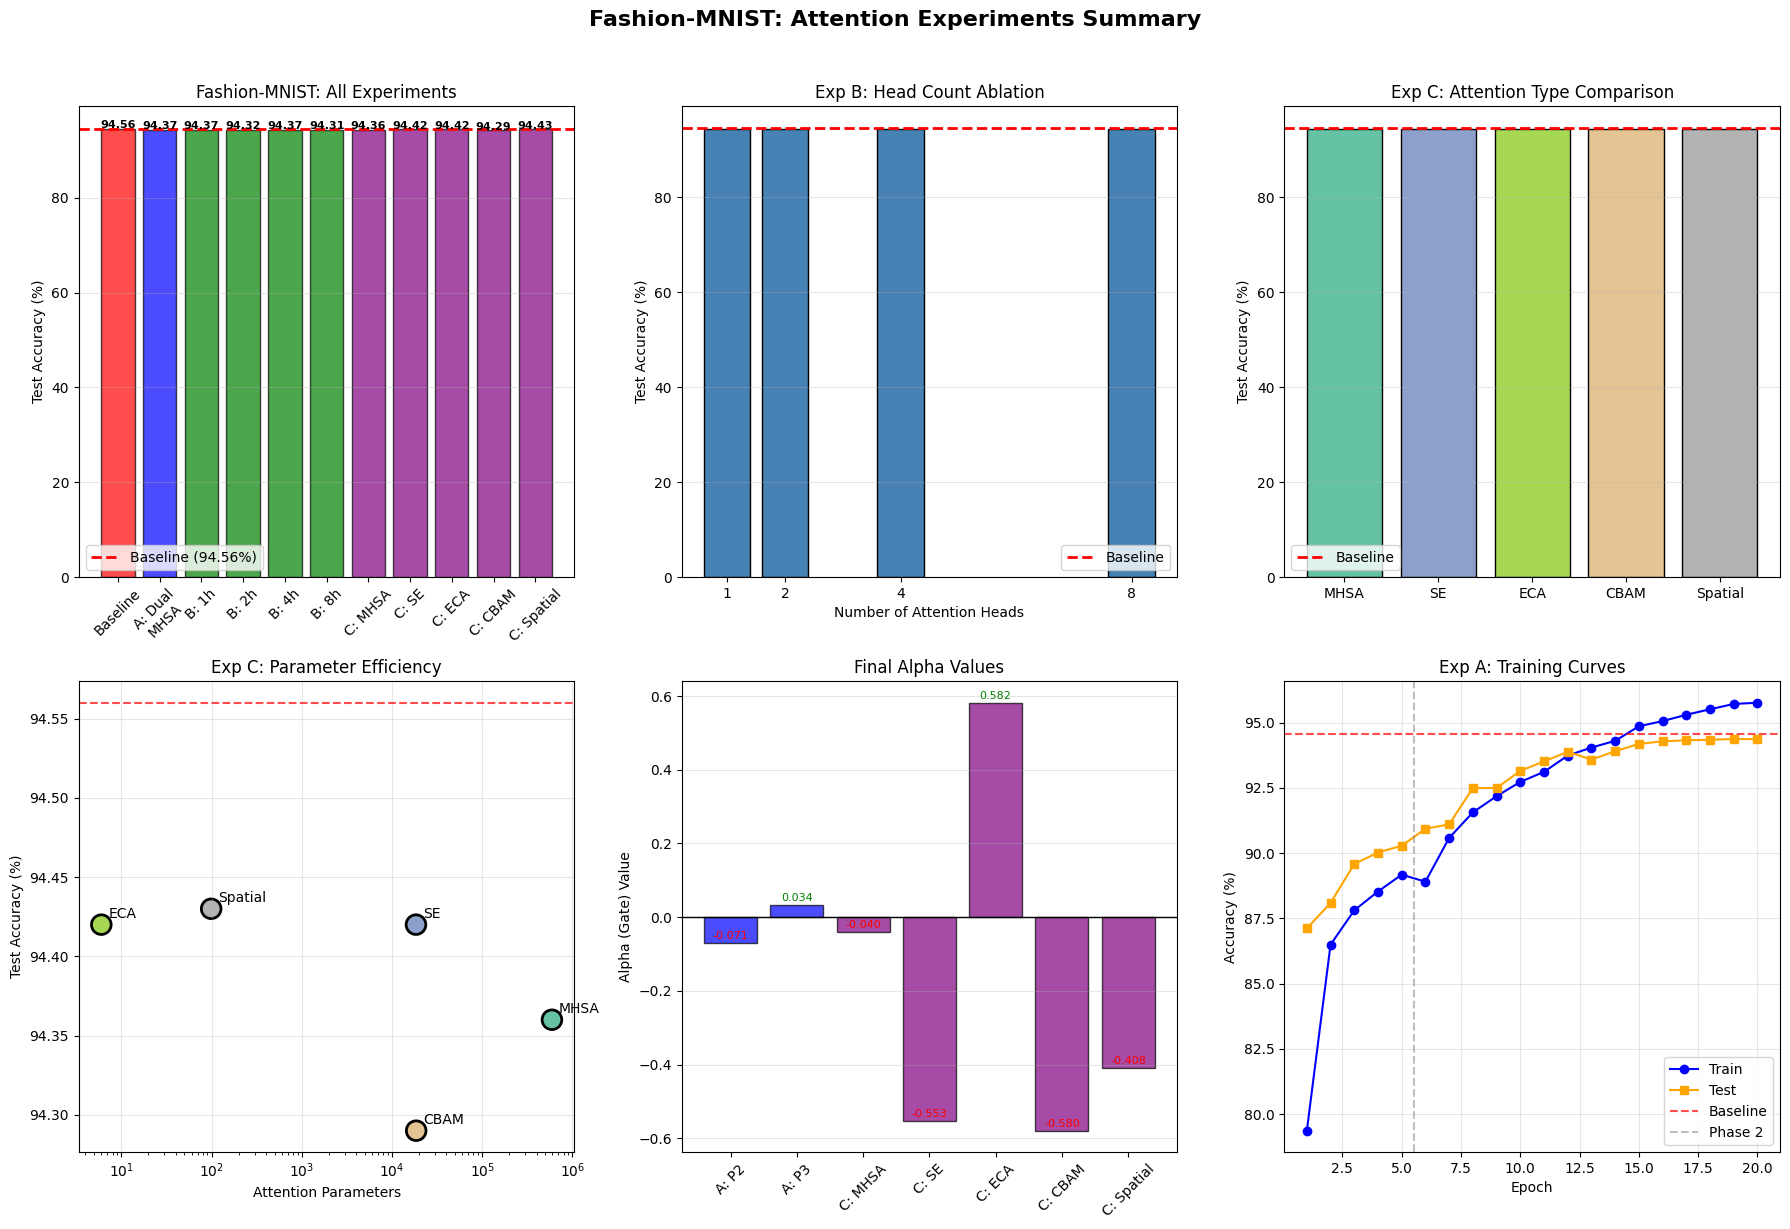

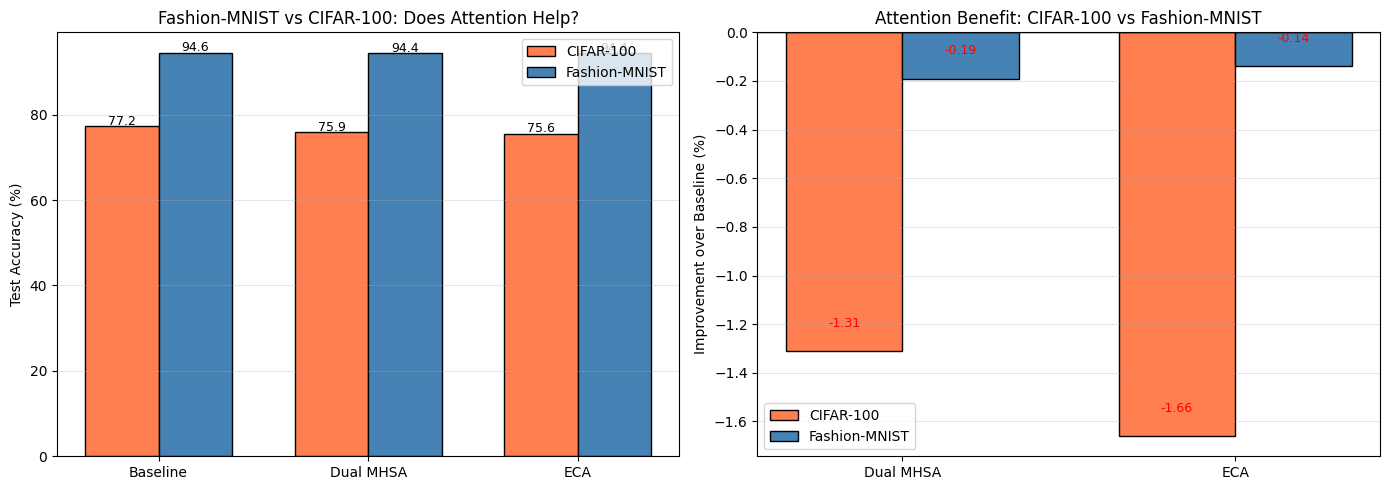


FASHION-MNIST ATTENTION EXPERIMENTS - FINAL SUMMARY

Experiment                Accuracy     vs Baseline     Alpha                    
--------------------------------------------------------------------------------
Baseline                  94.56        -               -                        
A: Dual MHSA              94.37        -0.19%          α_p2=-0.071, α_p3=0.034

Exp B: Head Count
  1 heads:                  94.37        -0.19%
  2 heads:                  94.32        -0.24%
  4 heads:                  94.37        -0.19%
  8 heads:                  94.31        -0.25%

Exp C: Attention Types
  MHSA                 94.36        -0.20%          α=-0.040 (592,129 params)
  SE                   94.42        -0.14%          α=-0.553 (18,433 params)
  ECA                  94.42        -0.14%          α=0.582 (6 params)
  CBAM                 94.29        -0.27%          α=-0.580 (18,531 params)
  Spatial              94.43        -0.13%          α=-0.408 (99 params)

KEY FINDINGS

In [2]:
# ============================================================
# FASHION-MNIST: COMPREHENSIVE RESULTS & VISUALIZATION
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

baseline_acc = fmnist_baseline_acc
exp_a_acc = results_A['best_acc']
exp_b_results = results_B['results']
exp_c_results = results_C['results']

# -----------------------
# FIGURE 1: Overall Summary
# -----------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: All experiments comparison
all_accs = {"Baseline": baseline_acc, "A: Dual\nMHSA": exp_a_acc}
for r in exp_b_results:
    all_accs[f"B: {r['num_heads']}h"] = r['best_acc']
for r in exp_c_results:
    all_accs[f"C: {r['attn_type']}"] = r['best_acc']

names = list(all_accs.keys())
accs = [v * 100 for v in all_accs.values()]

colors = ['red'] + ['blue'] + ['green']*4 + ['purple']*5
bars = axes[0, 0].bar(names, accs, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].axhline(y=baseline_acc*100, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_acc*100:.2f}%)')
axes[0, 0].set_ylabel("Test Accuracy (%)")
axes[0, 0].set_title("Fashion-MNIST: All Experiments")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, accs):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f"{acc:.2f}", ha='center', fontsize=8, fontweight='bold')

# Plot 2: Exp B - Head count
heads = [r['num_heads'] for r in exp_b_results]
head_accs = [r['best_acc'] * 100 for r in exp_b_results]

axes[0, 1].bar(heads, head_accs, color='steelblue', edgecolor='black')
axes[0, 1].axhline(y=baseline_acc*100, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0, 1].set_xlabel("Number of Attention Heads")
axes[0, 1].set_ylabel("Test Accuracy (%)")
axes[0, 1].set_title("Exp B: Head Count Ablation")
axes[0, 1].set_xticks(heads)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Exp C - Attention types
attn_types = [r['attn_type'] for r in exp_c_results]
attn_accs = [r['best_acc'] * 100 for r in exp_c_results]
attn_params = [r['attn_params'] for r in exp_c_results]

colors_c = plt.cm.Set2(np.linspace(0, 1, len(attn_types)))
bars = axes[0, 2].bar(attn_types, attn_accs, color=colors_c, edgecolor='black')
axes[0, 2].axhline(y=baseline_acc*100, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0, 2].set_ylabel("Test Accuracy (%)")
axes[0, 2].set_title("Exp C: Attention Type Comparison")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Plot 4: Parameter efficiency
axes[1, 0].scatter(attn_params, attn_accs, s=200, c=colors_c, edgecolor='black', linewidth=2)
for t, p, a in zip(attn_types, attn_params, attn_accs):
    axes[1, 0].annotate(t, (p, a), textcoords="offset points", xytext=(5, 5), fontsize=10)
axes[1, 0].axhline(y=baseline_acc*100, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel("Attention Parameters")
axes[1, 0].set_ylabel("Test Accuracy (%)")
axes[1, 0].set_title("Exp C: Parameter Efficiency")
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Alpha values
alpha_data = {"A: P2": results_A['final_alpha_p2'], "A: P3": results_A['final_alpha_p3']}
for r in exp_c_results:
    alpha_data[f"C: {r['attn_type']}"] = r['final_alpha']

alpha_names = list(alpha_data.keys())
alpha_vals = list(alpha_data.values())

colors_alpha = ['blue', 'blue'] + ['purple']*5
bars = axes[1, 1].bar(alpha_names, alpha_vals, color=colors_alpha, edgecolor='black', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].set_ylabel("Alpha (Gate) Value")
axes[1, 1].set_title("Final Alpha Values")
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, alpha_vals):
    color = 'green' if val > 0 else 'red'
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f"{val:.3f}", ha='center', fontsize=8, color=color)

# Plot 6: Training curves (Exp A)
epochs = [l['epoch'] for l in results_A['logs']]
axes[1, 2].plot(epochs, [l['train_acc']*100 for l in results_A['logs']], 'o-', label='Train', color='blue')
axes[1, 2].plot(epochs, [l['test_acc']*100 for l in results_A['logs']], 's-', label='Test', color='orange')
axes[1, 2].axhline(y=baseline_acc*100, color='red', linestyle='--', alpha=0.7, label='Baseline')
axes[1, 2].axvline(x=WARMUP_EPOCHS+0.5, color='gray', linestyle='--', alpha=0.5, label='Phase 2')
axes[1, 2].set_xlabel("Epoch")
axes[1, 2].set_ylabel("Accuracy (%)")
axes[1, 2].set_title("Exp A: Training Curves")
axes[1, 2].legend(loc='lower right')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle("Fashion-MNIST: Attention Experiments Summary", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("fmnist_attention_experiments_summary.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# FIGURE 2: Cross-Dataset Comparison (CIFAR-100 vs Fashion-MNIST)
# -----------------------
# Fill in your CIFAR-100 results here
cifar100_baseline = 0.7724
cifar100_exp_a = 0.7593
cifar100_exp_c_eca = 0.7558

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison = {
    "Baseline": [cifar100_baseline*100, baseline_acc*100],
    "Dual MHSA": [cifar100_exp_a*100, exp_a_acc*100],
    "ECA": [cifar100_exp_c_eca*100, [r['best_acc'] for r in exp_c_results if r['attn_type']=='ECA'][0]*100],
}

x = np.arange(len(comparison))
width = 0.35

cifar100_vals = [v[0] for v in comparison.values()]
fmnist_vals = [v[1] for v in comparison.values()]

bars1 = axes[0].bar(x - width/2, cifar100_vals, width, label='CIFAR-100', color='coral', edgecolor='black')
bars2 = axes[0].bar(x + width/2, fmnist_vals, width, label='Fashion-MNIST', color='steelblue', edgecolor='black')

axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Fashion-MNIST vs CIFAR-100: Does Attention Help?')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison.keys())
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f"{bar.get_height():.1f}", ha='center', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f"{bar.get_height():.1f}", ha='center', fontsize=9)

# Improvement comparison
improvements_cifar100 = [(cifar100_exp_a - cifar100_baseline)*100,
                         (cifar100_exp_c_eca - cifar100_baseline)*100]
improvements_fmnist = [(exp_a_acc - baseline_acc)*100,
                       ([r['best_acc'] for r in exp_c_results if r['attn_type']=='ECA'][0] - baseline_acc)*100]

x2 = np.arange(2)
bars1 = axes[1].bar(x2 - width/2, improvements_cifar100, width, label='CIFAR-100', color='coral', edgecolor='black')
bars2 = axes[1].bar(x2 + width/2, improvements_fmnist, width, label='Fashion-MNIST', color='steelblue', edgecolor='black')

axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_ylabel('Improvement over Baseline (%)')
axes[1].set_title('Attention Benefit: CIFAR-100 vs Fashion-MNIST')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(['Dual MHSA', 'ECA'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars1:
    color = 'green' if bar.get_height() > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f"{bar.get_height():+.2f}", ha='center', fontsize=9, color=color)
for bar in bars2:
    color = 'green' if bar.get_height() > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                 f"{bar.get_height():+.2f}", ha='center', fontsize=9, color=color)

plt.tight_layout()
plt.savefig("fmnist_vs_cifar100_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# -----------------------
# SUMMARY TABLE
# -----------------------
print("\n" + "="*80)
print("FASHION-MNIST ATTENTION EXPERIMENTS - FINAL SUMMARY")
print("="*80)

print(f"\n{'Experiment':<25} {'Accuracy':<12} {'vs Baseline':<15} {'Alpha':<25}")
print("-"*80)
print(f"{'Baseline':<25} {baseline_acc*100:<12.2f} {'-':<15} {'-':<25}")
print(f"{'A: Dual MHSA':<25} {exp_a_acc*100:<12.2f} {(exp_a_acc-baseline_acc)*100:+.2f}%          α_p2={results_A['final_alpha_p2']:.3f}, α_p3={results_A['final_alpha_p3']:.3f}")

print("\nExp B: Head Count")
for r in exp_b_results:
    gap = (r['best_acc'] - baseline_acc) * 100
    print(f"  {r['num_heads']} heads:{' '*(17)} {r['best_acc']*100:<12.2f} {gap:+.2f}%")

print("\nExp C: Attention Types")
for r in exp_c_results:
    gap = (r['best_acc'] - baseline_acc) * 100
    print(f"  {r['attn_type']:<20} {r['best_acc']*100:<12.2f} {gap:+.2f}%          α={r['final_alpha']:.3f} ({r['attn_params']:,} params)")

# Best result
best_attn_result = max(
    [("A: Dual MHSA", exp_a_acc)] +
    [(f"B: {r['num_heads']}h", r['best_acc']) for r in exp_b_results] +
    [(f"C: {r['attn_type']}", r['best_acc']) for r in exp_c_results],
    key=lambda x: x[1]
)

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"""
FASHION-MNIST Results:
- Baseline accuracy: {baseline_acc*100:.2f}%
- Best attention model: {best_attn_result[0]} with {best_attn_result[1]*100:.2f}%
- Best improvement: {(best_attn_result[1] - baseline_acc)*100:+.2f}%

CROSS-DATASET COMPARISON:
- CIFAR-100 attention gap (Dual MHSA): {(cifar100_exp_a - cifar100_baseline)*100:+.2f}%
- Fashion-MNIST attention gap (Dual MHSA): {(exp_a_acc - baseline_acc)*100:+.2f}%
""")

if (exp_a_acc - baseline_acc) > (cifar100_exp_a - cifar100_baseline):
    print("✓ HYPOTHESIS SUPPORTED: Attention helps MORE on simpler Fashion-MNIST!")
elif (exp_a_acc - baseline_acc) > 0:
    print("~ PARTIAL SUPPORT: Attention helps on Fashion-MNIST (positive gain)")
else:
    print("✗ HYPOTHESIS NOT SUPPORTED: Attention doesn't help on Fashion-MNIST either")

print("="*80)

# -----------------------
# Save results for LaTeX
# -----------------------
print("\n\nRESULTS FOR LATEX TABLE:")
print("-"*60)
print(f"Baseline: {baseline_acc*100:.2f}%")
print(f"Exp A (Dual MHSA): {exp_a_acc*100:.2f}%")
for r in exp_b_results:
    print(f"Exp B ({r['num_heads']} heads): {r['best_acc']*100:.2f}%")
for r in exp_c_results:
    print(f"Exp C ({r['attn_type']}): {r['best_acc']*100:.2f}% ({r['attn_params']:,} params)")